# Minimal encoding with VRP tutorials

### Contents
* [Introduction](#introduction)
* [Notations](#notations)
* [Minimal Encoding scheme](#scheme)
* [Implementation of minimal encoding](#min)
     * [ Quantum state and ansaz](#min-1)
     * [Cost function](#cost)
     * [Optimisation](#opt)
* [VRP](#vrp)
* [Solving VRP](#solvevrp)

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

## Introduction <a class='anchor' id='introduction'></a>

This tutorials introduce you to an implementation of encoding scheme from the following papers : <br>
* [Qubit-efficient encoding schemes for binary optimisation problems](https://quantum-journal.org/papers/q-2021-05-04-454/)　(21 Apr 2021) -- (1)
* [Qubit efficient quantum algorithms for the vehicle routing problem on quantum computers of the NISQ era](https://arxiv.org/abs/2306.08507)　(14 Jun 2023) -- (2)

The main focus of this tutorial is to expload a possibility of minimal encoding which is a encoding scheme for QUBO problem by reproducing the procedure consider by refrences (1) and (2). In these days there exists various encoding scheme for different problems (Machine learning, numerical optimization etc) and main purpose of these schemes are to encode classical problem into a quantum problem so it can be solve using quantum problem. Main motivation behind this is that there exists a possibility of quantum computing being more efficient than classical computing. <br>

However, current quantum devices (NISQ) known to have two main problems which are noise and limitted number qubits. 
To deal with these problems from software side, there are researches on error correction and error mitigation to deal with noise and on different encdoing methods to deal with limitation of number of qubits availble. <br> 
Minimal encoding belong to the second case. Specifically, to encode QUBO problem into quantum.

For instance QUBO can be solve using QAOA. In this case, QUBO will be encode into Ising Hamiltonian. <br> 
In this case, it requires the same number of qubits as classical variable. So if we have 10 variables in QUBO model, then we need 10 qubits in order to encode QUBO into Ising Hamiltonian. You may realise that with real world problems, this method we will reach the limit of current quantum device pretty quickly. <br> 
This also apply to other problems, as well.<br>

This tutorial introduce a minimal encoding scheme which aim to over come this limitation cause by limited number of qubits availble on current quantum divices.

## Notations

These are notations used in this tutorials.

* $n_c$ : classical bit
* $n_q$ : quantum bit
* $n_a$ : quantum ancila bit
* $n_r$ : quantum register bit
* $ l $ : number of layer for quantum circuit (ansaz)


## Minimal Encoding scheme <a class='anchor' id='scheme'></a>

With this minimal encoding scheme, the number of qubits require for classical bits is reduced. Specifically, it requires $\log_2 n_c$ quantum register bits and 1 quantum ancila bits. Therefore, the number of qubits it use is 
$$ n_q = \log_2 n_c + 1 $$

We will discuss only mathmatical formulas in this section. All implementations will be on the next section.

To encode QUBO problem, we use the following parameterised quantum state
$$ \tag{1} \ket{\psi_1 (\vec{\theta})} = \sum^{n_c}_{i=1} \beta_i (\vec{\theta})[a_i(\vec{\theta}) \ket{0}_a + b_i (\vec{\theta}) \ket{1}_a] \otimes \ket{\phi_i}_r $$

where
$$\{ \ket{\phi_i}_r \} \text{ : computational basis of regsister qubits} $$

$$\{ \ket{0}_a , \ket{1}_a \} \text{ : computational basis of ancilla qubit} $$

To define one-to-one correspondence between each of the $n_c$ classical variables $x_i$ in $\vec{x}$ and a unique basis state $\ket{\phi_i}_r$, the probability of the $i^{th}$ classical variable to have 0 or 1 can be determin as follow : 
$$ Pr(x_i = 1) = |b_i|^2  $$
$$ Pr(x_i = 0) = 1- |b_i|^2 = |a_i|^2 $$

Additionally,  $\beta_i(\vec{\theta})$ capture the likelihood of measuring each register state $\ket{\phi_i}$ and corresponding ancilla qubit

For example, to encoding the probability distribution over all solutions $\vec{x}$ of dimentions $n_c = 4$ which requires $n_r = 2$, mapping will be look like 
$$ \ket{\phi_1}_r = \ket{00}_r, \ket{\phi_2}_r = \ket{01}_r, \ket{\phi_3}_r = \ket{10}_r,\ket{\phi_4}_r = \ket{11}_r $$ and if $ \vec{x} = (1,0,0,1) $
then we have 
$$\ket{\psi_1} = (\ket{1}_a\ket{00}_r+\ket{0}_a\ket{01}_r + \ket{0}_a\ket{10}_r + \ket{1}_a\ket{11}_r)/2 $$

*This scheme can encode only distribution functions of statistically independent classical variables, which is a limitation of minimal encoding

As with standard VQAs, we define cost function as follow : 
$$ C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P_i^1}\rangle_{\vec{\theta}} \langle \hat{P_i^j}\rangle_{\vec{\theta}}}{\langle \hat{P_i}\rangle_{\vec{\theta}}\langle \hat{P_j}\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

where : 
$$ \hat{P}_i = \ket{\phi_i}\bra{\phi_i}_r \text{ : projectors over registers, independent of the ancilla state }$$
$$ \hat{P}^1_i = \ket{1}\bra{1}_a \otimes \hat{P}_i \text{ : projectors over registers with ancilla being }\ket{1}_a$$

then, expectation values are expresses as follow : 
$$ \langle \hat{P}_i \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})} $$
given that 
$$ b_i(\vec{\theta}) = \langle \hat{P}_i^1 \rangle_{\vec{\theta}} / \langle \hat{P}_i \rangle_{\vec{\theta}} $$
For a detailed derivation of the cost function, please check the appendix of the paper (1).

This cost function is to minimise the parameters $ \vec{\theta} $. Global minimum of the cost function is the exact solution to minimize QUBO.

The highly entangled quantum state that minimize the cost function : $\ket{\psi} = \sum_i \beta_i \ket{\sigma_i}_a \otimes \ket{\phi_i}$ with $\sigma = \{ 0,1 \}$ and corresponds unambiguously to the exact solution $\vec{x} = [\sigma_1, .... , \sigma_{n_c}]$ that minimize QUBO define by $A$. 

$C_1 (\vec{\theta})$ is only depends on the set of norm $\{ |b_i|^2 \}$, so measurements on computational basis is sufficient for estimation. <br>


The cost function cannot be reduce to a linear function of expectation values. That is why QUBO model of this encoding scheme cannot be describede with a suitable Hamiltonian. It means that we cannot use standfard Quantum optimization methods such as QAOA or VQA. 

So, we follow the following optimization procedure : 
1. Start with random starting point $\theta_{init}$.
2. Measure the quantum state in computation basis ($\{ 0, 1 \}$)
3. Feed result to classical optimizer which update parameter $\theta_{new}$
4. After the function is minimzed, with the final quantum state $\ket{\psi(\vec{\theta}_{opt})}$, a set of solutions $\{ \vec{x} \}$ with value $C_x = xAx$ are obtained by sampleing each variable independently follwing $ Pr(x_i = 1) = |b_i|^2 $

## Implementation of minimal encoding <a class='anchor' id='min'></a>

In this section, we will see how to implement each part of minimal encoding with Python. 
1. Quantum state and ansaz (parameterised quantum circuit) 
2. Cost function 
3. Optimization procedure

### Quantum state and ansaz <a class='anchor' id='min-1'></a>

First, we import all necessary libraries.

In [1]:
import qiskit as qk
from qiskit import QuantumRegister, AncillaRegister , QuantumCircuit
from qiskit.circuit import  ParameterVector

from math import pi
import numpy as np

The initial quantum state (1) is produced by applying parameterized unitary evolution to initial product state $\ket{\psi_0}$ which can be express as follow : 

$$ \ket{\psi_1(\vec{\theta})} = \hat{U_1}(\vec{\theta})\ket{\psi_0} $$ 

This can be express as hardware efficient quantum circuit, and a single layer of this circuit is ... 

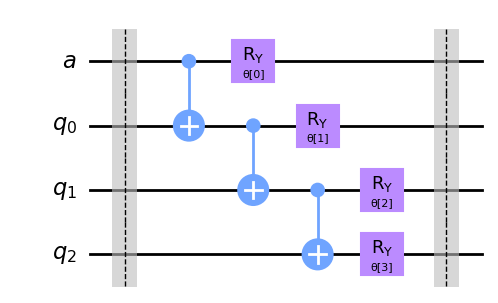

In [2]:
qreg_q = QuantumRegister(3, 'q')
areg_a = AncillaRegister(1, 'a')

circuit = QuantumCircuit(areg_a, qreg_q)
parameters = ParameterVector('θ', 4)
circuit.barrier()
circuit.cx(areg_a[0], qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ry(parameters[0], areg_a[0])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(parameters[1], qreg_q[0])
circuit.ry(parameters[2], qreg_q[1])
circuit.ry(parameters[3], qreg_q[2])
circuit.barrier()


circuit.draw(output='mpl')

There is no specific number of layer specified for this encoding scheme, so you can set it to any number. However, if you increase the number of layer, it increases the number variables thus it increase the number of computations for every iteration of optimization. 4 is good number of layer to start with. 

To construct the ansaz circuit, first we need to define the number of qubits ($n_r + n_a$) which is based on the problem and the number of layer. 

In [3]:
#example
nr = 3
na = 1
nq = 4
l = 4

Then we generate parameters with random numbers.

In [4]:
def init_parameter(nq:int , l:int):
    #initialize a parameters
    parameters = ParameterVector('θ', nq*l)
    #create a dictionary of parameters with random values and return it
    theta =  {parameter: np.random.random() for parameter in parameters}
    return parameters, list(theta.values())

We now generate a parameterized circuit (ansaz). Do not forget to apply Hadmard gate as a first step before adding layers.

In [5]:
def generate_circuit(nr:int, na:int, l:int, parameters:np.array)->qk.circuit.quantumcircuit.QuantumCircuit:
    #define number of qubits
    nq = nr + na
    qreg_q = QuantumRegister(nr, 'q')
    areg_a = AncillaRegister(na, 'a')
    circuit = QuantumCircuit(areg_a, qreg_q)

    #add H gate for each qubit
    circuit.h(areg_a[0])
    for i in range(0,nr):
        circuit.h(qreg_q[i])
    circuit.barrier()
  
    #add layers which consist of CNOT and Ry gate
    for j in range(0,l):
        #CNOT
        # circuit.cx(qreg_q[0],areg_a[0])
        circuit.cx(areg_a[0],qreg_q[0])
        for i in range(nr):
            if i != 0:
                # circuit.cx(qreg_q[i],qreg_q[i-1]) 
                circuit.cx(qreg_q[i-1],qreg_q[i]) 

        #Ry
        for i in range(nq):
            if i == 0:
                circuit.ry(parameters[nq*j+i], areg_a[i])
            else:
                circuit.ry(parameters[nq*j+i], qreg_q[i-1])  
        circuit.barrier()
    return circuit

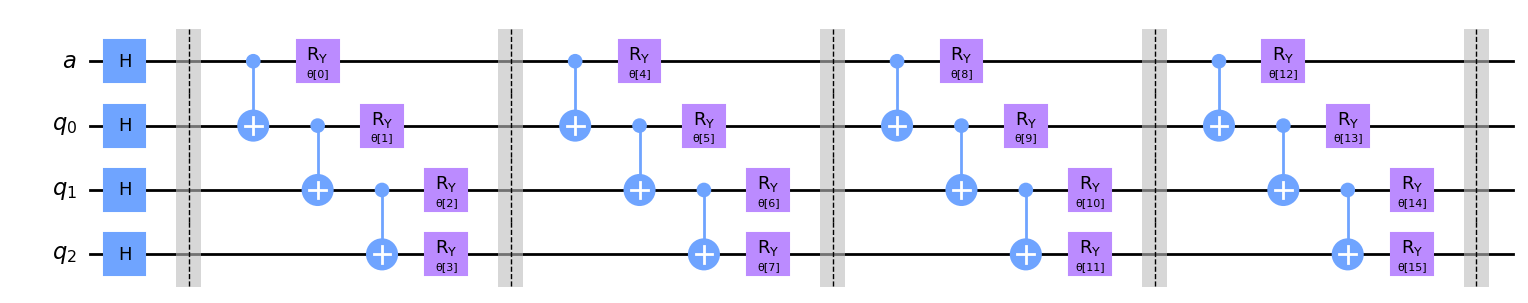

In [6]:
parameters, theta = init_parameter(nq, l)
circuit = generate_circuit(nr, na, l, parameters)
circuit.draw(output='mpl')

### Cost function <a class='anchor' id='cost'></a>

Recall the cost function : 
$$ C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P}_i^1\rangle_{\vec{\theta}} \langle \hat{P}_j^1\rangle_{\vec{\theta}}}{\langle \hat{P}_i\rangle_{\vec{\theta}}\langle \hat{P}_j\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

Summation can be express using nested for loop, and setting each expectation values as $P$ and $P^1$ we can easily write a function as follow : 

In [7]:
def init_cost_function(A:np.ndarray, nc:int):
    #define cost function
    def cost_function(P1:np.array, P:np.array)->float:
        # first sum of cost function 
        first_sum = 0
        for i in range(nc):
            for j in range(nc):
                if i != j:
                    first_sum += A[i][j]*(P1[i]/P[i])*(P1[j]/P[j])
        # second sum of cost function 
        second_sum = 0
        for i in range(nc):
            second_sum += A[i][i]*(P1[i]/P[i])

        result = first_sum + second_sum
        return  result
    
    return cost_function

Where $A$ is a real symetric matrix from QUBO. <br> 
We define function inside another function just so we don't have to pass $A$ every time we compute cost function.

We talk about how to compute expectation value on the next section.

### Optimisation <a class='anchor' id='opt'></a>

In [8]:
from qiskit.quantum_info import SparsePauliOp

import itertools

Recall that we cannot use general quantum optimization algorithm such as QAOA and VQA, we need to set a procedure. 
The main thing on this part is to implement the function that will be optimized using classical optimizor.
Actually, we already implemented the cost function but we have not implement how to obtain values for $P$ and $P^1$. To obtain those values, we can use Qiskit　Estimator (https://qiskit.org/documentation/apidoc/primitives.html). With this, we can easily compute the expectation values.

The expectation value can be compute as follow : 
$$ \bra{\psi_i(\theta_k)} H_j \ket{\psi_i(\theta_k)}$$
where : 
- $\psi(\theta)$ -> Quantum circuit
- $H_j$ -> Observable
- $\theta_k$ -> Parameter values

Quantum circuit is already implemented, and parameter values are updated every iteration of optimization. So now we need to implement the observables which is a list of Pauli operators. We can implement them easily using Qiskit SparsePauliOp (https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html#qiskit.quantum_info.SparsePauliOp)

Observables we are interested in this case is the all possible outcomes of the circuit. Since we measure the final quantum state with computational basis, observables are all possible combination of $\ket{0}$ and $\ket{1}$ <br>
Recall that $\sigma_Z \ket{0} = \ket{0}$ and $\sigma_Z \ket{1} = -\ket{1}$, we can see that Pauli operator for $\ket{0}$ and $\ket{1}$ are quite simple as follow : 
- $\ket{0} \: => \: \frac{1}{2}(\sigma_I + \sigma_Z) \ket{0}$
- $\ket{1} \: => \: \frac{1}{2}(\sigma_I - \sigma_Z) \ket{1}$
Now, we just need to combine them together using a tensor product. <br>
Let us now implement those Pauli Operators and the function for optimization. 

Recall that, 
$$ \langle \hat{P}_i \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})} $$
$$ \langle \hat{P}_i^1 \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i^1 \ket{\psi_1 (\vec{\theta})} $$
where 
$$ \hat{P}_i = \ket{\phi_i}\bra{\phi_i}_r \:,\:\:\hat{P}^1_i = \ket{1}\bra{1}_a \otimes \hat{P}_i $$

In [9]:
def define_pauli_op(nr:int, ancilla:bool=False)->list[SparsePauliOp]:
    #total number of qubits (nq+na) where na is number of ancilla qubits and is always 1
    #get all binary 2^nq pattern
    l = [list(i) for i in itertools.product([0, 1], repeat=nr)]
    l = np.array(l)

    #basic pieces of SparsePauliOp 
    #PauliOp for |0> 
    P0 = SparsePauliOp.from_list([('I', 1/2), ('Z', 1/2)])
    #PauliOp for |1> 
    P1 = SparsePauliOp.from_list([('I', 1/2), ('Z', -1/2)])
    #Indentiy op
    Id = SparsePauliOp.from_list([('I', 1)])

    #init list of SparsePauliOp 
    pauli_op = []
    for i in range(len(l)):
        pauli_op.append(SparsePauliOp.from_list([('',1)]))
        for j in l[i]:
            if j == 0:
                #|0>
                pauli_op[i] = pauli_op[i].tensor(P0)
            else: 
                #|1> 
                pauli_op[i] = pauli_op[i].tensor(P1)

    #add ancilla qubit
    for i in range(len(pauli_op)):
        if ancilla == True:
            pauli_op[i] = pauli_op[i].tensor(P1)
        else:
            pauli_op[i] = pauli_op[i].tensor(Id)
    
    return pauli_op

In [10]:
def fun(params, ansatz, estimator, cost_function, H, Ha, progress_history:list = None):
    #get expectation values from a circuit
    #get a expectation value of each H
    job1 = estimator.run([ansatz]*len(H),H,[params]*len(H))
    P = job1.result()
    # print(f"The primitive-job finished with result {P}")

    job2 = estimator.run([ansatz]*len(H),Ha,[params]*len(H))
    P1 = job2.result()
    print(f"The primitive-job finished with result {P1}")

    result = cost_function(P1.values, P.values)
    if progress_history is not None:
        progress_history.append(result)
    print(result)
    return result

Again, we define function inside another function so we don't have to pass so many parameters every iteration of the optimization. Only parameter change on each iteration is the $\theta$ <br>
Side note:notice that you can set the number of shot (or number of measurememnt). When it is not set for any number, it computes exact expectation value. We found that, setting it to None produces the most stable result overall. But you are welcome to experiment with it

After the $\theta$ value is minimized, we will get the final quantum state using the final values of $\theta$. Then obtain the final array of binary based on the probability. <br> 
Recall the quantum state we initially define : 
$$\ket{\psi_1 (\vec{\theta})} = \sum^{n_c}_{i=1} \beta_i (\vec{\theta})[a_i(\vec{\theta}) \ket{0}_a + b_i (\vec{\theta}) \ket{1}_a] \otimes \ket{\phi_i}_r $$
We obtain the final binary array based on the ancila qubits which are define with probability s.t. 
- $Pr(x_i = 1) = |b_i|^2$
- $Pr(x_i = 0) = 1 - |b_i|^2$ <br>

These probability can be computed by : 
$$ b_i(\vec{\theta}) = \frac{\langle \hat{P}_i^1 \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$
consider that 
$$ \frac{\hat{P}_i^1}{\hat{P}_i} = \frac{\ket{1}\bra{1}_a \otimes \ket{\phi_i}\bra{\phi_i}_r}{\ket{\phi_i}\bra{\phi_i}_r} = \ket{1}\bra{1}_a$$
so we can find $b_i(\theta)$ by : 
$$ 
\frac{\langle \hat{P}_i^1 \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}} = 
\frac{\bra{\psi_1 (\vec{\theta})}\hat{P}_i^1 \ket{\psi_1 (\vec{\theta})}}{\bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})}} $$

After compute all $|b_i(\vec{\theta})|^2$, we also have $|a_i(\vec{\theta})|^2 = 1 - |b_i(\vec{\theta})|^2$. 
The function below decide $x_i$ on those two values such that 
- If $|b_i(\vec{\theta})|^2 > |a_i(\vec{\theta})|^2 => x_i = 1$ 
- Else $x_i = 0$

Please note that the function below does not take into account the case when $|b_i(\vec{\theta})|^2 \text{ and } |a_i(\vec{\theta})|^2 $ are very close to each other or equal. Simply because we never had such case while trying to solve optimization problems with minimal encoding. 

In [11]:
def get_ancilla_prob(theta:dict, 
                     circuit:qk.circuit.quantumcircuit.QuantumCircuit, 
                     nr:int)->np.array:
    estimator = Estimator()
    #define observable to calculate expectation value
    H = define_pauli_op(nr, ancilla=False)
    Ha = define_pauli_op(nr,ancilla=True)
    #get expectation values from
    job1 = estimator.run([circuit]*len(H),H,[theta]*len(H))
    P = job1.result()
#     print(f"The primitive-job finished with result {P}")
    job2 = estimator.run([circuit]*len(H),Ha,[theta]*len(H))
    P1 = job2.result()
#     print(f"The primitive-job finished with result {P1}")
    #compute b_i and a_i
    b_sq=[] # list of probability of ancilla qubit being |1>
    a_sq=[] # list of probability of ancilla qubit being |0>
    for i in range(len(P.values)):
        val = (P1.values[i] / P.values[i])**2
        b_sq.append(val)
        a_sq.append(1 - b_sq[i])

    final_binary = []
    #compare a and b and pick the larger one
    for i in range(len(a_sq)):
        if a_sq[i] > b_sq[i]:
            final_binary.append(0)
        else:
            final_binary.append(1)

    print(f"b is Pr(x=1){b_sq}")
    print(f"a is Pr(x=0){a_sq}")
    #need to fix return value
    # print(f"final binary is {final_binary}")
    final_binary = np.array(final_binary)
    return final_binary

The return value of the function corresponds to the solution $\vec{x}$ that minimized QUBO problem.

## VRP <a class='anchor' id='vrp'></a>

First, we import all necessary libraries for this section

In [12]:
import jijmodeling as jm
import geocoder as gc
import math
import matplotlib.pyplot as plt

In this section we define the VRP we consider for this tutorial, and implement it.

VRP is well known combinational optimization problem where goal is to find the best set of routes for fleet of vechiles. Definition of "the best set of routes" changes depends on how you define the problem.
There are various different varient of VRP and also, there are many different ways to solve it. 

One of example for VRP is optimizing the delivery system in Japan. Japanese delivery oftern has specific time and date that a packet need to be delier to a certain customer. With VRP, you can find the best combination of routes for fleet of vechiles that is efficient and satisfies all requirements (time and date). Also, you might need to consider the capacity of each vechicles etc. 

The refrence (2) uses VRPWT (Vechile routing problem with time window) with route based formulation. 
With the route based formulation, first we generate possible routes with given locations, then feed the costs of those routes to optimizer to find the best set of routes. So key part of this formulation is how to generate routes and what constraints we set such as time window and vechicle capacity. Time window is one of the component that we take into consideration when we generate routes.
However, adding those limitations increase complexity of route generating process. 
Considering that our focus here is minimal encoding and not VRP, we are not considering time window and just using simplest form of VRP to explore the possibility of ninimum encoing.

The VRP we define for in this case only consider the cost of each rotue which is a distance. We also have constrain where each locations are visited only once except the depot where all vechicle depart and return to. <br>

First, we define each variables and implement a mathmatical formula using JijModeling : 

- R: set of routes 
- r: $r \in R$, each routes
- N: set of locations
- n: $n \in N$, each location
- i: each location except the depot
- x: $x\in \{ 0, 1 \}$
- d: $\delta$, equal to 1 if node $i$ lies in route $r$ and 0 otherwise

In [13]:
def set_problem():
    # Define the problem
    c = jm.Placeholder('c', ndim=1) #cost of each route
    n = jm.Placeholder('n', ndim=1) #node (location)
    d = jm.Placeholder('d', ndim=2).set_latex(r'\delta') #delta

    R = c.shape[0].set_latex("R") #set of routes
    N = n.shape[0].set_latex(r'\mathscr{N}') #set of nodes which is locations
    r = jm.Element('r', belong_to=(R)) 
    i = jm.Element('i', belong_to=(1,N))
    x = jm.BinaryVar('x', shape = R)


    problem = jm.Problem('VRP')
    problem += jm.sum(r, c[r]*x[r])
    const = jm.sum(r, d[r,i]*x[r])
    problem += jm.Constraint("one-time", const==1, forall=i)
    print(problem)

    return problem
set_problem()

Next, we generate instance data for the problem. <br> 
We can use random location but we define locations by ourselves for simplicity. We set only five locations so we can see if solution is correct or not.

For example : 

In [14]:
points = ['東京千代田区' ,'練馬区', '江戸川区', '文京区', '大田区']
# points = ['東京千代田区' ,'練馬区','品川区','文京区','港区','足立区','杉並区','葛飾区','江戸川区','世田谷区','渋谷区','江東区','荒川区','北区','目黒区','板橋区','中央区']
n = [index for index in range(len(points))] #index for each location

The first location on the points list is the depot.

In [15]:
depot = points[0]
depot

'東京千代田区'

We use Python library geocoder (https://pypi.org/project/geocoder/) to generate all location data.

In [16]:
def geo_information(points:list[str]):
     # get the latitude and longitude
    latlng_list = []
    try:
        for point in points:
            location = gc.osm(point)
            latlng_list.append(location.latlng)
        # make distance matrix
        num_points = len(points)
        inst_d = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(num_points):
                a = np.array(latlng_list[i])
                b = np.array(latlng_list[j])
                inst_d[i][j] = np.linalg.norm(a-b)
        geo_data = {'points': points, 'latlng_list': latlng_list}
        distance_data = {'d': inst_d}
    except:
        print("Your machine may not connect to the internet. Please check your connection.")
        print("If that's not the case, there may be a problem with the location you entered.")
        return 0

    # print(f'geo_data: {geo_data}')
    # print(f'distance: {distance_data}')
    return geo_data, distance_data

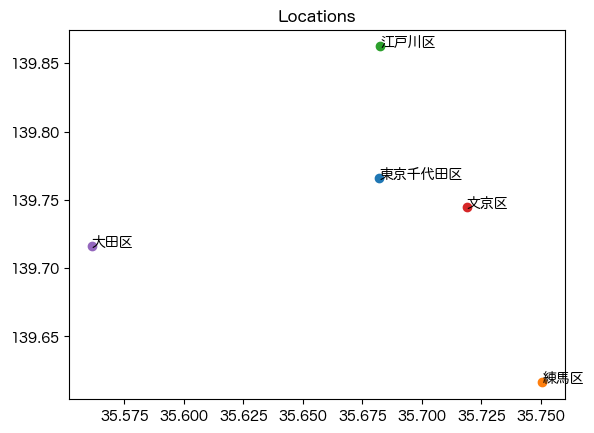

In [17]:
geo_data, distance_data = geo_information(points)
points = geo_data['points']
latlng_list = geo_data['latlng_list']

#set the plot so you can plot Japanese
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
#plot the points
for i in range(len(points)):
    plt.plot(latlng_list[i][0], latlng_list[i][1], marker='o')
    plt.text(latlng_list[i][0], latlng_list[i][1], points[i])
plt.title('Locations')
plt.show()

The most complex part of problem forming with VRP is route generating process. <br>
If you generate all possible routes, you will have $(N-1)!$ routes. Which becomes heavy operation quickly. To avoid this we implement greedy route genration. This method basically pick cheapest route (nearest next location) from current location. At the beggining, we set the number of vechicles and then set the number of location that each vechicles visit before returning to the depot. <br>
Initially, we set all possible outgoing route from the depot for the first vechcle, then go through nearest unvisited location and come back to the depot. Then, other vechicles go through nearest non-visited locations. Thus we only generate $(N-1)\times v$ routes at the most where $v$ is the number of vechcles.

In [18]:
#find nearest location from currebt location 
def find_min_distance(distance:list[float])->int:
    #copy the distance array 
    min_distance = min(distance)
    min_index = np.where(distance == min_distance)[0][0]
    # print(f'min_index: {min_index}')
    return min_index

#find unvisited nearest location 
def find_next_location(current_location:int, visited_location:list[int], distance_matrix:list[list[float]])->int:
    #get the distance from current location to other locations
    distance = distance_matrix[current_location].copy()
    #set the distance of visited location to infinity
    # print(f'distance 1: {distance}')
    for i in visited_location:
        distance[i] = math.inf
    # print(f'distance 2: {distance}')
    #find the next location
    next_location = find_min_distance(distance)
    return next_location

#this is delta that is part of mathmatical formula (based on the definiton on the paper)
def get_delta(route:list[int], n:int)->list:
    delta = np.zeros(n)
    for i in route:
        delta[i] = int(1)
    
    return list(delta)


def greedy_route_generating(points:list[str], v:int):
    #get the latitude and longitude and distance matrix
    geo_data, distance_data = geo_information(points)
    distance_matrix = distance_data['d']

    #set the maximum number of location that each vechicle can visit
    p = math.ceil((len(points)-1) / v)

    #initialized visited location 
    visited_location = []
    #initialize necessary dict and lists
    routes = {
        'route': [],
        'c': [], 
        'd': [], 
        'n': []
    }
    visited_location = []   
    initial_route = []
    #generate possible routes
    for i in range(1, len(points)):
        route = [0, i]
        initial_route.append(route) 
    # print(f'routes: {routes}')
    # print(f'test{routes[0][-1]}')
    # print(f'visited_location: {visited_location}')
    #generate routes
    for i in range(len(points)-1):
        # visited = [0]
        visited_location.append([0])
        count = 0 
        # print(f'visited_location: {visited_location}')
        # print(f'len(visited_location[i]): {len(visited_location[i])}')
        # print(f'len(points)-1: {len(points)-1}')
        while len(visited_location[-1]) != len(points):
            count += 1
            route = [0]
            cost = 0
            routes['route'].append(route)
            routes['c'].append(cost)
            # print(f'range p {p}')
            for j in range(p):
                if count == 1 and j == 0:
                    current_location = routes['route'][-1][-1]
                    next_location = initial_route[i][-1]
                    cost += distance_matrix[current_location][next_location]
                    routes['route'][-1].append(next_location)
                    visited_location[-1].append(next_location)
                else:
                    current_location = routes['route'][-1][-1]
                    next_location = find_next_location(current_location, visited_location[-1], distance_matrix)
                    cost += distance_matrix[current_location][next_location]
                    routes['route'][-1].append(next_location)
                    visited_location[-1].append(next_location)
                
            delta = get_delta(routes['route'][-1], len(points))
            routes['d'].append(delta)
            routes['route'][-1].append(0)
            routes['c'][-1] = cost
    # print(f'visited_location: {visited_location}')

    return routes

## Solving VRP <a class='anchor' id='splvevrp'></a>

First we import necessary libraries for this part.

In [19]:
import jijmodeling.transpiler as jmt
import openjij as oj
import warnings
from qiskit.algorithms.optimizers import COBYLA
import dimod

/var/folders/lj/d00jpvwx00d3j_pnmjtgyzfh0000gn/T/ipykernel_1754/1400866424.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In this section, we actually solve VRP we defined on the previous section. <br>
First, we solve it using OpenJij to produce correct solution. Then we try to solve using minimal encosing and compare thoses solutions. 

We need to define some functions that are necessary to visualize solutions.

In [20]:
def get_routs_from_index(indecies:list[int], routes:list[list[int]])->list[list[int]]:
    optimised_routes = []
    for i in indecies:
        optimised_routes.append(routes['route'][i])
    
    return optimised_routes

def plot_route(routes:list[list[int]],
               geo_data:dict,
               cost:float = None, ):
    #get the latitude and longitude and distance matrix
    points = geo_data['points']
    latlng_list = geo_data['latlng_list']

    #set the plot so you can plot Japanese
    plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
    #plot the points
    for i in range(len(points)):
        plt.plot(latlng_list[i][0], latlng_list[i][1], marker='o')
        plt.text(latlng_list[i][0], latlng_list[i][1], points[i])
    #plot the route
    for route in routes:
        route_points = []
        for i in route:
            route_points.append(latlng_list[i])
        route_points = np.array(route_points)
        plt.plot(route_points[:,0], route_points[:,1], marker='o')
    
    if cost is not None:
        plt.title(f'ルート (コスト＝{cost})')
    else:
        plt.title('ルート')
    plt.show()

    return 0

from abc import ABC, abstractmethod
from typing import List

#==========================================
#We also use some code written by 松山さん to get optimized routes

class LocalSearch(ABC):
    def __init__(self, distance_matrix: List[List[float]]):
        self.distance_matrix = np.array(distance_matrix)
        super().__init__()

    @abstractmethod
    def local_search(self, initial_solution: List[int]) -> List[int]:
        raise NotImplementedError

    def calculate_cost(self, solution: List[int]) -> float:
        return (
            np.sum(self.distance_matrix[solution[:-1], solution[1:]])
            + self.distance_matrix[solution[-1], solution[0]]
        )

class TwoOpt(LocalSearch):
    def local_search(self, initial_solution: List[int]) -> List[int]:
        best_solution = initial_solution
        improved = True

        while improved:
            improved = False
            for i in range(1, len(best_solution) - 2):
                for j in range(i + 1, len(best_solution)):
                    if j - i == 1:
                        continue  # changes nothing, skip then
                    new_solution = best_solution[:]
                    new_solution[i:j] = best_solution[
                        j - 1 : i - 1 : -1
                    ]  # this is the 2-optSwap
                    if self.calculate_cost(new_solution) < self.calculate_cost(
                        best_solution
                    ):
                        best_solution = new_solution
                        improved = True
        return best_solution
    
#==========================================


def two_opt_for_vrp(distance_data, routes, results):
    twoopt = TwoOpt(distance_data)
    sol_routes = []
    for result in results:
        routes[result] = twoopt.local_search(initial_solution=routes[result]) 
        sol_routes.append(routes[result])
    return sol_routes

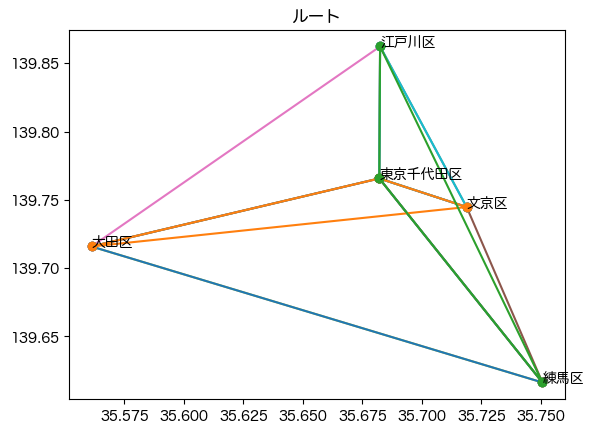

0

In [21]:
routes = greedy_route_generating(points, 3)
plot_route(routes['route'], geo_data)

In [22]:
def vrp_solution(result:oj.sampler.response.Response, 
                 pubo_builder:jmt.core.pubo.pubo_builder.PuboBuilder,
                 compiled_model:jmt.core.compile.compiled_model.CompiledInstance,
                 geo_data:dict,
                 distan_data:dict,
                 routes:dict):
    
    results = jmt.core.pubo.decode_from_openjij(result, pubo_builder, compiled_model)
    feasibles = results.feasible()
    print(f'feasibles: {feasibles}')
    objectives = np.array(feasibles.evaluation.objective)
    lowest_index = np.argmin(objectives)
    print(f"Lowest solution index: {lowest_index}, Lowest objective value: {objectives[lowest_index]}")
    nonzero_indices, nonzero_values, shape = feasibles.record.solution["x"][lowest_index]
    print("indices: ", nonzero_indices)
    print("values: ", nonzero_values)

    #get the routes from the indices
    optimised_routes = two_opt_for_vrp(distance_data['d'], routes['route'], nonzero_indices[0])    
    cost = 0
    for i in nonzero_indices[0]:
        cost += routes['c'][i]
    plot_route(optimised_routes, geo_data,cost)

    return optimised_routes, cost 

First, we define problem, formalize instance data, and compile it into QUBO.

In [23]:
#set the warning off
warnings.filterwarnings('ignore')
# Define the problem
problem = set_problem()
#list of points, the first location is the depot
points = ['東京千代田区' ,'練馬区', '江戸川区', '文京区', '大田区']
# points = ['東京千代田区' ,'練馬区','品川区','文京区','港区','足立区','杉並区','葛飾区','江戸川区','世田谷区','渋谷区','江東区','荒川区','北区','目黒区','板橋区','中央区']
n = [index for index in range(len(points))]

#get geo data 
geo_data, distance_data = geo_information(points)
#generate routes
routes = greedy_route_generating(points, 3)
routes['n'] = n

print(f'routes: {routes}')
l = len(routes['route'])
print(f'number of routes => {l}')
# compile problem
compiled_model = jmt.core.compile_model(problem, routes, {})
# # Quadratic Unconstraint Binary Optimization (QUBO) model
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model)
qubo, const = pubo_builder.get_qubo_dict(multipliers = {'one-time': 500})

routes: {'route': [[0, 1, 3, 0], [0, 2, 4, 0], [0, 2, 3, 0], [0, 4, 1, 0], [0, 3, 2, 0], [0, 4, 1, 0], [0, 4, 3, 0], [0, 2, 1, 0]], 'c': [0.296729784795773, 0.2867591093283513, 0.21970123356993992, 0.34478772498554666, 0.1653235468721757, 0.34478772498554666, 0.2910018830403773, 0.35194976847967907], 'd': [[1.0, 1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0]], 'n': [0, 1, 2, 3, 4]}
number of routes => 8


Solve with OpenJij.

feasibles: SampleSet(record=Record(solution={'x': [(([4, 5],), [1, 1], (8,)), (([3, 4],), [1, 1], (8,)), (([2, 3],), [1, 1], (8,)), (([2, 5],), [1, 1], (8,)), (([2, 5],), [1, 1], (8,)), (([2, 5],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,))]}, num_occurrences=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), evaluation=Evaluation(energy=[-1998.3961093056146, -1998.5506134183254, -1998.3421245121292, -1998.3961093056146, -1998.3421245121292, -1998.3421245121292, -1998.3421245121292, -1998.5506134183254, -1998.3961093056146, -1998.3961093056146], objective=[0.5101112718577223, 0.5101112718577223, 0.5644889585554866, 0.5644889585554866, 0.5644889585554866, 0.5644889585554866, 0.5834888941241243, 0.5834888941241243, 0.5834888941241243, 0.5834888941241243], constraint_violations={'one-time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None

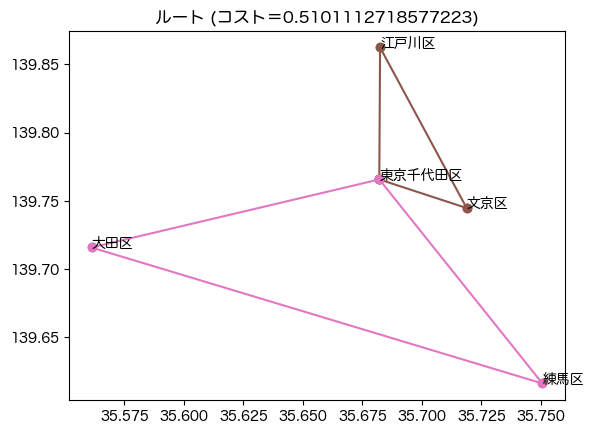

In [24]:
sampler = oj.SASampler()
# solve problem
result = sampler.sample_qubo(qubo, num_reads=10)
#get solution
vrp_result = vrp_solution(result, pubo_builder, compiled_model, geo_data, distance_data, routes)

Solve with minimal encoding

In [25]:
nc = len(routes['route']) 
nr = math.log2(nc)
l = 4
na = 1
nq = int(nr + na)

if nr.is_integer() == False:
    print("The number of register qubits should be integer")
else: 
    nr = int(nr)

There are some other function we have not define that are necessary for minimal encoding.

In [26]:
def check_symmetric(A:np.ndarray, rtol=1e-05, atol=1e-08)->bool:
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

def convert_qubo_datatype(qubo:dict[tuple[int, int], float] , nc:int)->np.ndarray:
    qubo_matrix = np.zeros((nc, nc))
    for key, value in qubo.items():
        qubo_matrix[key[0], key[1]] = value 
    
    return qubo_matrix

We implemented minimal encoding on the OpenJij amd JijModeling.transpiler optimization pipeline. So there is a need for converting the datatype from np.array into a dimod.SampleSet

In [27]:
def get_sample(final_binary:np.array, energy:np.array)->dimod.SampleSet:
    sample = dimod.SampleSet.from_samples(
        dimod.as_samples(final_binary), 
        'BINARY', 
        energy=energy,
    )
    return sample

We now use minimal encodign to solve VRP.

In [28]:
# from qiskit_aer.primitives import Estimator
from qiskit.primitives import Estimator
import time

In [36]:
#minimal encoding
A = convert_qubo_datatype(qubo, nc)
# print(A)
A = (A + A.T)
for i in range(len(A)):
    A[i][i] = A[i][i]/2
if check_symmetric(A) == False:
    print("The QUBO matrix is not symmetric")

final_binary = []
energy = []
progress = []
start = time.time()
for i in range(10):
    parameters, theta = init_parameter(nq, l) 
    circuit = generate_circuit(nr, na, l, parameters)
    progress_history = []
    n_eval = 1000
    cost_function = init_cost_function(A, nc)
    H = define_pauli_op(nr)
    Ha = define_pauli_op(nr, ancilla = True)
    estimator = Estimator()
    optimizer = COBYLA(maxiter=n_eval,tol=0.000001, args=(circuit, estimator, cost_function, H, Ha, progress_history),)
    result = optimizer.minimize(fun, theta)
    energy.append(np.array(result.fun))
    final_binary.append(get_ancilla_prob(result.x, circuit, nr))
    progress.append(progress_history)
sample = get_sample(final_binary, energy)
end = time.time()
t = end - start

The primitive-job finished with result EstimatorResult(values=array([0.03037489, 0.11750196, 0.01778979, 0.1341638 , 0.10488991,
       0.15835449, 0.02653149, 0.00818862]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
11343.834301610883
The primitive-job finished with result EstimatorResult(values=array([3.80267712e-02, 2.81439378e-02, 3.63115040e-02, 3.43344969e-02,
       9.56052964e-02, 5.61356161e-02, 8.48647464e-02, 3.50623026e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
11359.389087493571
The primitive-job finished with result EstimatorResult(values=array([4.58778287e-02, 9.98087302e-02, 1.74944830e-03, 7.92423567e-03,
       2.22818130e-01, 1.03278730e-01, 6.39455980e-07, 2.61906569e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
3633.5071042007744
The primitive-job finished with result EstimatorResult(values=array([7.10490316e-02, 1.26950957e-01, 1.24414828e-02, 2.64163216e-05,
       3.14036001e-01, 1.04107741e-01, 3.34899135e-02, 3.19309818e-03]), metadata=[{}, {}, {}, 

The primitive-job finished with result EstimatorResult(values=array([0.00021922, 0.00031105, 0.00310452, 0.00031213, 0.02404175,
       0.000804  , 0.00066473, 0.00053797]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-800.2818132451252
The primitive-job finished with result EstimatorResult(values=array([0.00055935, 0.00032461, 0.00104501, 0.00333041, 0.01691232,
       0.0041714 , 0.00011907, 0.00176261]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-673.2208843191756
The primitive-job finished with result EstimatorResult(values=array([1.45943456e-02, 1.77051607e-03, 4.09226795e-02, 7.54242272e-06,
       1.54723146e-02, 1.77357724e-05, 1.52799063e-04, 3.42332236e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-408.244933362417
The primitive-job finished with result EstimatorResult(values=array([0.00040844, 0.0001659 , 0.00232932, 0.00055219, 0.02328119,
       0.00010765, 0.00012448, 0.00049573]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-899.6135272330521
The primitive-job finishe

The primitive-job finished with result EstimatorResult(values=array([1.13702736e-03, 1.17875008e-05, 3.86152817e-03, 7.44500444e-05,
       2.42084841e-02, 9.55422600e-03, 2.50219377e-06, 3.03643731e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-968.2517352719457
The primitive-job finished with result EstimatorResult(values=array([3.44951751e-06, 5.63032075e-05, 8.64142199e-05, 6.46573048e-04,
       1.79836817e-02, 7.26661180e-03, 2.83432019e-07, 1.55089220e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1016.9634394250448
The primitive-job finished with result EstimatorResult(values=array([2.00553417e-04, 1.03710224e-04, 1.93183338e-04, 6.06867985e-04,
       1.63597652e-02, 6.67583744e-03, 7.49906797e-06, 2.32197967e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-938.7656172996197
The primitive-job finished with result EstimatorResult(values=array([5.98092319e-09, 7.24422308e-05, 8.75806369e-05, 1.05359311e-03,
       1.91509719e-02, 6.40953159e-03, 1.34431037e-05, 1.33579

The primitive-job finished with result EstimatorResult(values=array([7.45704967e-10, 3.21273109e-05, 5.97074752e-05, 3.77332679e-04,
       1.81291236e-02, 9.27065707e-03, 9.45003020e-07, 1.10003253e-08]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1025.293674860621
The primitive-job finished with result EstimatorResult(values=array([2.84177378e-05, 1.09834445e-04, 2.06930264e-04, 4.01704020e-04,
       1.90721470e-02, 1.07119887e-02, 3.34256901e-06, 6.32583579e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1024.9675185529022
The primitive-job finished with result EstimatorResult(values=array([9.93992034e-06, 3.35420649e-05, 1.62891628e-04, 3.74422426e-04,
       1.88346265e-02, 9.78995756e-03, 3.93682986e-06, 1.24079033e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1025.4290728325466
The primitive-job finished with result EstimatorResult(values=array([7.06133178e-06, 4.09509022e-05, 1.36512580e-04, 4.15336093e-04,
       1.89324070e-02, 9.65273318e-03, 1.34263493e-06, 1.3878

The primitive-job finished with result EstimatorResult(values=array([8.99746275e-06, 3.93691954e-05, 4.72251452e-05, 6.72132112e-05,
       1.89223948e-02, 2.06903285e-02, 1.59297608e-05, 1.37703028e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1048.8777434205583
The primitive-job finished with result EstimatorResult(values=array([1.66506198e-05, 6.16870474e-05, 1.40063920e-05, 6.62279968e-05,
       1.88139969e-02, 2.14399226e-02, 1.58867605e-05, 1.45923034e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1049.355057456012
The primitive-job finished with result EstimatorResult(values=array([2.11022617e-05, 6.99047679e-05, 9.99005261e-06, 7.83705829e-05,
       1.88911553e-02, 2.18908174e-02, 1.43471935e-05, 1.54387296e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1049.639561800463
The primitive-job finished with result EstimatorResult(values=array([4.09319791e-05, 6.88617471e-05, 7.50061660e-07, 5.29850221e-05,
       1.92453421e-02, 2.36740669e-02, 1.90966869e-05, 1.77300

The primitive-job finished with result EstimatorResult(values=array([4.25243154e-05, 4.20607012e-05, 1.87043632e-05, 3.91566534e-06,
       1.85364922e-02, 3.31606915e-02, 1.83801583e-04, 3.51212481e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1067.811625674362
The primitive-job finished with result EstimatorResult(values=array([5.25898324e-05, 5.54216588e-05, 1.08302076e-05, 3.57102496e-06,
       1.76084060e-02, 3.42266553e-02, 2.06611232e-04, 3.79633965e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1067.1347154711805
The primitive-job finished with result EstimatorResult(values=array([3.83471761e-05, 5.19856992e-05, 2.22596334e-05, 2.68108307e-06,
       1.87280659e-02, 3.30793501e-02, 1.59960643e-04, 3.63876542e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1068.0594450093868
The primitive-job finished with result EstimatorResult(values=array([8.40304102e-05, 4.97601443e-05, 9.99234974e-08, 8.92772097e-06,
       1.87121445e-02, 3.39397199e-02, 1.35355433e-04, 4.0329

The primitive-job finished with result EstimatorResult(values=array([5.02307777e-06, 1.21635779e-04, 1.31813962e-04, 1.06515267e-04,
       2.07080737e-02, 4.80647600e-02, 2.91042458e-04, 5.43667745e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1088.2124432101577
The primitive-job finished with result EstimatorResult(values=array([2.25108229e-06, 8.27916678e-05, 1.84693551e-04, 1.50902464e-04,
       2.14654846e-02, 4.79374294e-02, 3.22916382e-04, 5.30860374e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1089.227524779084
The primitive-job finished with result EstimatorResult(values=array([2.11804004e-06, 8.68112835e-05, 1.73338970e-04, 1.49602957e-04,
       2.12473757e-02, 4.81478714e-02, 3.10349774e-04, 5.43423339e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1089.2619348321496
The primitive-job finished with result EstimatorResult(values=array([3.43861988e-05, 7.76573788e-05, 4.09671095e-05, 1.41172227e-04,
       2.19768146e-02, 4.74685423e-02, 2.67970983e-04, 5.2413

The primitive-job finished with result EstimatorResult(values=array([1.38978646e-04, 3.81468516e-05, 1.46325794e-05, 3.26539764e-04,
       2.19434719e-02, 6.21024391e-02, 3.87423302e-04, 8.06611689e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1112.0743719186974
The primitive-job finished with result EstimatorResult(values=array([1.54242330e-04, 3.15560105e-05, 1.12617005e-05, 3.56960474e-04,
       2.17380679e-02, 6.16668118e-02, 3.99362996e-04, 8.00242220e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1111.668183304501
The primitive-job finished with result EstimatorResult(values=array([1.43738747e-04, 6.70694829e-05, 9.87205631e-06, 3.04439495e-04,
       2.26336458e-02, 6.18673761e-02, 3.36013745e-04, 7.43990063e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1115.0360738774514
The primitive-job finished with result EstimatorResult(values=array([9.98347066e-05, 6.98599067e-05, 5.36085264e-05, 3.57069016e-04,
       2.21643246e-02, 6.45804727e-02, 4.09861691e-04, 7.5474

The primitive-job finished with result EstimatorResult(values=array([9.66599899e-05, 6.51612863e-05, 1.75663985e-04, 8.50161135e-04,
       2.64063487e-02, 8.14615645e-02, 8.36794616e-04, 5.58419484e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1152.9349050268916
The primitive-job finished with result EstimatorResult(values=array([8.02832171e-05, 7.45698407e-05, 2.05722264e-04, 8.58654433e-04,
       2.64482919e-02, 8.12155109e-02, 8.82016316e-04, 5.14408837e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1152.5282051100728
The primitive-job finished with result EstimatorResult(values=array([0.00012239, 0.00011187, 0.00011535, 0.0007746 , 0.02638928,
       0.08263634, 0.00081133, 0.0005141 ]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1153.8647170869237
The primitive-job finished with result EstimatorResult(values=array([1.69482633e-04, 1.06127719e-04, 6.39515536e-05, 7.72708085e-04,
       2.58312081e-02, 8.27515132e-02, 8.15580650e-04, 5.01113421e-04]), metadata=[{}, {}, {

The primitive-job finished with result EstimatorResult(values=array([1.68654316e-04, 2.53566113e-04, 6.62414873e-05, 1.11639631e-03,
       2.87254526e-02, 1.13875984e-01, 1.29226856e-03, 3.95878740e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1213.5384626792131
The primitive-job finished with result EstimatorResult(values=array([2.14711829e-04, 2.61137124e-04, 3.06593673e-05, 1.26284794e-03,
       2.89777581e-02, 1.15526672e-01, 1.29013356e-03, 4.04270849e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1213.4195636237566
The primitive-job finished with result EstimatorResult(values=array([2.24140179e-04, 2.59984804e-04, 2.43533775e-05, 1.05743823e-03,
       2.85019404e-02, 1.14311581e-01, 1.22226239e-03, 4.08712747e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1212.8483589349923
The primitive-job finished with result EstimatorResult(values=array([1.58011960e-04, 2.58939198e-04, 7.80273676e-05, 1.09595118e-03,
       3.00107911e-02, 1.15939890e-01, 1.27902209e-03, 3.960

The primitive-job finished with result EstimatorResult(values=array([2.60833515e-04, 1.45565457e-04, 8.06098758e-05, 1.76748640e-03,
       3.18985761e-02, 1.31315243e-01, 1.37581631e-03, 3.44844716e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1278.28903890324
The primitive-job finished with result EstimatorResult(values=array([0.00018176, 0.0001976 , 0.00015426, 0.00172554, 0.03270971,
       0.1332456 , 0.00145707, 0.00035553]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1281.8211251956866
The primitive-job finished with result EstimatorResult(values=array([0.00018826, 0.00018705, 0.00013802, 0.00176558, 0.03376435,
       0.13402419, 0.00144911, 0.00036441]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1286.1570651324473
The primitive-job finished with result EstimatorResult(values=array([0.00016297, 0.00017717, 0.00018677, 0.00169004, 0.03426189,
       0.13677364, 0.00144459, 0.00041573]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1287.0224347167507
The primitive-job fini

The primitive-job finished with result EstimatorResult(values=array([2.87577523e-04, 3.89254938e-04, 1.31017128e-04, 1.72527324e-03,
       3.46909340e-02, 1.68746066e-01, 1.61342367e-03, 1.53138451e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1370.007948611814
The primitive-job finished with result EstimatorResult(values=array([2.62504901e-04, 4.16323573e-04, 1.68916823e-04, 1.61975942e-03,
       3.55487657e-02, 1.72276120e-01, 1.67022795e-03, 1.14592444e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1376.091149090587
The primitive-job finished with result EstimatorResult(values=array([1.73481141e-04, 5.06518539e-04, 2.79516696e-04, 1.53299103e-03,
       3.62955499e-02, 1.74462392e-01, 1.74304508e-03, 1.28648947e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1379.0043194170282
The primitive-job finished with result EstimatorResult(values=array([1.63906854e-04, 4.84170246e-04, 2.75311113e-04, 1.52169694e-03,
       3.73469548e-02, 1.75183844e-01, 1.69928175e-03, 1.43815

The primitive-job finished with result EstimatorResult(values=array([6.36317568e-04, 4.34795515e-04, 3.01974163e-05, 4.33421357e-04,
       3.59347858e-02, 2.83626203e-01, 1.02460225e-03, 2.15475312e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1620.6719246710886
The primitive-job finished with result EstimatorResult(values=array([4.95629906e-04, 5.23168270e-04, 7.52388387e-05, 3.63815240e-04,
       3.55345734e-02, 2.85625682e-01, 1.01556044e-03, 2.20420391e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1629.2621397442747
The primitive-job finished with result EstimatorResult(values=array([4.95442948e-04, 6.14368600e-04, 8.19789662e-05, 3.90258983e-04,
       3.50026350e-02, 2.88710514e-01, 1.05545824e-03, 2.25255243e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1636.0900137160725
The primitive-job finished with result EstimatorResult(values=array([4.61706440e-04, 5.39346682e-04, 9.67520936e-05, 3.60215841e-04,
       3.26707342e-02, 2.92506179e-01, 1.17689350e-03, 1.840

The primitive-job finished with result EstimatorResult(values=array([8.25738341e-04, 1.89228170e-04, 6.55150700e-06, 2.75564611e-05,
       2.65481732e-02, 3.00862724e-01, 5.57943349e-04, 2.62312650e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1729.1374361664762
The primitive-job finished with result EstimatorResult(values=array([6.68680477e-04, 2.57933648e-04, 4.37339160e-05, 6.50818598e-06,
       2.79194565e-02, 3.00426449e-01, 6.01072455e-04, 2.27236486e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1734.8817726944148
The primitive-job finished with result EstimatorResult(values=array([6.90957006e-04, 2.39994207e-04, 5.28963585e-05, 1.80530938e-06,
       2.80839590e-02, 2.99431839e-01, 6.08253075e-04, 1.48407694e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1733.7385619930017
The primitive-job finished with result EstimatorResult(values=array([6.01408060e-04, 2.27652785e-04, 7.60153531e-05, 1.33609097e-05,
       2.79178514e-02, 3.01303122e-01, 6.83225860e-04, 2.512

The primitive-job finished with result EstimatorResult(values=array([5.36809224e-04, 1.81345786e-04, 1.61692029e-04, 2.49129103e-06,
       2.59340904e-02, 3.22906557e-01, 6.15596020e-04, 6.33415214e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1817.5888903291784
The primitive-job finished with result EstimatorResult(values=array([4.40328466e-04, 2.36210208e-04, 2.13629501e-04, 5.92747649e-06,
       2.65025855e-02, 3.21100023e-01, 6.41641207e-04, 8.77782100e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1818.880337211207
The primitive-job finished with result EstimatorResult(values=array([4.90578955e-04, 2.21772931e-04, 1.88556348e-04, 2.06892338e-06,
       2.64910332e-02, 3.21668386e-01, 6.46184336e-04, 9.37992690e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1819.6846365327262
The primitive-job finished with result EstimatorResult(values=array([4.19330876e-04, 2.03221939e-04, 2.72407310e-04, 2.90690666e-06,
       2.54966522e-02, 3.23772545e-01, 7.09085484e-04, 1.1661

The primitive-job finished with result EstimatorResult(values=array([4.65789261e-04, 2.24073043e-04, 1.37016245e-04, 2.09696746e-05,
       1.97020074e-02, 3.30609153e-01, 5.24482450e-04, 5.26043828e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1879.173391657186
The primitive-job finished with result EstimatorResult(values=array([4.40308001e-04, 2.00211589e-04, 1.36103753e-04, 3.03440655e-05,
       1.90321848e-02, 3.33953257e-01, 4.59386315e-04, 1.16659196e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1885.3828721488142
The primitive-job finished with result EstimatorResult(values=array([3.92124284e-04, 2.00041136e-04, 1.59268343e-04, 1.74826598e-05,
       1.84445688e-02, 3.31533540e-01, 4.57028397e-04, 1.51414316e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1889.0201869952282
The primitive-job finished with result EstimatorResult(values=array([3.54722404e-04, 1.17399069e-04, 1.99937827e-04, 1.26396956e-06,
       1.86163263e-02, 3.31040342e-01, 4.51126358e-04, 2.9575

The primitive-job finished with result EstimatorResult(values=array([4.12491649e-04, 9.21676548e-05, 7.82104758e-05, 5.66243777e-05,
       1.59387389e-02, 3.41225793e-01, 3.15234934e-04, 9.39199462e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1922.3440151507687
The primitive-job finished with result EstimatorResult(values=array([4.52182302e-04, 6.69467105e-05, 6.55427341e-05, 3.72995247e-05,
       1.57565939e-02, 3.34556284e-01, 3.40001058e-04, 3.67302861e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1925.4176149008852
The primitive-job finished with result EstimatorResult(values=array([5.83192645e-04, 2.60083814e-05, 2.89816660e-05, 9.19535961e-06,
       1.58880710e-02, 3.37040158e-01, 3.19301813e-04, 3.00989672e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.9957293556458
The primitive-job finished with result EstimatorResult(values=array([4.49042170e-04, 7.50516723e-05, 8.38649797e-05, 3.42869505e-05,
       1.63631073e-02, 3.35919365e-01, 3.77568328e-04, 2.004

The primitive-job finished with result EstimatorResult(values=array([4.18855178e-04, 9.03618632e-05, 4.03410736e-05, 1.49220850e-05,
       1.33684505e-02, 3.33039908e-01, 2.65048473e-04, 4.03178683e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.2245590021757
The primitive-job finished with result EstimatorResult(values=array([3.84432039e-04, 8.08577874e-05, 4.06982772e-05, 3.06454694e-05,
       1.32311247e-02, 3.31373371e-01, 2.39091859e-04, 5.95266607e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.7070472143682
The primitive-job finished with result EstimatorResult(values=array([3.66042581e-04, 1.46403964e-04, 4.46602968e-05, 1.71237538e-05,
       1.35261286e-02, 3.29498081e-01, 2.61738817e-04, 3.20604457e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.9748634133825
The primitive-job finished with result EstimatorResult(values=array([3.30685480e-04, 1.75849795e-04, 5.67322956e-05, 3.09174168e-05,
       1.35714127e-02, 3.32353256e-01, 2.55909115e-04, 4.274

The primitive-job finished with result EstimatorResult(values=array([1.83966435e-04, 3.81391029e-05, 7.77080995e-05, 8.77994095e-06,
       9.34906054e-03, 3.13516532e-01, 2.34445017e-04, 4.94080812e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1973.0986887594345
The primitive-job finished with result EstimatorResult(values=array([2.13619090e-04, 5.85178181e-05, 6.47620075e-05, 4.28691549e-05,
       9.21835821e-03, 3.12223330e-01, 2.25815700e-04, 3.76220304e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1973.2425689167014
The primitive-job finished with result EstimatorResult(values=array([2.47631656e-04, 1.33988163e-04, 3.59668630e-05, 2.62896543e-05,
       9.12246641e-03, 3.13094835e-01, 1.86186936e-04, 3.53252791e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1972.9608560430947
The primitive-job finished with result EstimatorResult(values=array([2.40098725e-04, 5.55347080e-05, 4.55014072e-05, 2.65469501e-05,
       9.66857613e-03, 3.10827702e-01, 2.06380751e-04, 2.062

The primitive-job finished with result EstimatorResult(values=array([2.80709408e-04, 9.91925073e-07, 8.28966867e-06, 9.93595611e-05,
       6.85113250e-03, 3.01503513e-01, 1.09825315e-04, 1.48474739e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1980.17231062626
The primitive-job finished with result EstimatorResult(values=array([3.15077357e-04, 6.91181203e-06, 5.09017173e-06, 7.65397032e-05,
       6.87987612e-03, 3.03355971e-01, 1.14127398e-04, 2.36734201e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1977.7888500224783
The primitive-job finished with result EstimatorResult(values=array([2.89031361e-04, 4.59635232e-06, 6.24292572e-06, 6.50393531e-05,
       6.64613062e-03, 3.01544191e-01, 1.38223781e-04, 5.01158298e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1979.9417008606206
The primitive-job finished with result EstimatorResult(values=array([2.34689699e-04, 5.07132929e-06, 1.17881394e-05, 1.53395480e-05,
       5.64827634e-03, 3.02306865e-01, 1.42790208e-04, 4.19861

The primitive-job finished with result EstimatorResult(values=array([2.19603734e-04, 1.24429826e-07, 5.79870941e-06, 1.56705385e-05,
       5.34625487e-03, 2.99675207e-01, 1.22798946e-04, 1.53443630e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.2598715290646
The primitive-job finished with result EstimatorResult(values=array([2.08450913e-04, 1.41479360e-09, 7.39858416e-06, 1.86385412e-05,
       5.40860624e-03, 2.97970254e-01, 1.16190073e-04, 2.58198842e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.4080672787536
The primitive-job finished with result EstimatorResult(values=array([2.09936820e-04, 1.43822106e-08, 7.45966902e-06, 1.66243647e-05,
       5.47112031e-03, 2.98131107e-01, 1.17445800e-04, 2.35321661e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.3816975262985
The primitive-job finished with result EstimatorResult(values=array([2.00747598e-04, 1.86344853e-07, 9.38783654e-06, 2.06252395e-05,
       5.55046757e-03, 2.97483162e-01, 1.19696838e-04, 2.668

The primitive-job finished with result EstimatorResult(values=array([1.93690847e-04, 1.60124850e-07, 4.50407823e-06, 4.91304486e-05,
       4.58851015e-03, 2.94657298e-01, 9.60408181e-05, 8.39697552e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1985.858791857207
The primitive-job finished with result EstimatorResult(values=array([1.92645718e-04, 1.06789992e-06, 5.50197726e-06, 4.08586473e-05,
       4.70674303e-03, 2.93955056e-01, 1.06083936e-04, 4.97355147e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1985.666417269677
The primitive-job finished with result EstimatorResult(values=array([1.84196512e-04, 3.65067986e-07, 6.33780737e-06, 4.94532609e-05,
       4.68220376e-03, 2.93917184e-01, 9.75447434e-05, 1.23645127e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1985.9319440189947
The primitive-job finished with result EstimatorResult(values=array([1.69675001e-04, 3.77694018e-08, 9.91443959e-06, 4.82894203e-05,
       4.64914661e-03, 2.94304080e-01, 1.13641936e-04, 7.27667

The primitive-job finished with result EstimatorResult(values=array([1.50973116e-04, 1.91787159e-06, 1.16999150e-05, 4.86940404e-05,
       4.49570563e-03, 2.93645565e-01, 1.06252864e-04, 1.17449095e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1986.5781886121576
The primitive-job finished with result EstimatorResult(values=array([1.47067946e-04, 1.89220438e-06, 1.31418696e-05, 5.05770270e-05,
       4.46108848e-03, 2.94072716e-01, 1.09497399e-04, 1.26234008e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1986.599781643454
The primitive-job finished with result EstimatorResult(values=array([1.48539640e-04, 1.89683133e-06, 1.17112613e-05, 4.85254601e-05,
       4.39671082e-03, 2.93491690e-01, 1.04874513e-04, 1.40996242e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1986.760997521517
The primitive-job finished with result EstimatorResult(values=array([1.41176978e-04, 1.46115525e-06, 1.39430738e-05, 4.81323876e-05,
       4.37132710e-03, 2.93613001e-01, 1.11936494e-04, 1.17045

The primitive-job finished with result EstimatorResult(values=array([1.24167344e-04, 3.15293255e-06, 1.15443286e-05, 4.31268440e-05,
       3.84261258e-03, 2.91490562e-01, 1.02862455e-04, 8.35546639e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1988.196293409977
The primitive-job finished with result EstimatorResult(values=array([1.22807155e-04, 4.41150218e-06, 1.19230555e-05, 4.56697459e-05,
       3.84725895e-03, 2.91736355e-01, 1.01636984e-04, 7.83834881e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1988.2576141452028
The primitive-job finished with result EstimatorResult(values=array([1.16921858e-04, 3.55297571e-06, 1.35207573e-05, 4.40254450e-05,
       3.80676406e-03, 2.91670194e-01, 1.06262280e-04, 6.80576789e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1988.293203293364
The primitive-job finished with result EstimatorResult(values=array([1.15328276e-04, 3.78989998e-06, 1.37894910e-05, 4.55141234e-05,
       3.78436975e-03, 2.91902940e-01, 1.06276668e-04, 6.95731

The primitive-job finished with result EstimatorResult(values=array([1.12287936e-04, 2.25811765e-06, 8.79285525e-06, 3.83369934e-05,
       3.44185378e-03, 2.90581465e-01, 7.77949360e-05, 1.67017933e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1989.6837692753013
The primitive-job finished with result EstimatorResult(values=array([1.13700524e-04, 2.29635404e-06, 8.29819134e-06, 3.35683026e-05,
       3.42401019e-03, 2.90182324e-01, 7.69444462e-05, 1.64541191e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1989.8215211495667
The primitive-job finished with result EstimatorResult(values=array([1.11987383e-04, 2.92001690e-06, 8.25575612e-06, 3.61496277e-05,
       3.36563790e-03, 2.90383080e-01, 7.57585086e-05, 1.54621077e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1989.6910305474064
The primitive-job finished with result EstimatorResult(values=array([1.15627514e-04, 2.69840207e-06, 7.94405637e-06, 3.35167725e-05,
       3.47329138e-03, 2.90323790e-01, 7.55826394e-05, 1.627

The primitive-job finished with result EstimatorResult(values=array([1.05307667e-04, 2.05354479e-06, 8.64523558e-06, 2.03446530e-05,
       3.29520910e-03, 2.88742916e-01, 7.61878502e-05, 1.82055206e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.3946305836623
The primitive-job finished with result EstimatorResult(values=array([1.09732014e-04, 3.03922571e-06, 7.31211380e-06, 2.00718482e-05,
       3.30565392e-03, 2.88397160e-01, 7.33573405e-05, 1.71279990e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.4256089406408
The primitive-job finished with result EstimatorResult(values=array([1.09691437e-04, 3.20057821e-06, 7.26439080e-06, 2.26963910e-05,
       3.32542626e-03, 2.88166578e-01, 7.14860810e-05, 1.84187671e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.406498650335
The primitive-job finished with result EstimatorResult(values=array([1.11745928e-04, 2.99328163e-06, 6.73063732e-06, 2.03632927e-05,
       3.25396085e-03, 2.88236031e-01, 7.05027961e-05, 2.0210

The primitive-job finished with result EstimatorResult(values=array([1.07495970e-04, 2.96861221e-06, 5.56462858e-06, 2.46164854e-05,
       2.98845290e-03, 2.89175560e-01, 6.76944662e-05, 1.11769602e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.763325260342
The primitive-job finished with result EstimatorResult(values=array([1.11596472e-04, 4.39800953e-06, 4.89303774e-06, 3.09726573e-05,
       3.04199600e-03, 2.89035817e-01, 6.54813280e-05, 9.45165700e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.7104531697476
The primitive-job finished with result EstimatorResult(values=array([1.07151215e-04, 4.18989906e-06, 5.24000717e-06, 2.87788185e-05,
       3.00951730e-03, 2.88764920e-01, 6.56747559e-05, 8.89758665e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1990.8671697224145
The primitive-job finished with result EstimatorResult(values=array([1.04968316e-04, 2.45484806e-06, 5.78441696e-06, 2.46668680e-05,
       2.99194422e-03, 2.88845085e-01, 6.74210214e-05, 1.2307

The primitive-job finished with result EstimatorResult(values=array([9.99518410e-05, 4.21693427e-06, 4.99617123e-06, 2.94138027e-05,
       2.89667044e-03, 2.87953491e-01, 6.04195692e-05, 8.88087141e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.3584834826258
The primitive-job finished with result EstimatorResult(values=array([9.96877374e-05, 4.23371446e-06, 5.09303769e-06, 3.00134585e-05,
       2.88856231e-03, 2.88044236e-01, 6.15305600e-05, 7.82777033e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.3317679496163
The primitive-job finished with result EstimatorResult(values=array([1.02169795e-04, 4.09186555e-06, 4.38570331e-06, 3.26822264e-05,
       2.90252439e-03, 2.88514470e-01, 5.70188667e-05, 1.05203519e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.393925775462
The primitive-job finished with result EstimatorResult(values=array([1.01857479e-04, 4.43037538e-06, 4.28848865e-06, 3.38224477e-05,
       2.91514992e-03, 2.88524167e-01, 5.67643343e-05, 9.9226

The primitive-job finished with result EstimatorResult(values=array([9.67808516e-05, 1.79272992e-06, 3.99030187e-06, 2.96520326e-05,
       2.62205824e-03, 2.87577010e-01, 5.38179848e-05, 1.48940724e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.7578852519657
The primitive-job finished with result EstimatorResult(values=array([9.65125535e-05, 1.27545473e-06, 3.91978585e-06, 2.93076096e-05,
       2.58771965e-03, 2.87401591e-01, 5.47240723e-05, 1.42095595e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.7685772097134
The primitive-job finished with result EstimatorResult(values=array([9.53099058e-05, 1.46543877e-06, 4.21247885e-06, 2.95615553e-05,
       2.60115341e-03, 2.87136211e-01, 5.55414587e-05, 1.43980301e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1991.7402721227352
The primitive-job finished with result EstimatorResult(values=array([9.61519614e-05, 1.21191313e-06, 4.05055761e-06, 2.95811751e-05,
       2.59885887e-03, 2.87387473e-01, 5.48890431e-05, 1.484

The primitive-job finished with result EstimatorResult(values=array([8.42106625e-05, 2.69579813e-06, 5.56363787e-06, 1.96206768e-05,
       2.43322358e-03, 2.86250869e-01, 5.94471031e-05, 7.62881592e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.3502505370898
The primitive-job finished with result EstimatorResult(values=array([8.31470228e-05, 2.53335339e-06, 5.74271801e-06, 1.90404646e-05,
       2.42865691e-03, 2.86280336e-01, 5.93326948e-05, 7.99485617e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.3422983679302
The primitive-job finished with result EstimatorResult(values=array([8.36939478e-05, 2.82491012e-06, 5.62999132e-06, 2.03508764e-05,
       2.42255732e-03, 2.86148717e-01, 5.89602783e-05, 8.31884681e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.3658097337275
The primitive-job finished with result EstimatorResult(values=array([8.27954909e-05, 3.03603707e-06, 5.95411045e-06, 1.84035973e-05,
       2.44008000e-03, 2.86039027e-01, 6.08758798e-05, 7.838

The primitive-job finished with result EstimatorResult(values=array([7.84761052e-05, 2.71974673e-06, 6.67122803e-06, 1.54135808e-05,
       2.37930459e-03, 2.86042249e-01, 6.03786185e-05, 9.30878708e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.5630048631756
The primitive-job finished with result EstimatorResult(values=array([7.81566145e-05, 2.90202939e-06, 6.84991591e-06, 1.50799400e-05,
       2.37981269e-03, 2.85949449e-01, 6.06916572e-05, 9.70597842e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.5852139565627
The primitive-job finished with result EstimatorResult(values=array([7.84893435e-05, 2.87449202e-06, 6.60493450e-06, 1.48816034e-05,
       2.36841008e-03, 2.85915296e-01, 5.94423912e-05, 1.03862565e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.6170470557997
The primitive-job finished with result EstimatorResult(values=array([7.90735722e-05, 2.84361485e-06, 6.39210627e-06, 1.51519390e-05,
       2.36003929e-03, 2.85928942e-01, 5.87468631e-05, 1.055

The primitive-job finished with result EstimatorResult(values=array([7.91741740e-05, 2.51340143e-06, 5.24658230e-06, 1.40872124e-05,
       2.28978544e-03, 2.85917941e-01, 5.47927754e-05, 8.42083985e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.8534008981353
The primitive-job finished with result EstimatorResult(values=array([7.89097458e-05, 2.43211637e-06, 5.30880587e-06, 1.38323275e-05,
       2.28481088e-03, 2.85965336e-01, 5.50245995e-05, 8.61858582e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.8577388388544
The primitive-job finished with result EstimatorResult(values=array([7.86049096e-05, 2.41696906e-06, 5.37534616e-06, 1.38462675e-05,
       2.27052306e-03, 2.85938264e-01, 5.54092493e-05, 8.07514169e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1992.8677518953225
The primitive-job finished with result EstimatorResult(values=array([7.85196917e-05, 2.19026802e-06, 5.27022037e-06, 1.29488603e-05,
       2.25611855e-03, 2.85940637e-01, 5.50534725e-05, 8.288

The primitive-job finished with result EstimatorResult(values=array([2.92689539e-03, 8.59234916e-04, 7.47012834e-06, 2.81620560e-03,
       7.48299744e-04, 6.18844373e-02, 1.24529902e-04, 1.49792643e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
1070.8773249353653
The primitive-job finished with result EstimatorResult(values=array([3.67135271e-06, 9.87793649e-04, 4.66210120e-03, 6.32983945e-03,
       1.38028510e-04, 5.03766639e-02, 2.86023537e-03, 9.88078410e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-585.9883278996961
The primitive-job finished with result EstimatorResult(values=array([0.00434929, 0.00265365, 0.02679134, 0.00804376, 0.00079993,
       0.02275368, 0.00708873, 0.00796976]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
3914.844814207247
The primitive-job finished with result EstimatorResult(values=array([0.00020184, 0.00014505, 0.0017294 , 0.00368269, 0.00142461,
       0.06236709, 0.00112176, 0.01109682]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-523.5158962

The primitive-job finished with result EstimatorResult(values=array([3.42267200e-04, 7.74397208e-05, 1.06537813e-03, 2.25494736e-03,
       5.18645001e-04, 1.80236665e-02, 9.66474689e-04, 2.41711679e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-781.7703810514811
The primitive-job finished with result EstimatorResult(values=array([7.08658739e-05, 1.16898675e-04, 2.74497247e-04, 1.71787474e-03,
       2.67138127e-04, 1.41710228e-02, 3.07741772e-04, 1.58875521e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-887.409201300421
The primitive-job finished with result EstimatorResult(values=array([9.95442809e-06, 3.88386314e-05, 3.19428654e-05, 3.93664942e-03,
       4.34620608e-06, 1.40988020e-02, 1.76287496e-06, 2.67584685e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-812.5098996342372
The primitive-job finished with result EstimatorResult(values=array([0.00026963, 0.00013422, 0.00133297, 0.00149007, 0.00078449,
       0.01423401, 0.00118279, 0.00152989]), metadata=[{}, {}, {}, {

The primitive-job finished with result EstimatorResult(values=array([5.48776894e-07, 8.61804286e-05, 1.68441124e-03, 4.81214102e-04,
       4.14486166e-03, 4.13976402e-03, 1.66196136e-03, 7.54421705e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1729.5741529974478
The primitive-job finished with result EstimatorResult(values=array([1.98364778e-06, 9.94142210e-05, 1.36409177e-03, 5.19248426e-04,
       3.98259339e-03, 4.25323460e-03, 1.42664558e-03, 7.60206094e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1701.2860004566196
The primitive-job finished with result EstimatorResult(values=array([5.11387931e-06, 6.84431876e-05, 2.17977543e-03, 3.76679851e-04,
       3.92953256e-03, 2.17112849e-03, 2.00064834e-03, 6.20571875e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1555.4183856678083
The primitive-job finished with result EstimatorResult(values=array([6.44033894e-07, 5.05620949e-05, 1.15468498e-03, 6.21757278e-04,
       3.56606107e-03, 3.53246747e-03, 1.24642675e-03, 7.657

The primitive-job finished with result EstimatorResult(values=array([1.48137182e-07, 2.46360210e-05, 1.11322752e-03, 7.17464356e-04,
       2.87035701e-03, 2.52322102e-03, 1.02837073e-03, 6.80547631e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1822.5721710748435
The primitive-job finished with result EstimatorResult(values=array([8.20944094e-07, 2.20080870e-05, 1.20208327e-03, 7.38073045e-04,
       3.20161058e-03, 2.76218625e-03, 1.12184988e-03, 7.18007492e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1815.0832335453654
The primitive-job finished with result EstimatorResult(values=array([7.26050392e-07, 2.82282945e-05, 1.17007273e-03, 6.60841484e-04,
       2.87584291e-03, 2.65016474e-03, 1.07009430e-03, 6.74675246e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1813.0466763994395
The primitive-job finished with result EstimatorResult(values=array([5.13247108e-08, 1.61908412e-05, 1.08867812e-03, 7.70171722e-04,
       2.78052444e-03, 2.04804376e-03, 1.00468521e-03, 6.682

The primitive-job finished with result EstimatorResult(values=array([3.08284246e-07, 8.68412574e-06, 8.76733864e-04, 7.26396886e-04,
       2.67397023e-03, 2.05126163e-03, 8.64054208e-04, 6.31780182e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1840.8171276372689
The primitive-job finished with result EstimatorResult(values=array([4.06239144e-08, 8.52811530e-06, 8.46926235e-04, 7.47618997e-04,
       2.70321596e-03, 1.98950692e-03, 8.45285655e-04, 6.31202273e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1844.6747817205867
The primitive-job finished with result EstimatorResult(values=array([1.80476164e-08, 7.63925790e-06, 8.06833881e-04, 7.48732061e-04,
       2.48679047e-03, 1.80862762e-03, 7.94423543e-04, 6.13676942e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1854.6748034857828
The primitive-job finished with result EstimatorResult(values=array([2.40876134e-09, 7.11727969e-06, 7.33954160e-04, 7.48813731e-04,
       2.33459290e-03, 1.78658699e-03, 7.28729906e-04, 6.025

The primitive-job finished with result EstimatorResult(values=array([8.18319209e-09, 1.90501907e-06, 6.82309441e-04, 7.78573338e-04,
       1.97115775e-03, 1.04261164e-03, 6.55634331e-04, 5.47023354e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1874.87327959123
The primitive-job finished with result EstimatorResult(values=array([2.53011691e-08, 3.82726182e-06, 7.53273162e-04, 7.27977406e-04,
       2.00576706e-03, 1.04043371e-03, 7.00760093e-04, 5.31229234e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1872.7278262965183
The primitive-job finished with result EstimatorResult(values=array([1.22354230e-09, 2.12231595e-06, 7.15141456e-04, 7.57382246e-04,
       1.99486712e-03, 9.80285175e-04, 6.80789445e-04, 5.34776347e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1877.6232216033666
The primitive-job finished with result EstimatorResult(values=array([6.29291431e-09, 2.29837651e-06, 7.07036001e-04, 7.49070513e-04,
       1.94620188e-03, 9.36574408e-04, 6.72491199e-04, 5.28319

The primitive-job finished with result EstimatorResult(values=array([1.83684838e-07, 6.96554091e-07, 6.24692225e-04, 7.86225794e-04,
       1.85745797e-03, 8.15817637e-04, 6.08619648e-04, 5.17789454e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1883.5268848776132
The primitive-job finished with result EstimatorResult(values=array([3.24273724e-07, 6.27577019e-07, 6.03812184e-04, 7.71171707e-04,
       1.82203941e-03, 7.35437527e-04, 5.90178328e-04, 4.99079732e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1887.536568525532
The primitive-job finished with result EstimatorResult(values=array([5.81427997e-07, 2.29146524e-07, 5.56820974e-04, 7.90998736e-04,
       1.76316706e-03, 6.87106716e-04, 5.52979341e-04, 4.95325375e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1887.5121146514905
The primitive-job finished with result EstimatorResult(values=array([3.14274447e-07, 4.65820785e-07, 5.96151433e-04, 7.85396607e-04,
       1.79166044e-03, 7.28421758e-04, 5.81888403e-04, 5.0397

The primitive-job finished with result EstimatorResult(values=array([7.88546553e-07, 3.17362212e-07, 5.47536379e-04, 7.95049655e-04,
       1.71514481e-03, 6.58040366e-04, 5.46095901e-04, 4.97633016e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1891.2092531134335
The primitive-job finished with result EstimatorResult(values=array([9.31204191e-07, 2.87188675e-07, 5.37046868e-04, 8.01037418e-04,
       1.69517792e-03, 6.51887514e-04, 5.34848445e-04, 4.96422109e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1891.019612170124
The primitive-job finished with result EstimatorResult(values=array([6.92382069e-07, 3.54371806e-07, 5.51900157e-04, 7.88541540e-04,
       1.71098083e-03, 6.61237197e-04, 5.47030803e-04, 4.94937062e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1890.610193991698
The primitive-job finished with result EstimatorResult(values=array([7.51060434e-07, 1.42809105e-07, 5.36386920e-04, 8.08830741e-04,
       1.67676367e-03, 6.39018402e-04, 5.34254816e-04, 4.99193

The primitive-job finished with result EstimatorResult(values=array([1.35759296e-06, 6.58756897e-09, 4.89508101e-04, 7.78712494e-04,
       1.68497148e-03, 5.05352474e-04, 5.05616584e-04, 4.62520526e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1896.682034157071
The primitive-job finished with result EstimatorResult(values=array([1.59949023e-06, 1.64121329e-08, 4.91172702e-04, 7.78338159e-04,
       1.74145651e-03, 5.21080002e-04, 5.14072189e-04, 4.64483872e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1896.8969163366676
The primitive-job finished with result EstimatorResult(values=array([1.64475037e-06, 2.75100385e-08, 4.95271199e-04, 7.81254166e-04,
       1.73048152e-03, 5.14215230e-04, 5.14526352e-04, 4.64387639e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1896.672036711733
The primitive-job finished with result EstimatorResult(values=array([1.78648631e-06, 2.38915413e-08, 4.86902387e-04, 7.73711347e-04,
       1.75755216e-03, 5.21617550e-04, 5.13373190e-04, 4.62076

The primitive-job finished with result EstimatorResult(values=array([1.90360445e-06, 1.89596817e-08, 4.58055155e-04, 7.84148453e-04,
       1.66912869e-03, 4.43521155e-04, 4.82330048e-04, 4.50292742e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.020186735485
The primitive-job finished with result EstimatorResult(values=array([1.98348497e-06, 2.47843959e-08, 4.56154584e-04, 7.81414926e-04,
       1.67478362e-03, 4.30594731e-04, 4.82556016e-04, 4.47453868e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.3563021527334
The primitive-job finished with result EstimatorResult(values=array([2.03494951e-06, 2.15692432e-08, 4.54691825e-04, 7.80044684e-04,
       1.68117844e-03, 4.33969029e-04, 4.82593066e-04, 4.47418429e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.2810252995598
The primitive-job finished with result EstimatorResult(values=array([2.06468517e-06, 2.23460170e-08, 4.56435705e-04, 7.75051698e-04,
       1.69217916e-03, 4.22417831e-04, 4.84968363e-04, 4.4358

The primitive-job finished with result EstimatorResult(values=array([2.26516149e-06, 1.12669019e-07, 4.30458283e-04, 7.75785702e-04,
       1.59960254e-03, 3.54572910e-04, 4.55001261e-04, 4.29094450e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1903.6326287648174
The primitive-job finished with result EstimatorResult(values=array([2.27156483e-06, 1.08628582e-07, 4.32750377e-04, 7.73067859e-04,
       1.61790646e-03, 3.55752368e-04, 4.59430210e-04, 4.28914402e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1904.3971397234368
The primitive-job finished with result EstimatorResult(values=array([2.36553640e-06, 1.02174520e-07, 4.31284606e-04, 7.76596679e-04,
       1.61010351e-03, 3.53275819e-04, 4.57763791e-04, 4.29921095e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1904.3263547275305
The primitive-job finished with result EstimatorResult(values=array([2.27996596e-06, 1.02019078e-07, 4.33292524e-04, 7.75717716e-04,
       1.60790684e-03, 3.54625670e-04, 4.58133346e-04, 4.294

The primitive-job finished with result EstimatorResult(values=array([2.06675360e-06, 6.92372457e-08, 4.37672527e-04, 7.46756906e-04,
       1.59550885e-03, 3.20526631e-04, 4.58016265e-04, 4.11926955e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1906.8420229641326
The primitive-job finished with result EstimatorResult(values=array([2.09650065e-06, 7.60895462e-08, 4.36427330e-04, 7.47499343e-04,
       1.59887053e-03, 3.20740552e-04, 4.57906614e-04, 4.12244058e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1906.7388598524904
The primitive-job finished with result EstimatorResult(values=array([2.07210893e-06, 6.34088743e-08, 4.38705398e-04, 7.46682705e-04,
       1.59863700e-03, 3.21861981e-04, 4.59160999e-04, 4.12369813e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1906.7221757134819
The primitive-job finished with result EstimatorResult(values=array([1.96092963e-06, 6.78542236e-08, 4.40155053e-04, 7.45129477e-04,
       1.58880370e-03, 3.17938576e-04, 4.58409411e-04, 4.107

The primitive-job finished with result EstimatorResult(values=array([2.09376491e-06, 9.46524394e-08, 4.30342299e-04, 7.42295448e-04,
       1.57135036e-03, 3.02036639e-04, 4.49988163e-04, 4.05887376e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1907.948780879574
The primitive-job finished with result EstimatorResult(values=array([2.08121876e-06, 1.06509387e-07, 4.31101179e-04, 7.43688244e-04,
       1.57360965e-03, 2.99320219e-04, 4.50601995e-04, 4.05856793e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1907.9661794157105
The primitive-job finished with result EstimatorResult(values=array([2.19202612e-06, 1.11994755e-07, 4.26914755e-04, 7.45944414e-04,
       1.57162050e-03, 3.00593576e-04, 4.47353628e-04, 4.06121935e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1907.9895707818873
The primitive-job finished with result EstimatorResult(values=array([2.23862279e-06, 1.07636611e-07, 4.26062399e-04, 7.47074872e-04,
       1.56954491e-03, 3.00486540e-04, 4.46523110e-04, 4.0642

The primitive-job finished with result EstimatorResult(values=array([2.31219464e-06, 1.00251498e-07, 4.20940580e-04, 7.38768761e-04,
       1.55498772e-03, 2.81832501e-04, 4.41421325e-04, 3.99459073e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1909.2291203876307
The primitive-job finished with result EstimatorResult(values=array([2.30706572e-06, 8.74015072e-08, 4.21043355e-04, 7.39304509e-04,
       1.55044230e-03, 2.83617042e-04, 4.40568221e-04, 3.99923321e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1909.253666993793
The primitive-job finished with result EstimatorResult(values=array([2.38103630e-06, 8.51442539e-08, 4.19178432e-04, 7.38869278e-04,
       1.55246419e-03, 2.83156178e-04, 4.39672301e-04, 3.99550262e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1909.3606090674245
The primitive-job finished with result EstimatorResult(values=array([2.42489961e-06, 8.85096405e-08, 4.17874262e-04, 7.38148256e-04,
       1.55457368e-03, 2.80901620e-04, 4.39207727e-04, 3.9874

The primitive-job finished with result EstimatorResult(values=array([2.39400088e-06, 1.23831705e-07, 4.12536272e-04, 7.30769799e-04,
       1.53092454e-03, 2.58132198e-04, 4.31774073e-04, 3.90398148e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1910.620023410109
The primitive-job finished with result EstimatorResult(values=array([2.45929761e-06, 1.09360396e-07, 4.13200273e-04, 7.32724796e-04,
       1.53208929e-03, 2.58755259e-04, 4.32334154e-04, 3.91320262e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1910.6269922368972
The primitive-job finished with result EstimatorResult(values=array([2.53977403e-06, 1.32792557e-07, 4.08128127e-04, 7.36664225e-04,
       1.51891916e-03, 2.56439195e-04, 4.27430044e-04, 3.91848835e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1910.5161444629834
The primitive-job finished with result EstimatorResult(values=array([2.47571714e-06, 1.23347476e-07, 4.11089267e-04, 7.34320061e-04,
       1.52828446e-03, 2.58777920e-04, 4.30494687e-04, 3.9167

The primitive-job finished with result EstimatorResult(values=array([3.06947363e-06, 2.15316232e-07, 3.91104397e-04, 7.43001238e-04,
       1.51714570e-03, 2.42045469e-04, 4.16066447e-04, 3.88895843e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1911.1969076977941
The primitive-job finished with result EstimatorResult(values=array([2.90408381e-06, 2.11377497e-07, 3.96302446e-04, 7.38496097e-04,
       1.52376155e-03, 2.38953169e-04, 4.20372858e-04, 3.87314558e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1911.465314072536
The primitive-job finished with result EstimatorResult(values=array([2.84596575e-06, 2.18729826e-07, 3.97481091e-04, 7.37839377e-04,
       1.52022408e-03, 2.35823086e-04, 4.20519390e-04, 3.86445732e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1911.5563752039695
The primitive-job finished with result EstimatorResult(values=array([2.85641098e-06, 2.11895880e-07, 3.97701668e-04, 7.37010212e-04,
       1.52031189e-03, 2.34610133e-04, 4.20675071e-04, 3.8595

The primitive-job finished with result EstimatorResult(values=array([2.85237071e-06, 2.87650635e-07, 3.92308336e-04, 7.33034996e-04,
       1.50973832e-03, 2.19553491e-04, 4.16185200e-04, 3.80954178e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1912.6119532246244
The primitive-job finished with result EstimatorResult(values=array([2.89091948e-06, 2.95884625e-07, 3.90099797e-04, 7.33928818e-04,
       1.50471007e-03, 2.19087989e-04, 4.14061628e-04, 3.80921883e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1912.6152898172813
The primitive-job finished with result EstimatorResult(values=array([2.89109404e-06, 2.81533888e-07, 3.91617637e-04, 7.33098927e-04,
       1.50921647e-03, 2.20252225e-04, 4.15651691e-04, 3.81025133e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1912.6250622945645
The primitive-job finished with result EstimatorResult(values=array([2.89483327e-06, 2.73516278e-07, 3.91611406e-04, 7.33235798e-04,
       1.50740146e-03, 2.20618384e-04, 4.15370496e-04, 3.811

The primitive-job finished with result EstimatorResult(values=array([2.68501979e-06, 2.93577225e-07, 3.96405168e-04, 7.24099451e-04,
       1.49802831e-03, 2.03772763e-04, 4.17388215e-04, 3.74624499e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.3028458734248
The primitive-job finished with result EstimatorResult(values=array([2.71981730e-06, 3.04169626e-07, 3.94757631e-04, 7.25179807e-04,
       1.49672681e-03, 2.03374525e-04, 4.16139683e-04, 3.74769099e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.462746070665
The primitive-job finished with result EstimatorResult(values=array([2.75641943e-06, 3.02782427e-07, 3.93329198e-04, 7.25128836e-04,
       1.49695175e-03, 2.04103020e-04, 4.15383811e-04, 3.74871359e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.5085478500937
The primitive-job finished with result EstimatorResult(values=array([2.73508061e-06, 3.06535518e-07, 3.93835967e-04, 7.24609846e-04,
       1.49824104e-03, 2.03758603e-04, 4.15943186e-04, 3.7468

The primitive-job finished with result EstimatorResult(values=array([2.66859688e-06, 2.83405430e-07, 3.93210869e-04, 7.19248211e-04,
       1.48068149e-03, 1.96396171e-04, 4.12984048e-04, 3.70883021e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.3089155631997
The primitive-job finished with result EstimatorResult(values=array([2.69676883e-06, 2.77498007e-07, 3.93472969e-04, 7.18677328e-04,
       1.48435218e-03, 1.96060562e-04, 4.13705977e-04, 3.70741045e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.2109090025172
The primitive-job finished with result EstimatorResult(values=array([2.70273923e-06, 2.87825337e-07, 3.92186143e-04, 7.19534775e-04,
       1.48166916e-03, 1.96023247e-04, 4.12464111e-04, 3.70793357e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.3227466044827
The primitive-job finished with result EstimatorResult(values=array([2.69179715e-06, 2.96767723e-07, 3.91358546e-04, 7.19813356e-04,
       1.47749792e-03, 1.95685779e-04, 4.11343556e-04, 3.706

The primitive-job finished with result EstimatorResult(values=array([2.64088305e-06, 3.32750459e-07, 3.91660318e-04, 7.15856496e-04,
       1.47278170e-03, 1.83907018e-04, 4.10935796e-04, 3.66626993e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.8327221123861
The primitive-job finished with result EstimatorResult(values=array([2.71125949e-06, 3.22607105e-07, 3.91159752e-04, 7.16096692e-04,
       1.47791938e-03, 1.84499073e-04, 4.11250833e-04, 3.66850333e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.826210957391
The primitive-job finished with result EstimatorResult(values=array([2.64214688e-06, 3.23068188e-07, 3.93306118e-04, 7.14247208e-04,
       1.47987732e-03, 1.82206186e-04, 4.12868087e-04, 3.65913503e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.8945029406837
The primitive-job finished with result EstimatorResult(values=array([2.65690142e-06, 3.27020271e-07, 3.92771068e-04, 7.14003890e-04,
       1.47918696e-03, 1.81040902e-04, 4.12422924e-04, 3.6549

The primitive-job finished with result EstimatorResult(values=array([2.61726157e-06, 3.66312801e-07, 3.89778928e-04, 7.07828362e-04,
       1.46557230e-03, 1.69426613e-04, 4.08857541e-04, 3.60157744e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1915.9309794523083
The primitive-job finished with result EstimatorResult(values=array([2.61764563e-06, 3.69625361e-07, 3.89272309e-04, 7.07666068e-04,
       1.46432001e-03, 1.68903620e-04, 4.08395052e-04, 3.59927648e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1915.9862675603586
The primitive-job finished with result EstimatorResult(values=array([2.64310393e-06, 3.68487948e-07, 3.88659070e-04, 7.07443788e-04,
       1.46457346e-03, 1.68278844e-04, 4.08027862e-04, 3.59653619e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1916.0492169866504
The primitive-job finished with result EstimatorResult(values=array([2.63990235e-06, 3.69110707e-07, 3.88325579e-04, 7.07345413e-04,
       1.46215753e-03, 1.68065084e-04, 4.07471474e-04, 3.595

The primitive-job finished with result EstimatorResult(values=array([2.64992171e-06, 3.71497617e-07, 3.86871875e-04, 7.03718572e-04,
       1.45187029e-03, 1.59120972e-04, 4.05104479e-04, 3.55932933e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1916.6399436543609
The primitive-job finished with result EstimatorResult(values=array([2.66662700e-06, 3.66900948e-07, 3.86951294e-04, 7.03894791e-04,
       1.45411453e-03, 1.59903791e-04, 4.05464931e-04, 3.56203544e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1916.6440364949076
The primitive-job finished with result EstimatorResult(values=array([2.66178922e-06, 3.68672281e-07, 3.86548934e-04, 7.03888236e-04,
       1.45341753e-03, 1.60314510e-04, 4.05184735e-04, 3.56278633e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1916.683611894163
The primitive-job finished with result EstimatorResult(values=array([2.69940564e-06, 3.66117598e-07, 3.85679857e-04, 7.04235051e-04,
       1.45489092e-03, 1.61083373e-04, 4.04880732e-04, 3.5656

The primitive-job finished with result EstimatorResult(values=array([2.65176451e-06, 3.73442143e-07, 3.87062841e-04, 7.01275535e-04,
       1.45029482e-03, 1.54325527e-04, 4.05040793e-04, 3.53843222e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.074161768263
The primitive-job finished with result EstimatorResult(values=array([2.65063884e-06, 3.84406948e-07, 3.86457712e-04, 7.01603954e-04,
       1.44815485e-03, 1.53485433e-04, 4.04396196e-04, 3.53680714e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.1026863491813
The primitive-job finished with result EstimatorResult(values=array([2.65573367e-06, 3.87591912e-07, 3.86285649e-04, 7.01790828e-04,
       1.44810264e-03, 1.53425155e-04, 4.04313747e-04, 3.53730872e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.1034919259125
The primitive-job finished with result EstimatorResult(values=array([2.60749690e-06, 3.90253872e-07, 3.87277638e-04, 7.01244470e-04,
       1.44664827e-03, 1.52790703e-04, 4.04721879e-04, 3.5342

The primitive-job finished with result EstimatorResult(values=array([2.63054499e-06, 3.80050551e-07, 3.85663308e-04, 6.97087964e-04,
       1.44224550e-03, 1.50274766e-04, 4.03147544e-04, 3.51121879e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.5908467688628
The primitive-job finished with result EstimatorResult(values=array([2.64702289e-06, 3.87529584e-07, 3.84625762e-04, 6.97972365e-04,
       1.44013301e-03, 1.50063152e-04, 4.02170355e-04, 3.51271813e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.6060449766446
The primitive-job finished with result EstimatorResult(values=array([2.61926888e-06, 3.89277869e-07, 3.85258883e-04, 6.97813899e-04,
       1.43961954e-03, 1.49909746e-04, 4.02497703e-04, 3.51225523e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.6038690732048
The primitive-job finished with result EstimatorResult(values=array([2.62792560e-06, 3.86823843e-07, 3.84910095e-04, 6.97360214e-04,
       1.43862126e-03, 1.49612688e-04, 4.02172621e-04, 3.510

The primitive-job finished with result EstimatorResult(values=array([2.77057871e-06, 4.09060760e-07, 3.79653543e-04, 6.94919499e-04,
       1.43411169e-03, 1.41915216e-04, 3.98436602e-04, 3.47727320e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1918.288977464146
The primitive-job finished with result EstimatorResult(values=array([2.77929622e-06, 4.13133138e-07, 3.79384805e-04, 6.95285972e-04,
       1.43354544e-03, 1.41405218e-04, 3.98223364e-04, 3.47747089e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1918.2351844306336
The primitive-job finished with result EstimatorResult(values=array([2.80204570e-06, 4.09402043e-07, 3.78841031e-04, 6.95350063e-04,
       1.43428791e-03, 1.42008112e-04, 3.97934168e-04, 3.47823911e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1918.29121113129
The primitive-job finished with result EstimatorResult(values=array([2.81599062e-06, 4.15646361e-07, 3.78227972e-04, 6.95027365e-04,
       1.43500904e-03, 1.41466685e-04, 3.97648243e-04, 3.474876

The primitive-job finished with result EstimatorResult(values=array([2.86376696e-06, 4.26278640e-07, 3.72252293e-04, 6.82735543e-04,
       1.42157259e-03, 1.26949725e-04, 3.92141028e-04, 3.38363872e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1919.898351611434
The primitive-job finished with result EstimatorResult(values=array([2.86620903e-06, 4.28315200e-07, 3.71878050e-04, 6.82224333e-04,
       1.42070100e-03, 1.26196047e-04, 3.91802460e-04, 3.37932081e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1919.9734678846369
The primitive-job finished with result EstimatorResult(values=array([2.86989856e-06, 4.29945716e-07, 3.71536834e-04, 6.81658283e-04,
       1.42014445e-03, 1.25439618e-04, 3.91517142e-04, 3.37479424e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1920.048433564036
The primitive-job finished with result EstimatorResult(values=array([2.87231768e-06, 4.32301055e-07, 3.71162652e-04, 6.81210292e-04,
       1.41917423e-03, 1.24669563e-04, 3.91161618e-04, 3.37066

The primitive-job finished with result EstimatorResult(values=array([2.93135558e-06, 4.58551383e-07, 3.62641443e-04, 6.67974456e-04,
       1.39734381e-03, 1.08009638e-04, 3.82996930e-04, 3.26508741e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1922.0213088644111
The primitive-job finished with result EstimatorResult(values=array([2.93037607e-06, 4.59383102e-07, 3.62364301e-04, 6.67571501e-04,
       1.39616199e-03, 1.07430075e-04, 3.82646000e-04, 3.26149536e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1922.0906861837652
The primitive-job finished with result EstimatorResult(values=array([2.93601998e-06, 4.56926386e-07, 3.62202247e-04, 6.66851790e-04,
       1.39616070e-03, 1.06950640e-04, 3.82564056e-04, 3.25739280e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1922.1560855882183
The primitive-job finished with result EstimatorResult(values=array([2.93944634e-06, 4.59403533e-07, 3.61843092e-04, 6.66312054e-04,
       1.39564226e-03, 1.06271307e-04, 3.82265139e-04, 3.252

The primitive-job finished with result EstimatorResult(values=array([2.88128457e-06, 4.52087688e-07, 3.60935194e-04, 6.58986589e-04,
       1.37827648e-03, 9.49035276e-05, 3.79193990e-04, 3.19259962e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.3254500833305
The primitive-job finished with result EstimatorResult(values=array([2.86266933e-06, 4.48550517e-07, 3.61566618e-04, 6.58863490e-04,
       1.37679940e-03, 9.45222755e-05, 3.79374419e-04, 3.19147553e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.3430427795743
The primitive-job finished with result EstimatorResult(values=array([2.86280012e-06, 4.51583513e-07, 3.61363119e-04, 6.59022614e-04,
       1.37605557e-03, 9.43288503e-05, 3.79144077e-04, 3.19108603e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.3625286056242
The primitive-job finished with result EstimatorResult(values=array([2.86979491e-06, 4.61130991e-07, 3.60558676e-04, 6.59702446e-04,
       1.37406891e-03, 9.43374242e-05, 3.78436335e-04, 3.193

The primitive-job finished with result EstimatorResult(values=array([2.85577103e-06, 4.72052851e-07, 3.60591029e-04, 6.57263964e-04,
       1.36741203e-03, 8.86874330e-05, 3.77263828e-04, 3.16514805e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.8593988835698
The primitive-job finished with result EstimatorResult(values=array([2.87697565e-06, 4.67166054e-07, 3.60389816e-04, 6.57171543e-04,
       1.36785289e-03, 8.83190943e-05, 3.77140850e-04, 3.16318527e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.8762213322839
The primitive-job finished with result EstimatorResult(values=array([2.91667265e-06, 4.75771643e-07, 3.59146614e-04, 6.57472619e-04,
       1.36891141e-03, 8.81704871e-05, 3.76504712e-04, 3.16252409e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1923.8841405232708
The primitive-job finished with result EstimatorResult(values=array([2.93026775e-06, 4.79176138e-07, 3.58559538e-04, 6.57967924e-04,
       1.36789858e-03, 8.81792649e-05, 3.76013654e-04, 3.163

The primitive-job finished with result EstimatorResult(values=array([2.87365351e-06, 4.94954896e-07, 3.58364500e-04, 6.55007533e-04,
       1.36349575e-03, 8.52793453e-05, 3.75283095e-04, 3.14394041e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.1536949939605
The primitive-job finished with result EstimatorResult(values=array([2.87831040e-06, 4.93852716e-07, 3.58359596e-04, 6.55063739e-04,
       1.36468887e-03, 8.54701738e-05, 3.75516580e-04, 3.14513539e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.1586300619283
The primitive-job finished with result EstimatorResult(values=array([2.87902864e-06, 4.84509931e-07, 3.58844867e-04, 6.54322993e-04,
       1.36776415e-03, 8.57935346e-05, 3.76228201e-04, 3.14433651e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.1316462085003
The primitive-job finished with result EstimatorResult(values=array([2.87367652e-06, 4.93167247e-07, 3.58414800e-04, 6.54707910e-04,
       1.36439661e-03, 8.51929739e-05, 3.75484383e-04, 3.142

The primitive-job finished with result EstimatorResult(values=array([2.92453059e-06, 5.08526574e-07, 3.56705019e-04, 6.53435936e-04,
       1.36399919e-03, 8.28500800e-05, 3.74359927e-04, 3.12918851e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.4033409857293
The primitive-job finished with result EstimatorResult(values=array([2.91813920e-06, 5.12181660e-07, 3.56749892e-04, 6.53249184e-04,
       1.36391247e-03, 8.24957375e-05, 3.74367580e-04, 3.12720179e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.4250368729388
The primitive-job finished with result EstimatorResult(values=array([2.91491722e-06, 5.13490082e-07, 3.56733187e-04, 6.53056854e-04,
       1.36358436e-03, 8.21710208e-05, 3.74307206e-04, 3.12542007e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.449337417861
The primitive-job finished with result EstimatorResult(values=array([2.91661737e-06, 5.19216644e-07, 3.56650704e-04, 6.53353856e-04,
       1.36316379e-03, 8.18243681e-05, 3.74182824e-04, 3.1251

The primitive-job finished with result EstimatorResult(values=array([2.65549537e-06, 3.52297953e-05, 4.29889532e-05, 4.47649542e-04,
       2.96794986e-01, 7.47799480e-02, 6.28403050e-04, 8.15141365e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1104.492052004258
The primitive-job finished with result EstimatorResult(values=array([1.84462600e-04, 5.66468345e-04, 2.90095237e-04, 5.52981587e-04,
       2.96884070e-01, 7.35166751e-02, 2.25672459e-04, 8.66284911e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1075.044361702098
The primitive-job finished with result EstimatorResult(values=array([3.72607873e-03, 5.65104619e-05, 4.69469912e-04, 6.64628883e-05,
       2.84521313e-01, 6.92676617e-02, 8.96163453e-04, 7.87916954e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-495.88156258422055
The primitive-job finished with result EstimatorResult(values=array([2.42646218e-05, 1.34091220e-06, 2.71545184e-04, 3.95213924e-05,
       3.00274126e-01, 7.25008473e-02, 1.32763126e-03, 5.59519

The primitive-job finished with result EstimatorResult(values=array([4.49450721e-06, 4.37457967e-05, 5.00645203e-06, 4.88297097e-04,
       3.15220347e-01, 7.92654074e-02, 1.96044547e-04, 8.73358544e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1130.6657952252956
The primitive-job finished with result EstimatorResult(values=array([6.64818800e-05, 3.60760785e-05, 2.70315985e-06, 5.25143864e-04,
       3.11947939e-01, 8.35785001e-02, 4.25604547e-05, 9.27772037e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1124.0155845624265
The primitive-job finished with result EstimatorResult(values=array([2.49573777e-07, 5.45075138e-05, 1.86266837e-06, 4.87012904e-04,
       3.12909307e-01, 7.89077522e-02, 1.59965087e-04, 8.50209741e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1130.657357858733
The primitive-job finished with result EstimatorResult(values=array([4.60719877e-06, 5.36784219e-05, 3.33605904e-06, 2.72702366e-04,
       3.15476681e-01, 8.19179709e-02, 3.37034917e-04, 7.9497

The primitive-job finished with result EstimatorResult(values=array([8.36344294e-07, 7.00675273e-05, 3.56213704e-08, 3.35881603e-04,
       3.22743084e-01, 9.32775254e-02, 3.34245728e-04, 9.19807538e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1164.4448988041402
The primitive-job finished with result EstimatorResult(values=array([1.99696956e-05, 8.26992505e-05, 1.60474958e-05, 2.11370301e-04,
       3.23826087e-01, 9.52246143e-02, 2.25018494e-04, 9.23343293e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1172.0517311285112
The primitive-job finished with result EstimatorResult(values=array([1.75580361e-05, 9.63496004e-05, 1.09190922e-05, 2.10539141e-04,
       3.23066219e-01, 9.51288324e-02, 1.96454061e-04, 9.23017615e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1173.828650464145
The primitive-job finished with result EstimatorResult(values=array([9.39126899e-05, 1.06174030e-04, 1.36388997e-05, 1.91497855e-04,
       3.23063981e-01, 9.44497716e-02, 2.10065904e-04, 9.0324

The primitive-job finished with result EstimatorResult(values=array([8.27676341e-06, 1.14032512e-04, 3.28834909e-06, 3.18656955e-06,
       3.28543832e-01, 1.13824017e-01, 3.95570921e-06, 1.00729709e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1253.0934771775496
The primitive-job finished with result EstimatorResult(values=array([1.60422443e-05, 1.29113525e-04, 1.61447139e-06, 2.19412368e-05,
       3.31325204e-01, 1.14095419e-01, 1.24271481e-08, 1.02585676e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1249.825647583148
The primitive-job finished with result EstimatorResult(values=array([1.37652204e-05, 1.07979230e-04, 1.86489539e-06, 4.65999152e-07,
       3.27972055e-01, 1.14865570e-01, 9.70822758e-06, 1.00254445e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1253.5464462881341
The primitive-job finished with result EstimatorResult(values=array([3.72313351e-05, 1.39478388e-04, 6.87270531e-09, 1.95825847e-07,
       3.30136571e-01, 1.16543151e-01, 3.94801359e-06, 1.0365

The primitive-job finished with result EstimatorResult(values=array([5.06840182e-05, 6.59866660e-05, 6.38709230e-07, 4.59413442e-06,
       3.28030192e-01, 1.24923883e-01, 3.74094400e-05, 9.90784963e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1264.7197132592582
The primitive-job finished with result EstimatorResult(values=array([3.90819281e-06, 8.08023886e-05, 7.12892560e-07, 2.88140130e-05,
       3.26781483e-01, 1.22322892e-01, 2.96605875e-05, 9.61296877e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1279.6378992504247
The primitive-job finished with result EstimatorResult(values=array([2.40526961e-06, 1.00611913e-04, 5.97971279e-06, 3.11766705e-07,
       3.29270065e-01, 1.23223158e-01, 6.95565190e-05, 1.01133446e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1274.9144932079903
The primitive-job finished with result EstimatorResult(values=array([3.72598524e-06, 7.73072276e-05, 4.69860932e-07, 1.82023728e-05,
       3.25926687e-01, 1.23904632e-01, 5.51548710e-05, 9.890

The primitive-job finished with result EstimatorResult(values=array([4.76820976e-07, 7.70727722e-05, 1.18090902e-06, 6.73159513e-05,
       3.24321599e-01, 1.41865185e-01, 4.97769399e-05, 8.63622591e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1332.287870482028
The primitive-job finished with result EstimatorResult(values=array([7.73697659e-06, 6.34257203e-05, 2.62753793e-07, 5.66924451e-05,
       3.20593835e-01, 1.41210626e-01, 5.40280595e-05, 8.54199418e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1330.6591382386725
The primitive-job finished with result EstimatorResult(values=array([3.92634591e-07, 8.75560932e-05, 1.79965984e-06, 8.89882101e-05,
       3.21486835e-01, 1.43134386e-01, 1.84304569e-05, 8.66005048e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1334.779770904399
The primitive-job finished with result EstimatorResult(values=array([1.97595679e-05, 5.72579082e-05, 5.30126973e-07, 9.47228805e-05,
       3.21248358e-01, 1.44866699e-01, 4.77191864e-05, 8.30215

The primitive-job finished with result EstimatorResult(values=array([1.78395127e-06, 6.83276701e-05, 2.66543975e-07, 6.31415141e-05,
       3.20564414e-01, 1.48949375e-01, 6.39485802e-05, 8.72236199e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1352.0675488079435
The primitive-job finished with result EstimatorResult(values=array([1.23493676e-06, 6.93141372e-05, 8.41942300e-07, 5.80860962e-05,
       3.20703145e-01, 1.48492006e-01, 5.71440770e-05, 8.71390820e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1352.094325283022
The primitive-job finished with result EstimatorResult(values=array([2.44027620e-06, 6.86193288e-05, 4.72864935e-06, 5.82808984e-05,
       3.21138107e-01, 1.49426232e-01, 4.52507361e-05, 8.94180720e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1352.1241635787082
The primitive-job finished with result EstimatorResult(values=array([2.43148563e-06, 6.48630240e-05, 5.80251563e-06, 5.98578311e-05,
       3.20262011e-01, 1.49919067e-01, 4.16912740e-05, 9.0223

The primitive-job finished with result EstimatorResult(values=array([7.37813602e-07, 3.97878908e-05, 9.66449254e-06, 1.87468634e-04,
       3.20675133e-01, 1.60567828e-01, 2.66230080e-05, 8.14377097e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1387.4718158998194
The primitive-job finished with result EstimatorResult(values=array([1.95472285e-06, 4.19489914e-05, 1.77786039e-05, 1.68955107e-04,
       3.20423451e-01, 1.60941320e-01, 2.45317184e-05, 8.11898525e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1388.724570406291
The primitive-job finished with result EstimatorResult(values=array([4.10837733e-06, 2.97299419e-05, 2.39214050e-05, 2.12933713e-04,
       3.19644964e-01, 1.60458142e-01, 2.07239076e-05, 7.80271365e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1387.3197627017364
The primitive-job finished with result EstimatorResult(values=array([2.74671597e-06, 4.72829165e-05, 2.82107856e-05, 1.81965384e-04,
       3.19713524e-01, 1.61058653e-01, 1.32441753e-05, 8.1548

The primitive-job finished with result EstimatorResult(values=array([2.52838691e-06, 2.32092290e-05, 5.90386508e-07, 2.52592520e-04,
       3.24005830e-01, 1.71574798e-01, 4.48072692e-05, 7.58280307e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1418.8650117723066
The primitive-job finished with result EstimatorResult(values=array([2.77949787e-06, 2.54061432e-05, 8.65312592e-07, 2.45704802e-04,
       3.23388202e-01, 1.71994460e-01, 4.06630171e-05, 7.69847053e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1418.7648104972088
The primitive-job finished with result EstimatorResult(values=array([3.69733441e-06, 3.71421716e-05, 7.38663587e-07, 2.19063061e-04,
       3.25049114e-01, 1.71889614e-01, 3.87553007e-05, 7.77912106e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1418.754010339288
The primitive-job finished with result EstimatorResult(values=array([1.51808465e-06, 2.59531369e-05, 7.87591508e-07, 2.25018721e-04,
       3.24249224e-01, 1.71423676e-01, 4.26104654e-05, 7.6497

The primitive-job finished with result EstimatorResult(values=array([1.04136598e-06, 1.92198514e-05, 2.80404738e-06, 1.22333852e-04,
       3.21441320e-01, 1.83142018e-01, 6.21896893e-05, 7.77850991e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1446.1675616853868
The primitive-job finished with result EstimatorResult(values=array([2.66008296e-06, 1.77506334e-05, 1.48141585e-06, 1.22753030e-04,
       3.21680446e-01, 1.83753336e-01, 4.75601979e-05, 7.90455158e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1444.9498032547538
The primitive-job finished with result EstimatorResult(values=array([1.29117018e-06, 2.18575425e-05, 2.87398486e-06, 1.02292948e-04,
       3.21247491e-01, 1.84372781e-01, 7.68552137e-05, 7.73387667e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1448.8877972828932
The primitive-job finished with result EstimatorResult(values=array([7.03390418e-06, 2.53500846e-05, 1.98570424e-08, 1.45129907e-04,
       3.19409099e-01, 1.85340825e-01, 6.60625598e-05, 7.563

The primitive-job finished with result EstimatorResult(values=array([2.72220499e-07, 4.25967081e-05, 2.22158624e-05, 6.06688192e-05,
       3.26369210e-01, 1.93853901e-01, 2.68767961e-05, 7.86054223e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1475.3918546754633
The primitive-job finished with result EstimatorResult(values=array([1.32219289e-07, 4.88370572e-05, 1.48619552e-05, 3.27145356e-05,
       3.25316181e-01, 1.95027620e-01, 2.35068507e-05, 7.85570632e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1475.3895820747152
The primitive-job finished with result EstimatorResult(values=array([3.71130451e-08, 4.07411624e-05, 1.89473424e-05, 6.16604374e-05,
       3.27300815e-01, 1.94290797e-01, 1.54881427e-05, 7.95947299e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1476.2679763004096
The primitive-job finished with result EstimatorResult(values=array([3.96192931e-06, 3.38547479e-05, 3.04278396e-05, 7.86041739e-05,
       3.26892633e-01, 1.95773985e-01, 2.32029607e-05, 7.814

The primitive-job finished with result EstimatorResult(values=array([9.60942304e-08, 1.22727918e-05, 4.88032602e-06, 6.86016586e-05,
       3.24690813e-01, 2.00979998e-01, 4.50277494e-05, 7.40130049e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1491.866853017158
The primitive-job finished with result EstimatorResult(values=array([1.29099570e-06, 1.48049442e-05, 5.29176611e-06, 7.89117975e-05,
       3.25140865e-01, 2.01374103e-01, 4.46805592e-05, 7.38934543e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1491.7626298049386
The primitive-job finished with result EstimatorResult(values=array([1.77124947e-07, 1.49293333e-05, 7.29746894e-06, 7.86452462e-05,
       3.24469987e-01, 2.01972650e-01, 4.49981786e-05, 7.38675823e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1494.5048838063913
The primitive-job finished with result EstimatorResult(values=array([1.50604047e-10, 1.57192246e-05, 9.38100359e-06, 7.86052607e-05,
       3.24211976e-01, 2.01710548e-01, 5.47482827e-05, 7.2345

The primitive-job finished with result EstimatorResult(values=array([1.40535227e-07, 1.37192138e-05, 2.00763885e-06, 6.06028572e-05,
       3.19824195e-01, 2.03423097e-01, 5.66782029e-05, 6.93332028e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1501.331416256275
The primitive-job finished with result EstimatorResult(values=array([9.92772349e-08, 1.76998470e-05, 1.10511368e-06, 6.61492398e-05,
       3.20463124e-01, 2.03838914e-01, 4.49991179e-05, 6.91238978e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1503.1901413722462
The primitive-job finished with result EstimatorResult(values=array([5.43842995e-07, 2.07676127e-05, 2.39965242e-06, 4.93603390e-05,
       3.20691389e-01, 2.04001890e-01, 4.04967305e-05, 7.07895688e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1503.1325945216324
The primitive-job finished with result EstimatorResult(values=array([2.00402519e-07, 1.77443537e-05, 3.37938250e-07, 6.66230677e-05,
       3.20201888e-01, 2.04087774e-01, 3.95428929e-05, 6.9188

The primitive-job finished with result EstimatorResult(values=array([6.51773889e-08, 1.82186489e-05, 1.33573061e-08, 8.73137211e-05,
       3.22615826e-01, 2.06471782e-01, 3.16804021e-05, 6.80089592e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1510.5036557978242
The primitive-job finished with result EstimatorResult(values=array([5.60925287e-08, 1.87546227e-05, 1.51080808e-08, 9.34159138e-05,
       3.22629883e-01, 2.06596017e-01, 3.68800904e-05, 6.74110839e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1510.6393735242395
The primitive-job finished with result EstimatorResult(values=array([1.10672591e-07, 1.78666831e-05, 2.27486086e-08, 9.57323457e-05,
       3.22613714e-01, 2.06454559e-01, 3.98251838e-05, 6.70006845e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1510.5095300646701
The primitive-job finished with result EstimatorResult(values=array([8.28872954e-08, 1.63132512e-05, 4.97050984e-09, 1.04392480e-04,
       3.22503871e-01, 2.06689440e-01, 3.07086761e-05, 6.701

The primitive-job finished with result EstimatorResult(values=array([1.16563191e-07, 1.61014280e-05, 7.43817196e-09, 1.17130977e-04,
       3.21374022e-01, 2.08717308e-01, 2.31518742e-05, 6.51878950e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1518.3071406147428
The primitive-job finished with result EstimatorResult(values=array([3.61724474e-07, 1.29904906e-05, 2.33320934e-08, 1.27824658e-04,
       3.21371232e-01, 2.08946874e-01, 2.31167835e-05, 6.48173392e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1518.7735458603327
The primitive-job finished with result EstimatorResult(values=array([3.10720532e-07, 1.43904821e-05, 2.09385283e-07, 1.26547820e-04,
       3.21551683e-01, 2.09403832e-01, 2.36669328e-05, 6.50098058e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1519.4109971460762
The primitive-job finished with result EstimatorResult(values=array([5.43678534e-08, 1.49754418e-05, 8.28735516e-08, 1.26380275e-04,
       3.21537171e-01, 2.09663059e-01, 2.25644574e-05, 6.508

The primitive-job finished with result EstimatorResult(values=array([2.22361597e-07, 1.29043878e-05, 1.30720781e-06, 1.22233113e-04,
       3.20665202e-01, 2.13307448e-01, 2.84909415e-05, 6.42102764e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1531.522553376094
The primitive-job finished with result EstimatorResult(values=array([5.40963188e-07, 1.36980845e-05, 1.16867148e-06, 1.30762025e-04,
       3.20797038e-01, 2.13339428e-01, 2.50141551e-05, 6.39234106e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1532.0086868418812
The primitive-job finished with result EstimatorResult(values=array([2.73411284e-07, 1.38864475e-05, 9.90073425e-07, 1.33941601e-04,
       3.20201758e-01, 2.13944352e-01, 2.44210516e-05, 6.39084592e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1532.7514695084228
The primitive-job finished with result EstimatorResult(values=array([1.42710616e-07, 1.31506168e-05, 8.86933865e-07, 1.37948156e-04,
       3.20217794e-01, 2.13849551e-01, 2.33000505e-05, 6.3759

The primitive-job finished with result EstimatorResult(values=array([3.03419511e-06, 1.54289473e-05, 1.18628981e-06, 1.46405944e-04,
       3.20618093e-01, 2.15119540e-01, 2.45373899e-05, 6.26457052e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1535.3153970486997
The primitive-job finished with result EstimatorResult(values=array([2.51426504e-06, 1.62069572e-05, 1.39091998e-06, 1.38517116e-04,
       3.20325658e-01, 2.14901654e-01, 3.11462235e-05, 6.26069357e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1534.734523715891
The primitive-job finished with result EstimatorResult(values=array([1.67176719e-07, 1.35228122e-05, 1.97892057e-06, 1.39563658e-04,
       3.20204143e-01, 2.15363228e-01, 3.01750077e-05, 6.24596011e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1537.6470573539434
The primitive-job finished with result EstimatorResult(values=array([5.38391054e-09, 1.32612271e-05, 1.72674631e-06, 1.47191709e-04,
       3.19890245e-01, 2.15723941e-01, 2.56347653e-05, 6.2448

The primitive-job finished with result EstimatorResult(values=array([4.22341476e-10, 1.00783151e-05, 2.69993425e-06, 1.77438693e-04,
       3.19448312e-01, 2.20254707e-01, 2.98002837e-05, 5.85698883e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1550.4357009755968
The primitive-job finished with result EstimatorResult(values=array([2.98813426e-07, 9.85763493e-06, 3.04796102e-06, 1.79190432e-04,
       3.19312561e-01, 2.20609077e-01, 3.09467046e-05, 5.85779441e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1550.57739315751
The primitive-job finished with result EstimatorResult(values=array([2.79576442e-07, 1.07125282e-05, 2.89429072e-06, 1.77512101e-04,
       3.19444745e-01, 2.20543925e-01, 3.01133428e-05, 5.85095253e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1550.6257314918382
The primitive-job finished with result EstimatorResult(values=array([5.05171252e-08, 1.07228902e-05, 3.73420637e-06, 1.87360331e-04,
       3.19914586e-01, 2.20505504e-01, 3.44327598e-05, 5.80074

The primitive-job finished with result EstimatorResult(values=array([8.32708579e-07, 1.38699919e-05, 7.12077052e-06, 1.50760557e-04,
       3.19117440e-01, 2.23294449e-01, 4.12899030e-05, 5.77546178e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1555.9650913281591
The primitive-job finished with result EstimatorResult(values=array([1.37810730e-06, 1.22877890e-05, 7.03480306e-06, 1.50688270e-04,
       3.19484194e-01, 2.23023465e-01, 4.17879225e-05, 5.76431758e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1555.3664919400085
The primitive-job finished with result EstimatorResult(values=array([2.81117930e-07, 1.43093186e-05, 6.17857270e-06, 1.55672549e-04,
       3.19154265e-01, 2.23473151e-01, 3.77604519e-05, 5.77687682e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1557.0532705137907
The primitive-job finished with result EstimatorResult(values=array([8.68092793e-08, 1.54654617e-05, 5.22090726e-06, 1.56597633e-04,
       3.19269258e-01, 2.23731054e-01, 3.64835105e-05, 5.755

The primitive-job finished with result EstimatorResult(values=array([1.65415057e-06, 1.94351339e-05, 4.25395028e-06, 1.47829619e-04,
       3.21131400e-01, 2.27586825e-01, 2.25977316e-05, 5.72805484e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1565.2970634055237
The primitive-job finished with result EstimatorResult(values=array([1.01608304e-06, 1.83338672e-05, 5.25254649e-06, 1.41239781e-04,
       3.20869497e-01, 2.27583069e-01, 2.23673645e-05, 5.79125542e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1565.3110552467576
The primitive-job finished with result EstimatorResult(values=array([7.61909317e-07, 1.86503050e-05, 5.15040040e-06, 1.51655154e-04,
       3.20920984e-01, 2.28113537e-01, 1.89501092e-05, 5.81570725e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1565.8098683014232
The primitive-job finished with result EstimatorResult(values=array([6.97236322e-07, 2.03585746e-05, 5.46596602e-06, 1.55217739e-04,
       3.21364338e-01, 2.28205180e-01, 1.68574768e-05, 5.836

The primitive-job finished with result EstimatorResult(values=array([1.84378111e-07, 1.04786550e-05, 3.61504170e-06, 1.49376129e-04,
       3.19504533e-01, 2.30868179e-01, 1.75386725e-05, 5.67426641e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1573.923959828065
The primitive-job finished with result EstimatorResult(values=array([7.34631465e-08, 1.24106364e-05, 3.85264004e-06, 1.51557402e-04,
       3.19152261e-01, 2.30517865e-01, 1.81723232e-05, 5.68249697e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1573.958280361535
The primitive-job finished with result EstimatorResult(values=array([3.24475855e-07, 1.16606335e-05, 5.64322784e-06, 1.56140034e-04,
       3.18798053e-01, 2.30591185e-01, 2.29988067e-05, 5.61936817e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1573.7885423845148
The primitive-job finished with result EstimatorResult(values=array([7.34630718e-08, 1.35958868e-05, 4.29009706e-06, 1.42299397e-04,
       3.19335411e-01, 2.30681221e-01, 1.86480069e-05, 5.68671

The primitive-job finished with result EstimatorResult(values=array([1.33246335e-07, 9.28087617e-06, 1.89736501e-06, 1.58254403e-04,
       3.18906925e-01, 2.32936111e-01, 2.43678806e-05, 5.37785108e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1580.0999088017497
The primitive-job finished with result EstimatorResult(values=array([2.71558774e-07, 7.93265580e-06, 1.32881473e-06, 1.62087303e-04,
       3.18733984e-01, 2.33427700e-01, 2.28815055e-05, 5.35542514e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1580.8639303038156
The primitive-job finished with result EstimatorResult(values=array([1.88251857e-06, 6.20204710e-06, 9.17736911e-07, 1.67207980e-04,
       3.18648081e-01, 2.33375871e-01, 1.97602376e-05, 5.34674995e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1578.826751343278
The primitive-job finished with result EstimatorResult(values=array([2.71580900e-07, 7.63238110e-06, 1.00297497e-06, 1.60525103e-04,
       3.18888122e-01, 2.33489904e-01, 2.09794240e-05, 5.3739

The primitive-job finished with result EstimatorResult(values=array([5.75096592e-07, 8.80103235e-06, 9.07049585e-07, 1.60670521e-04,
       3.20022871e-01, 2.34655136e-01, 1.83540519e-05, 5.16996235e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1587.3608529875928
The primitive-job finished with result EstimatorResult(values=array([1.38887784e-06, 8.01506939e-06, 1.12199100e-06, 1.53524094e-04,
       3.20321697e-01, 2.34968152e-01, 2.45074840e-05, 5.14664209e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1587.1108892881778
The primitive-job finished with result EstimatorResult(values=array([5.01460847e-07, 9.36261890e-06, 1.20193416e-06, 1.59686395e-04,
       3.20211977e-01, 2.34719131e-01, 2.11737121e-05, 5.17883455e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1587.4327177716962
The primitive-job finished with result EstimatorResult(values=array([1.39079796e-06, 1.05251694e-05, 5.74096651e-07, 1.52932495e-04,
       3.19972184e-01, 2.34918035e-01, 2.19845754e-05, 5.170

The primitive-job finished with result EstimatorResult(values=array([7.94025858e-07, 4.15593782e-06, 3.50558139e-06, 1.90184901e-04,
       3.19227264e-01, 2.37085853e-01, 2.09791171e-05, 5.03262686e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1592.636804050956
The primitive-job finished with result EstimatorResult(values=array([2.87259408e-07, 5.55908640e-06, 3.22296678e-06, 1.84021052e-04,
       3.18766602e-01, 2.36956157e-01, 2.01408167e-05, 5.07354762e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1593.122335853984
The primitive-job finished with result EstimatorResult(values=array([3.15903998e-07, 6.51196287e-06, 2.63560276e-06, 1.90439741e-04,
       3.18496187e-01, 2.36657510e-01, 1.83950655e-05, 5.05767228e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1592.949004109473
The primitive-job finished with result EstimatorResult(values=array([2.11013615e-07, 5.91283387e-06, 3.33209929e-06, 1.89390364e-04,
       3.18832634e-01, 2.36946902e-01, 1.84514147e-05, 5.067176

The primitive-job finished with result EstimatorResult(values=array([2.17232310e-07, 4.11567965e-06, 3.40635597e-06, 1.67302894e-04,
       3.18547135e-01, 2.38498766e-01, 2.48602126e-05, 4.95686473e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1598.714928460275
The primitive-job finished with result EstimatorResult(values=array([2.98667601e-07, 4.40488394e-06, 3.77753143e-06, 1.63189116e-04,
       3.18677255e-01, 2.38609707e-01, 2.46344740e-05, 4.95986948e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1598.7539362144662
The primitive-job finished with result EstimatorResult(values=array([1.33982061e-06, 5.28101792e-06, 2.72252245e-06, 1.59354522e-04,
       3.18561999e-01, 2.38983258e-01, 2.30297378e-05, 4.96747383e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1598.4377317764731
The primitive-job finished with result EstimatorResult(values=array([8.50328643e-08, 4.16070549e-06, 4.68097098e-06, 1.64976085e-04,
       3.18610620e-01, 2.38759880e-01, 2.60162740e-05, 4.9472

The primitive-job finished with result EstimatorResult(values=array([2.67182372e-09, 1.15431365e-06, 2.54966918e-06, 1.63982798e-04,
       3.19005823e-01, 2.42201192e-01, 1.78661770e-05, 4.90472295e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1605.830453630098
The primitive-job finished with result EstimatorResult(values=array([3.55450854e-08, 1.87688620e-06, 2.99007058e-06, 1.51635536e-04,
       3.19263252e-01, 2.42236774e-01, 1.55912930e-05, 4.94196339e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1605.8803889976402
The primitive-job finished with result EstimatorResult(values=array([9.75316022e-09, 2.05911148e-06, 3.37722919e-06, 1.47104842e-04,
       3.19413169e-01, 2.42085393e-01, 1.62185721e-05, 4.94655122e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1605.8211999896212
The primitive-job finished with result EstimatorResult(values=array([1.90762347e-08, 2.05662147e-06, 2.38742416e-06, 1.49214584e-04,
       3.18913693e-01, 2.42583182e-01, 1.20477633e-05, 4.9981

The primitive-job finished with result EstimatorResult(values=array([2.79571906e-07, 5.78518149e-08, 5.92877555e-06, 1.60401495e-04,
       3.20282744e-01, 2.43482074e-01, 2.76511103e-05, 4.79865381e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1611.0249225144353
The primitive-job finished with result EstimatorResult(values=array([7.72466660e-09, 8.90189351e-10, 5.74723443e-06, 1.53519746e-04,
       3.19897813e-01, 2.43805360e-01, 2.81034759e-05, 4.76636749e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1611.7922206829508
The primitive-job finished with result EstimatorResult(values=array([2.55479764e-08, 7.41601538e-09, 5.64255965e-06, 1.54571758e-04,
       3.19911936e-01, 2.43741314e-01, 2.68750527e-05, 4.77290161e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1611.7172891925331
The primitive-job finished with result EstimatorResult(values=array([9.54775211e-08, 2.43303797e-08, 7.16742603e-06, 1.49990874e-04,
       3.19529537e-01, 2.43560426e-01, 2.98460386e-05, 4.759

The primitive-job finished with result EstimatorResult(values=array([8.78343348e-07, 6.58714273e-08, 3.76456037e-06, 1.48724500e-04,
       3.19856115e-01, 2.46750334e-01, 1.49761921e-05, 4.77891683e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1616.4362949466308
The primitive-job finished with result EstimatorResult(values=array([6.41031547e-07, 6.97188045e-10, 4.12092200e-06, 1.39133944e-04,
       3.19842099e-01, 2.46855321e-01, 1.36693788e-05, 4.81313752e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1616.5389588245555
The primitive-job finished with result EstimatorResult(values=array([6.99091082e-07, 2.85679833e-08, 4.33689103e-06, 1.33596886e-04,
       3.19951245e-01, 2.46846745e-01, 1.26476241e-05, 4.83255455e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1616.4565595043332
The primitive-job finished with result EstimatorResult(values=array([1.40093319e-06, 2.92980114e-08, 2.86737554e-06, 1.34457333e-04,
       3.19691972e-01, 2.46965167e-01, 1.17108656e-05, 4.816

The primitive-job finished with result EstimatorResult(values=array([2.21514856e-08, 8.28722678e-07, 5.04206278e-06, 1.30860126e-04,
       3.19619506e-01, 2.48812301e-01, 1.32638655e-05, 4.72218011e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1621.2619398916484
The primitive-job finished with result EstimatorResult(values=array([3.52030627e-08, 9.49299557e-07, 5.88320691e-06, 1.28546344e-04,
       3.18838182e-01, 2.49121385e-01, 1.74762671e-05, 4.69241850e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1621.3000056225035
The primitive-job finished with result EstimatorResult(values=array([6.48729331e-07, 1.10242542e-06, 4.91085037e-06, 1.28052555e-04,
       3.19087467e-01, 2.48993407e-01, 1.74673140e-05, 4.65545448e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1620.5326469553333
The primitive-job finished with result EstimatorResult(values=array([4.14194790e-07, 8.58933573e-07, 7.51846327e-06, 1.40056223e-04,
       3.19334237e-01, 2.48985797e-01, 1.77959382e-05, 4.703

The primitive-job finished with result EstimatorResult(values=array([1.95899825e-08, 7.64361633e-07, 4.14603867e-06, 1.50173744e-04,
       3.19406722e-01, 2.51612832e-01, 1.42385063e-05, 4.48128774e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1628.5656212960116
The primitive-job finished with result EstimatorResult(values=array([8.98411163e-08, 6.95439334e-07, 3.96057902e-06, 1.49776002e-04,
       3.19437952e-01, 2.51899288e-01, 1.48150672e-05, 4.46566069e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1629.173944502633
The primitive-job finished with result EstimatorResult(values=array([1.65276727e-07, 9.60183609e-07, 3.46590248e-06, 1.55284720e-04,
       3.19422802e-01, 2.52008847e-01, 1.45315014e-05, 4.44416846e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1629.4800313453738
The primitive-job finished with result EstimatorResult(values=array([2.96747942e-07, 1.15649411e-06, 3.33027609e-06, 1.54954288e-04,
       3.19312811e-01, 2.52057163e-01, 1.45249063e-05, 4.4441

The primitive-job finished with result EstimatorResult(values=array([4.56281966e-07, 1.64010662e-06, 3.87563810e-06, 1.50958244e-04,
       3.18893769e-01, 2.53258777e-01, 1.91405581e-05, 4.35851759e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1632.537683577195
The primitive-job finished with result EstimatorResult(values=array([5.42394748e-07, 1.75488329e-06, 3.83389752e-06, 1.49062754e-04,
       3.18897753e-01, 2.53485121e-01, 1.99830900e-05, 4.35526581e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1632.7905571632787
The primitive-job finished with result EstimatorResult(values=array([6.23800715e-07, 1.56779853e-06, 3.42587575e-06, 1.44902146e-04,
       3.18911085e-01, 2.53705493e-01, 1.77379646e-05, 4.37651452e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1632.8816113768235
The primitive-job finished with result EstimatorResult(values=array([3.65470579e-07, 1.81539687e-06, 3.45742856e-06, 1.47080143e-04,
       3.18838771e-01, 2.53785776e-01, 1.76253673e-05, 4.3721

The primitive-job finished with result EstimatorResult(values=array([0.04785195, 0.02544229, 0.00151668, 0.00041544, 0.02494542,
       0.00980231, 0.00253787, 0.03463668]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-273.1910186191144
The primitive-job finished with result EstimatorResult(values=array([5.98190585e-02, 6.54503005e-03, 2.22566210e-06, 1.65521572e-02,
       5.99408020e-02, 4.44153876e-03, 9.72490029e-04, 3.64523581e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-161.38171858661417
The primitive-job finished with result EstimatorResult(values=array([0.08646117, 0.00813932, 0.00098618, 0.01911921, 0.08744662,
       0.00198404, 0.02519535, 0.06910369]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
724.5058671079346
The primitive-job finished with result EstimatorResult(values=array([2.49212889e-02, 3.75457106e-03, 1.43943464e-03, 3.45243826e-03,
       5.70822838e-02, 8.40406671e-03, 9.65892149e-06, 1.93009050e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-490.558798

The primitive-job finished with result EstimatorResult(values=array([3.36642096e-03, 2.62740502e-05, 9.17795454e-03, 2.92896367e-03,
       3.70777876e-02, 1.75269056e-02, 1.67578937e-04, 3.99836271e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1073.5159218181568
The primitive-job finished with result EstimatorResult(values=array([5.82122325e-03, 1.17828805e-06, 9.62525850e-03, 4.07353758e-03,
       3.63561507e-02, 1.34202916e-02, 1.62495204e-04, 1.53859342e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1002.5092471362875
The primitive-job finished with result EstimatorResult(values=array([0.00746049, 0.00049337, 0.00698399, 0.00199178, 0.04073991,
       0.0220616 , 0.00024823, 0.00618574]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1055.659585562102
The primitive-job finished with result EstimatorResult(values=array([6.11417729e-07, 9.07656919e-04, 2.07075892e-02, 1.32008823e-02,
       5.66484173e-02, 1.28174695e-02, 5.28278776e-04, 4.44026077e-04]), metadata=[{}, {}, {}

The primitive-job finished with result EstimatorResult(values=array([2.20673822e-03, 8.38737076e-05, 1.42407243e-02, 4.19064944e-03,
       5.30736076e-02, 2.27279682e-02, 5.96586310e-06, 2.31450915e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1114.954809706047
The primitive-job finished with result EstimatorResult(values=array([4.26750321e-03, 3.57737127e-05, 1.36456753e-02, 5.50911610e-03,
       5.18177980e-02, 1.79056255e-02, 7.56434209e-04, 2.13045512e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-643.4223213424891
The primitive-job finished with result EstimatorResult(values=array([0.00153956, 0.00014982, 0.01283376, 0.00290251, 0.04999945,
       0.02619052, 0.00018384, 0.00224982]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1040.8382245101016
The primitive-job finished with result EstimatorResult(values=array([2.27440539e-03, 9.69437790e-05, 1.32581831e-02, 4.06120796e-03,
       5.11695279e-02, 2.24484216e-02, 7.07105694e-07, 2.17788490e-03]), metadata=[{}, {}, {},

The primitive-job finished with result EstimatorResult(values=array([1.88119107e-03, 1.23163086e-04, 1.29249531e-02, 3.66389523e-03,
       5.07889907e-02, 2.35198838e-02, 2.15423566e-06, 2.17176686e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1140.553983644518
The primitive-job finished with result EstimatorResult(values=array([1.81585946e-03, 1.47350796e-04, 1.31511008e-02, 3.67674890e-03,
       5.08790710e-02, 2.37002048e-02, 6.76176042e-06, 2.09316156e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1136.6979191915277
The primitive-job finished with result EstimatorResult(values=array([1.87264557e-03, 1.32981022e-04, 1.28861727e-02, 3.63003166e-03,
       5.05791806e-02, 2.34611005e-02, 1.48526938e-06, 2.12492548e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1142.1322370473317
The primitive-job finished with result EstimatorResult(values=array([1.84565608e-03, 1.39196256e-04, 1.26306633e-02, 3.30449106e-03,
       5.00165598e-02, 2.39394203e-02, 4.47482405e-06, 2.0777

The primitive-job finished with result EstimatorResult(values=array([2.02210188e-03, 1.49193535e-04, 1.07563139e-02, 1.47910068e-03,
       4.46424755e-02, 2.65804142e-02, 7.83936390e-08, 1.60987752e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1196.1431056733645
The primitive-job finished with result EstimatorResult(values=array([1.80423787e-03, 1.77591740e-04, 1.07132949e-02, 1.35224713e-03,
       4.44735689e-02, 2.72243679e-02, 6.01151797e-06, 1.55505043e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1197.999555592441
The primitive-job finished with result EstimatorResult(values=array([1.76608872e-03, 1.94165700e-04, 1.08213622e-02, 1.23157478e-03,
       4.43153630e-02, 2.77834228e-02, 4.35041310e-06, 1.48149651e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1201.6939132394086
The primitive-job finished with result EstimatorResult(values=array([1.80791715e-03, 1.96383244e-04, 1.05714595e-02, 1.11432710e-03,
       4.37452772e-02, 2.81034780e-02, 4.53111585e-06, 1.4081

The primitive-job finished with result EstimatorResult(values=array([1.39629755e-03, 1.81383224e-04, 9.98319643e-03, 7.82365222e-04,
       4.34874361e-02, 2.90642662e-02, 1.50132451e-08, 1.22138575e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1229.9694704515941
The primitive-job finished with result EstimatorResult(values=array([1.30391523e-03, 1.99059511e-04, 1.00434316e-02, 9.00833567e-04,
       4.37735557e-02, 2.84217835e-02, 3.26749709e-06, 1.14220992e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1228.6901369975724
The primitive-job finished with result EstimatorResult(values=array([1.41632489e-03, 1.76665167e-04, 9.87954768e-03, 7.37347874e-04,
       4.34037334e-02, 2.89587087e-02, 4.72312761e-08, 1.23486107e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1230.004349582707
The primitive-job finished with result EstimatorResult(values=array([1.30797159e-03, 2.15951502e-04, 1.00180499e-02, 7.02856304e-04,
       4.32782088e-02, 2.92211366e-02, 3.27922585e-10, 1.1167

The primitive-job finished with result EstimatorResult(values=array([1.16288798e-03, 1.86961147e-04, 9.99756723e-03, 5.61646178e-04,
       4.37627080e-02, 3.05817396e-02, 3.05696821e-07, 9.50879591e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1244.647940188198
The primitive-job finished with result EstimatorResult(values=array([1.09649398e-03, 2.06965691e-04, 9.96940835e-03, 5.49800690e-04,
       4.38077384e-02, 3.09076712e-02, 1.95959358e-07, 9.28491390e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1245.9544482383542
The primitive-job finished with result EstimatorResult(values=array([1.13755716e-03, 1.93290958e-04, 9.86514345e-03, 5.44571630e-04,
       4.37113438e-02, 3.09305423e-02, 1.45126286e-08, 9.56262876e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1245.2288703046806
The primitive-job finished with result EstimatorResult(values=array([1.09215204e-03, 2.07587518e-04, 9.99421985e-03, 5.66074941e-04,
       4.38150878e-02, 3.09487242e-02, 2.22549293e-07, 9.1964

The primitive-job finished with result EstimatorResult(values=array([9.39750811e-04, 2.34933516e-04, 1.05140590e-02, 5.95095546e-04,
       4.46629188e-02, 3.15069806e-02, 4.10388281e-08, 8.49459234e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1251.7242553913768
The primitive-job finished with result EstimatorResult(values=array([9.36679548e-04, 2.41154895e-04, 1.05500424e-02, 6.09433897e-04,
       4.47729701e-02, 3.14426613e-02, 6.21084109e-07, 8.32684013e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1251.22534461948
The primitive-job finished with result EstimatorResult(values=array([9.32351494e-04, 2.33472563e-04, 1.05143127e-02, 5.98654047e-04,
       4.46288974e-02, 3.14603680e-02, 3.85954738e-08, 8.53551504e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1251.703239256739
The primitive-job finished with result EstimatorResult(values=array([9.53050854e-04, 2.29259931e-04, 1.05431290e-02, 5.90614564e-04,
       4.46431477e-02, 3.15186018e-02, 1.79785908e-07, 8.467636

The primitive-job finished with result EstimatorResult(values=array([7.79458590e-04, 2.67889145e-04, 1.07052732e-02, 6.27871959e-04,
       4.54320508e-02, 3.21431424e-02, 6.95587197e-08, 7.51310069e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1258.3963492185603
The primitive-job finished with result EstimatorResult(values=array([7.74645212e-04, 2.70690719e-04, 1.07466805e-02, 6.44047293e-04,
       4.56112253e-02, 3.21434995e-02, 3.75431024e-08, 7.45756850e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1258.6902185733115
The primitive-job finished with result EstimatorResult(values=array([7.53386073e-04, 2.82103538e-04, 1.08129737e-02, 6.54889179e-04,
       4.57141630e-02, 3.22279725e-02, 8.68409511e-12, 7.19738601e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1259.1870044573573
The primitive-job finished with result EstimatorResult(values=array([7.41409473e-04, 2.82501384e-04, 1.08855904e-02, 6.61571155e-04,
       4.58554991e-02, 3.22519045e-02, 3.29122474e-08, 7.140

The primitive-job finished with result EstimatorResult(values=array([7.72686741e-04, 2.59429695e-04, 1.05687913e-02, 5.45501267e-04,
       4.51503221e-02, 3.29737186e-02, 4.56204762e-07, 7.00763483e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1261.4610248615822
The primitive-job finished with result EstimatorResult(values=array([7.86199095e-04, 2.53922672e-04, 1.05380436e-02, 5.30115784e-04,
       4.50862098e-02, 3.30522836e-02, 3.78635622e-08, 7.11499214e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1261.7538348574246
The primitive-job finished with result EstimatorResult(values=array([7.80614497e-04, 2.50934306e-04, 1.05553184e-02, 5.21836818e-04,
       4.50833361e-02, 3.31288198e-02, 2.38415326e-08, 7.18834377e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1261.7832934665905
The primitive-job finished with result EstimatorResult(values=array([7.80121987e-04, 2.58000086e-04, 1.05683140e-02, 5.40887819e-04,
       4.51019012e-02, 3.30319603e-02, 9.14795731e-08, 7.137

The primitive-job finished with result EstimatorResult(values=array([6.88202968e-04, 2.95622167e-04, 1.07571421e-02, 5.90802780e-04,
       4.57084395e-02, 3.31541362e-02, 4.42534108e-09, 6.27491464e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1264.5098162222118
The primitive-job finished with result EstimatorResult(values=array([6.62675020e-04, 3.05792804e-04, 1.08318032e-02, 6.06365936e-04,
       4.57317713e-02, 3.31330734e-02, 1.29357431e-08, 6.10013249e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1264.292614754452
The primitive-job finished with result EstimatorResult(values=array([6.92058798e-04, 2.92436598e-04, 1.07607195e-02, 5.91763736e-04,
       4.57688995e-02, 3.31453514e-02, 1.39880050e-08, 6.33855524e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1264.587146808506
The primitive-job finished with result EstimatorResult(values=array([7.04327132e-04, 2.88303801e-04, 1.07421177e-02, 5.82648609e-04,
       4.57365915e-02, 3.32063112e-02, 3.41522811e-07, 6.26871

The primitive-job finished with result EstimatorResult(values=array([6.86140767e-04, 2.79736678e-04, 1.05387101e-02, 5.92276910e-04,
       4.56542918e-02, 3.27874562e-02, 3.03440033e-08, 6.53330952e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1266.0543165176368
The primitive-job finished with result EstimatorResult(values=array([6.71644431e-04, 2.82587549e-04, 1.05890722e-02, 5.91977668e-04,
       4.57476160e-02, 3.28867184e-02, 8.65114563e-08, 6.57715388e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1266.464038143426
The primitive-job finished with result EstimatorResult(values=array([6.61388572e-04, 2.77541601e-04, 1.06384388e-02, 6.07432685e-04,
       4.57782686e-02, 3.29442345e-02, 1.54979786e-07, 6.62213365e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1266.2907486591182
The primitive-job finished with result EstimatorResult(values=array([6.60393128e-04, 2.87716463e-04, 1.06125860e-02, 5.98218637e-04,
       4.57749450e-02, 3.29499128e-02, 1.68368374e-07, 6.3933

The primitive-job finished with result EstimatorResult(values=array([6.15403997e-04, 2.93055715e-04, 1.07226125e-02, 6.43841626e-04,
       4.65052146e-02, 3.29955105e-02, 3.39636615e-07, 6.61394974e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1268.830924466424
The primitive-job finished with result EstimatorResult(values=array([6.17466022e-04, 2.94926649e-04, 1.07277736e-02, 6.61645893e-04,
       4.63890084e-02, 3.28832875e-02, 1.40821825e-08, 6.55323184e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1268.9430274830102
The primitive-job finished with result EstimatorResult(values=array([6.10616517e-04, 2.97808960e-04, 1.07796140e-02, 6.75312011e-04,
       4.64992745e-02, 3.27487303e-02, 3.93406965e-09, 6.51754472e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1268.7562423131758
The primitive-job finished with result EstimatorResult(values=array([6.31311406e-04, 2.89210120e-04, 1.07198980e-02, 6.60540577e-04,
       4.64004624e-02, 3.28351235e-02, 1.35394035e-09, 6.6913

The primitive-job finished with result EstimatorResult(values=array([5.97978258e-04, 3.02407163e-04, 1.06931676e-02, 6.32721442e-04,
       4.63452991e-02, 3.31923586e-02, 5.81285452e-10, 6.25303814e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1271.6553363399007
The primitive-job finished with result EstimatorResult(values=array([6.06351969e-04, 2.98428855e-04, 1.06799033e-02, 6.30413841e-04,
       4.63620779e-02, 3.31899368e-02, 5.20659596e-08, 6.30481188e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1271.8171901655764
The primitive-job finished with result EstimatorResult(values=array([6.05163781e-04, 3.03696843e-04, 1.06815380e-02, 6.27325474e-04,
       4.63894542e-02, 3.32146775e-02, 1.45994302e-07, 6.21725722e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1271.715156278639
The primitive-job finished with result EstimatorResult(values=array([6.06729385e-04, 2.98643202e-04, 1.06804233e-02, 6.26559452e-04,
       4.63645381e-02, 3.32125608e-02, 3.55120629e-08, 6.3345

The primitive-job finished with result EstimatorResult(values=array([5.85127593e-04, 2.99220483e-04, 1.06347654e-02, 6.36757685e-04,
       4.64596152e-02, 3.32990970e-02, 1.68657546e-07, 6.28594122e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1273.3726798189673
The primitive-job finished with result EstimatorResult(values=array([5.90247520e-04, 2.98911347e-04, 1.06173149e-02, 6.37433815e-04,
       4.64083997e-02, 3.32453052e-02, 2.13741423e-07, 6.23441592e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1272.9264157746684
The primitive-job finished with result EstimatorResult(values=array([5.72304928e-04, 3.02634497e-04, 1.06227485e-02, 6.28850918e-04,
       4.64362727e-02, 3.33703288e-02, 6.74710999e-11, 6.18427595e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1274.0687775850242
The primitive-job finished with result EstimatorResult(values=array([5.67891863e-04, 3.02380363e-04, 1.06402389e-02, 6.28503238e-04,
       4.64849247e-02, 3.34191010e-02, 7.81839672e-09, 6.242

The primitive-job finished with result EstimatorResult(values=array([5.87636263e-04, 2.86228412e-04, 1.05365069e-02, 6.07293811e-04,
       4.67719055e-02, 3.36859963e-02, 6.33417037e-08, 6.08685873e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1277.5716319974597
The primitive-job finished with result EstimatorResult(values=array([5.80051441e-04, 2.88221043e-04, 1.05162632e-02, 6.06177568e-04,
       4.67370609e-02, 3.37088650e-02, 2.78532022e-09, 6.05911568e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1278.073740016874
The primitive-job finished with result EstimatorResult(values=array([5.70439800e-04, 2.89073853e-04, 1.05431588e-02, 6.07906549e-04,
       4.67585422e-02, 3.37886756e-02, 3.20758896e-09, 6.02306563e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1278.2531811156186
The primitive-job finished with result EstimatorResult(values=array([5.72693505e-04, 2.87466620e-04, 1.05410617e-02, 6.11384774e-04,
       4.67898641e-02, 3.37789776e-02, 2.84120189e-09, 6.0756

The primitive-job finished with result EstimatorResult(values=array([5.66957008e-04, 2.88364139e-04, 1.05013763e-02, 6.03851631e-04,
       4.68151520e-02, 3.39201434e-02, 2.09089213e-08, 5.93771521e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1279.6584229023752
The primitive-job finished with result EstimatorResult(values=array([5.74590489e-04, 2.85858680e-04, 1.04605029e-02, 6.00976799e-04,
       4.67900948e-02, 3.38697838e-02, 1.43816489e-08, 5.93203721e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1279.7954401470934
The primitive-job finished with result EstimatorResult(values=array([5.75500716e-04, 2.85342646e-04, 1.04507745e-02, 5.92567619e-04,
       4.68218169e-02, 3.39246554e-02, 1.98994862e-08, 5.92264250e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1280.0734490092977
The primitive-job finished with result EstimatorResult(values=array([5.71624497e-04, 2.90213122e-04, 1.04695577e-02, 5.99613804e-04,
       4.69029804e-02, 3.39354013e-02, 5.26410377e-08, 5.834

The primitive-job finished with result EstimatorResult(values=array([5.69527932e-04, 2.84265015e-04, 1.04131892e-02, 6.24360598e-04,
       4.72121873e-02, 3.37862987e-02, 4.57715604e-08, 5.95808879e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1281.48954584294
The primitive-job finished with result EstimatorResult(values=array([5.58835538e-04, 2.87866483e-04, 1.04054145e-02, 6.16692448e-04,
       4.72190180e-02, 3.38548145e-02, 2.43678003e-11, 5.94167628e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1281.878370029288
The primitive-job finished with result EstimatorResult(values=array([5.60893263e-04, 2.82149027e-04, 1.03934974e-02, 6.12768535e-04,
       4.72069677e-02, 3.38617770e-02, 6.01262337e-09, 6.05825050e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1281.911248976399
The primitive-job finished with result EstimatorResult(values=array([5.63591788e-04, 2.80349422e-04, 1.03774980e-02, 6.07842601e-04,
       4.71642627e-02, 3.38648295e-02, 1.02309680e-08, 6.0656720

The primitive-job finished with result EstimatorResult(values=array([5.62441331e-04, 2.69609493e-04, 1.03001652e-02, 6.20126687e-04,
       4.74858835e-02, 3.38454413e-02, 2.61714406e-08, 6.15949064e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1284.070653605302
The primitive-job finished with result EstimatorResult(values=array([5.66489662e-04, 2.66688096e-04, 1.02908838e-02, 6.16804466e-04,
       4.74917785e-02, 3.38501794e-02, 3.24521467e-08, 6.18894990e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1283.9986693153703
The primitive-job finished with result EstimatorResult(values=array([5.70008905e-04, 2.68950279e-04, 1.02906442e-02, 6.18024398e-04,
       4.74972192e-02, 3.38429395e-02, 9.17483802e-10, 6.11671968e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1284.2882224883274
The primitive-job finished with result EstimatorResult(values=array([5.72593546e-04, 2.64148891e-04, 1.02791783e-02, 6.16259221e-04,
       4.74734026e-02, 3.38106448e-02, 3.35301570e-09, 6.2258

The primitive-job finished with result EstimatorResult(values=array([5.65377488e-04, 2.67972037e-04, 1.02119589e-02, 6.11227314e-04,
       4.75067868e-02, 3.40544349e-02, 6.65213981e-09, 5.92398534e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1286.4741914956294
The primitive-job finished with result EstimatorResult(values=array([5.68269623e-04, 2.66169512e-04, 1.02070172e-02, 6.13922757e-04,
       4.75322819e-02, 3.40428120e-02, 6.58995160e-09, 5.97864031e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1286.4759109234653
The primitive-job finished with result EstimatorResult(values=array([5.70934339e-04, 2.65482519e-04, 1.02274021e-02, 6.16893681e-04,
       4.76005212e-02, 3.40117049e-02, 2.34000051e-10, 6.00874801e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1286.5083086040631
The primitive-job finished with result EstimatorResult(values=array([5.73258438e-04, 2.64888196e-04, 1.02226427e-02, 6.12508584e-04,
       4.75862696e-02, 3.40525032e-02, 4.26176458e-10, 6.035

The primitive-job finished with result EstimatorResult(values=array([5.46290275e-04, 2.62960229e-04, 1.01618607e-02, 5.69352968e-04,
       4.76428872e-02, 3.44618769e-02, 2.08435197e-07, 5.87379964e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1288.5294532876278
The primitive-job finished with result EstimatorResult(values=array([5.52873200e-04, 2.59177227e-04, 1.01378000e-02, 5.69455835e-04,
       4.75768863e-02, 3.44255220e-02, 4.42786379e-08, 5.86733735e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1289.0463673950785
The primitive-job finished with result EstimatorResult(values=array([5.50515392e-04, 2.60978178e-04, 1.01384679e-02, 5.75063223e-04,
       4.76017277e-02, 3.44470565e-02, 4.63358687e-08, 5.82938727e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1289.1115286625204
The primitive-job finished with result EstimatorResult(values=array([5.49215972e-04, 2.63308599e-04, 1.01438594e-02, 5.76045827e-04,
       4.76098387e-02, 3.44615166e-02, 5.11008033e-08, 5.777

The primitive-job finished with result EstimatorResult(values=array([5.60103607e-04, 2.49221479e-04, 1.00685936e-02, 5.57776601e-04,
       4.75531619e-02, 3.46617671e-02, 3.03778209e-08, 5.77419236e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1291.1051459328253
The primitive-job finished with result EstimatorResult(values=array([5.68332831e-04, 2.49333174e-04, 1.00455141e-02, 5.52310028e-04,
       4.75072965e-02, 3.46179111e-02, 1.15171903e-07, 5.73241618e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1290.8263838900307
The primitive-job finished with result EstimatorResult(values=array([5.58530005e-04, 2.50297715e-04, 1.00709402e-02, 5.60617052e-04,
       4.75652314e-02, 3.46750722e-02, 2.49125990e-08, 5.75435503e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1291.1401209826538
The primitive-job finished with result EstimatorResult(values=array([5.48266976e-04, 2.53787271e-04, 1.00635307e-02, 5.59205114e-04,
       4.75800618e-02, 3.47053402e-02, 1.03059755e-10, 5.713

The primitive-job finished with result EstimatorResult(values=array([5.29827473e-04, 2.61287924e-04, 9.96278707e-03, 5.18524245e-04,
       4.76161369e-02, 3.51033028e-02, 2.13505371e-08, 5.39938375e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1294.6961296197833
The primitive-job finished with result EstimatorResult(values=array([5.29255355e-04, 2.62895033e-04, 9.96504957e-03, 5.20597270e-04,
       4.76277674e-02, 3.51124278e-02, 2.20238750e-08, 5.38243039e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1294.694129275478
The primitive-job finished with result EstimatorResult(values=array([5.33708851e-04, 2.60745886e-04, 9.94144253e-03, 5.13686757e-04,
       4.75521190e-02, 3.51113954e-02, 3.95301455e-08, 5.36075601e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1294.6577599965767
The primitive-job finished with result EstimatorResult(values=array([5.33134644e-04, 2.58438392e-04, 9.96251756e-03, 5.15654603e-04,
       4.76110593e-02, 3.51380085e-02, 3.58766946e-08, 5.4260

The primitive-job finished with result EstimatorResult(values=array([5.63159501e-04, 2.46277155e-04, 9.86097202e-03, 5.07112112e-04,
       4.76179803e-02, 3.52456346e-02, 3.89321105e-07, 5.44651207e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1295.2868371564768
The primitive-job finished with result EstimatorResult(values=array([5.48168144e-04, 2.48051851e-04, 9.87673391e-03, 4.98287380e-04,
       4.75912326e-02, 3.53853427e-02, 5.94605301e-08, 5.42564522e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1296.575393441106
The primitive-job finished with result EstimatorResult(values=array([5.39109530e-04, 2.48923871e-04, 9.86988179e-03, 4.97052071e-04,
       4.75861482e-02, 3.54401240e-02, 1.15612035e-09, 5.40360373e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1297.079411942461
The primitive-job finished with result EstimatorResult(values=array([5.35236035e-04, 2.48586123e-04, 9.86145961e-03, 4.89668552e-04,
       4.75895325e-02, 3.54989930e-02, 6.57537617e-08, 5.44045

The primitive-job finished with result EstimatorResult(values=array([5.21392234e-04, 2.44265152e-04, 9.84705866e-03, 4.70915468e-04,
       4.73646622e-02, 3.57721986e-02, 1.78494034e-07, 5.32086615e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1297.887554345579
The primitive-job finished with result EstimatorResult(values=array([5.32288672e-04, 2.44483305e-04, 9.84961255e-03, 4.72474418e-04,
       4.73977271e-02, 3.57333828e-02, 3.08172636e-09, 5.29999904e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1298.643176779398
The primitive-job finished with result EstimatorResult(values=array([5.39117933e-04, 2.41194318e-04, 9.82668965e-03, 4.70825160e-04,
       4.74290206e-02, 3.57171276e-02, 4.38316894e-08, 5.31031812e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1298.9286887306744
The primitive-job finished with result EstimatorResult(values=array([5.46630199e-04, 2.36045003e-04, 9.81649310e-03, 4.70439589e-04,
       4.74414910e-02, 3.56742108e-02, 8.34738869e-08, 5.37987

The primitive-job finished with result EstimatorResult(values=array([5.28045355e-04, 2.38550793e-04, 9.76549117e-03, 4.64724356e-04,
       4.74435606e-02, 3.57816472e-02, 2.09809471e-08, 5.34629752e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1300.4859229084998
The primitive-job finished with result EstimatorResult(values=array([5.25986868e-04, 2.39100605e-04, 9.77575144e-03, 4.65251337e-04,
       4.74694205e-02, 3.57966665e-02, 2.80817363e-08, 5.35114925e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1300.508961822247
The primitive-job finished with result EstimatorResult(values=array([5.28232966e-04, 2.38504161e-04, 9.77028491e-03, 4.65428896e-04,
       4.74673045e-02, 3.58024865e-02, 3.40918709e-08, 5.36213890e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1300.474232401106
The primitive-job finished with result EstimatorResult(values=array([5.30135898e-04, 2.37994825e-04, 9.76404443e-03, 4.60543002e-04,
       4.74664278e-02, 3.58067775e-02, 3.33843538e-08, 5.38789

The primitive-job finished with result EstimatorResult(values=array([5.33766950e-04, 2.35211926e-04, 9.66060197e-03, 4.55073172e-04,
       4.76599954e-02, 3.60279646e-02, 2.77649698e-08, 5.27388956e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1303.4032244151151
The primitive-job finished with result EstimatorResult(values=array([5.37975340e-04, 2.34748493e-04, 9.66189429e-03, 4.52494421e-04,
       4.76798902e-02, 3.60660840e-02, 3.70218275e-08, 5.26531716e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1303.4443499273316
The primitive-job finished with result EstimatorResult(values=array([5.39677823e-04, 2.34276853e-04, 9.65655330e-03, 4.52447134e-04,
       4.76743451e-02, 3.60690055e-02, 4.53751777e-08, 5.27663303e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1303.3985358495875
The primitive-job finished with result EstimatorResult(values=array([5.32175595e-04, 2.35408807e-04, 9.66179032e-03, 4.50289705e-04,
       4.76751034e-02, 3.61068553e-02, 1.26066314e-09, 5.261

The primitive-job finished with result EstimatorResult(values=array([5.19927547e-04, 2.31018973e-04, 9.60994176e-03, 4.45498011e-04,
       4.78252269e-02, 3.62429995e-02, 2.45308499e-08, 5.22636977e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1306.4243877944987
The primitive-job finished with result EstimatorResult(values=array([5.20509256e-04, 2.29720054e-04, 9.60239205e-03, 4.48303986e-04,
       4.78495927e-02, 3.62375195e-02, 3.86293567e-08, 5.22792308e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1306.517688829314
The primitive-job finished with result EstimatorResult(values=array([5.23291681e-04, 2.28572813e-04, 9.59549843e-03, 4.48184226e-04,
       4.78717587e-02, 3.62402981e-02, 6.19765436e-08, 5.23470040e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1306.613680681568
The primitive-job finished with result EstimatorResult(values=array([5.19385600e-04, 2.30396600e-04, 9.60080252e-03, 4.48722448e-04,
       4.78890344e-02, 3.62274324e-02, 8.29967193e-08, 5.19370

The primitive-job finished with result EstimatorResult(values=array([5.25241161e-04, 2.20697775e-04, 9.53385783e-03, 4.40861204e-04,
       4.79440515e-02, 3.64547734e-02, 5.41540090e-08, 5.20763682e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1308.6748782675909
The primitive-job finished with result EstimatorResult(values=array([5.21600823e-04, 2.23468844e-04, 9.53218312e-03, 4.44070894e-04,
       4.79748574e-02, 3.64363516e-02, 5.13462986e-08, 5.17943977e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1308.7641172129981
The primitive-job finished with result EstimatorResult(values=array([5.20334393e-04, 2.23498184e-04, 9.53861146e-03, 4.44840481e-04,
       4.79720111e-02, 3.64402565e-02, 5.15580041e-08, 5.17609307e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1308.763566500702
The primitive-job finished with result EstimatorResult(values=array([5.17485796e-04, 2.24929030e-04, 9.54424830e-03, 4.46825228e-04,
       4.80000195e-02, 3.64532688e-02, 4.35782215e-08, 5.1314

The primitive-job finished with result EstimatorResult(values=array([4.98103287e-04, 2.24569080e-04, 9.49392174e-03, 4.40651765e-04,
       4.80048729e-02, 3.65702161e-02, 2.10797076e-08, 5.15202560e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1310.580837325579
The primitive-job finished with result EstimatorResult(values=array([4.96081931e-04, 2.25318461e-04, 9.48673777e-03, 4.40796472e-04,
       4.80031487e-02, 3.65628877e-02, 4.16602630e-08, 5.12909786e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1310.5581597493199
The primitive-job finished with result EstimatorResult(values=array([4.97241653e-04, 2.24690097e-04, 9.49582545e-03, 4.40777029e-04,
       4.80051858e-02, 3.65661005e-02, 2.27805792e-08, 5.15668793e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1310.575946098918
The primitive-job finished with result EstimatorResult(values=array([4.96631470e-04, 2.24256121e-04, 9.48357694e-03, 4.40620042e-04,
       4.79846188e-02, 3.65355333e-02, 2.95663455e-08, 5.16211

The primitive-job finished with result EstimatorResult(values=array([4.91087773e-04, 2.21809210e-04, 9.45071784e-03, 4.53471108e-04,
       4.80719742e-02, 3.65325276e-02, 9.98183725e-09, 5.12598205e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1312.174777097452
The primitive-job finished with result EstimatorResult(values=array([4.92414400e-04, 2.21484011e-04, 9.44698968e-03, 4.53749822e-04,
       4.80958679e-02, 3.65122191e-02, 1.48608924e-09, 5.11002858e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1312.4448840429236
The primitive-job finished with result EstimatorResult(values=array([4.95623928e-04, 2.21100284e-04, 9.43189943e-03, 4.53139974e-04,
       4.80815969e-02, 3.64984631e-02, 2.05013684e-08, 5.08923263e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1312.5456486806772
b is Pr(x=1)[4.233581160413672e-06, 1.7181950271728013e-06, 0.007944530197235792, 7.747690766763012e-06, 0.14618387437214886, 0.9997298029519004, 2.0559935105629603e-09, 1.0229838320038982e-05]


The primitive-job finished with result EstimatorResult(values=array([0.00966761, 0.00442485, 0.00140517, 0.04107216, 0.01176401,
       0.02894752, 0.00042954, 0.01554992]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-346.8144500717408
The primitive-job finished with result EstimatorResult(values=array([1.77480464e-02, 7.65100289e-08, 4.24549422e-03, 2.99644569e-02,
       1.71618128e-03, 4.06552304e-02, 3.00078608e-04, 2.05640848e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-91.266278448099
The primitive-job finished with result EstimatorResult(values=array([2.54220394e-02, 3.77245864e-04, 3.09673424e-03, 2.33153124e-02,
       3.05341560e-03, 4.11468559e-02, 1.65003006e-06, 4.11331402e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-663.5119964756441
The primitive-job finished with result EstimatorResult(values=array([0.01298494, 0.00790612, 0.0018681 , 0.04875453, 0.00120739,
       0.02849027, 0.00214694, 0.00945877]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
238.004037627

The primitive-job finished with result EstimatorResult(values=array([0.00682039, 0.00056984, 0.00507623, 0.00019441, 0.00140563,
       0.00647089, 0.00178437, 0.00034622]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-811.2738049253977
The primitive-job finished with result EstimatorResult(values=array([8.22566066e-03, 2.72798513e-04, 2.37841937e-03, 1.80608363e-07,
       7.33348936e-04, 5.03633932e-03, 8.23386296e-04, 2.55534657e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1041.845994270119
The primitive-job finished with result EstimatorResult(values=array([1.68645037e-02, 5.83978163e-06, 1.02312102e-03, 8.51181704e-05,
       6.39318898e-05, 7.03765580e-03, 1.67467907e-04, 2.02047214e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1545.6981777874034
The primitive-job finished with result EstimatorResult(values=array([1.60089324e-02, 1.80730823e-04, 2.00590384e-07, 6.20042487e-06,
       2.42784292e-04, 6.66596465e-03, 6.32684640e-05, 4.62810205e-06]), metadata=[{}, {}, {},

The primitive-job finished with result EstimatorResult(values=array([1.65957719e-02, 1.69263326e-05, 4.96918659e-04, 4.44729856e-05,
       5.89861257e-05, 6.96990674e-03, 1.16106506e-05, 1.03191774e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1530.6484584494215
The primitive-job finished with result EstimatorResult(values=array([1.82347850e-02, 1.01203619e-05, 1.13180981e-03, 1.90180181e-04,
       5.07463855e-05, 7.50424727e-03, 1.73444548e-04, 3.54149517e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1528.9429435639317
The primitive-job finished with result EstimatorResult(values=array([1.57981411e-02, 8.15370522e-06, 7.93424504e-04, 8.27952677e-05,
       4.60153648e-05, 6.58529590e-03, 8.91905826e-05, 1.06138913e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1551.1165442508548
The primitive-job finished with result EstimatorResult(values=array([1.69310328e-02, 1.15817349e-05, 8.31245428e-04, 5.15671887e-05,
       6.17668127e-05, 7.21634101e-03, 1.01402956e-04, 1.165

The primitive-job finished with result EstimatorResult(values=array([1.63938381e-02, 2.19718547e-06, 4.53017651e-04, 3.31381688e-05,
       3.03915179e-05, 7.86296826e-03, 9.42837539e-06, 5.42366236e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1610.7987754049152
The primitive-job finished with result EstimatorResult(values=array([1.65037693e-02, 2.58537578e-06, 4.44437379e-04, 2.92464925e-05,
       3.51726502e-05, 7.86195816e-03, 8.28807875e-06, 5.28970287e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1603.9700649180916
The primitive-job finished with result EstimatorResult(values=array([1.58456054e-02, 1.86404154e-06, 4.02125035e-04, 4.01775359e-05,
       2.52700693e-05, 7.63774924e-03, 4.06001651e-06, 6.03943035e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1616.8600036085768
The primitive-job finished with result EstimatorResult(values=array([1.57658025e-02, 1.47159320e-06, 3.66273122e-04, 5.18034025e-05,
       2.52794343e-05, 7.64156984e-03, 1.52357438e-06, 6.516

The primitive-job finished with result EstimatorResult(values=array([1.48604671e-02, 2.30741410e-06, 2.32623971e-04, 8.45345048e-05,
       1.30071100e-05, 7.17509820e-03, 2.44600949e-06, 9.06778686e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1641.873847713061
The primitive-job finished with result EstimatorResult(values=array([1.49457222e-02, 1.19859677e-06, 2.83473204e-04, 6.61313401e-05,
       1.54919499e-05, 7.15383195e-03, 1.66351700e-07, 9.11197003e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1645.3652053686833
The primitive-job finished with result EstimatorResult(values=array([1.51280202e-02, 1.06927197e-06, 2.58866360e-04, 5.67824010e-05,
       1.47312986e-05, 7.15076418e-03, 1.38146781e-06, 9.01345512e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1643.215481535641
The primitive-job finished with result EstimatorResult(values=array([1.51192032e-02, 2.92189301e-06, 3.28830975e-04, 6.11524701e-05,
       1.06261604e-05, 7.24625460e-03, 1.64796872e-07, 9.58160

The primitive-job finished with result EstimatorResult(values=array([1.41114697e-02, 6.54255252e-10, 2.45154574e-04, 8.93873562e-05,
       2.43778452e-05, 6.79870135e-03, 3.65407495e-08, 7.26278230e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1669.6584981554684
The primitive-job finished with result EstimatorResult(values=array([1.44147276e-02, 8.11447472e-11, 2.62717576e-04, 6.48240895e-05,
       2.46324791e-05, 6.85136129e-03, 3.71418781e-08, 6.75832555e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1670.4874605414388
The primitive-job finished with result EstimatorResult(values=array([1.45819943e-02, 5.46538283e-08, 2.82347183e-04, 6.68429079e-05,
       2.56479813e-05, 6.93538797e-03, 4.03164637e-07, 6.69844126e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1668.3584130426486
The primitive-job finished with result EstimatorResult(values=array([1.44024990e-02, 5.49822340e-11, 2.78813688e-04, 5.82530424e-05,
       2.47620952e-05, 6.83229834e-03, 3.71575154e-07, 6.506

The primitive-job finished with result EstimatorResult(values=array([1.42242828e-02, 7.91839796e-07, 2.09093526e-04, 8.20234276e-05,
       2.83826423e-05, 6.78620725e-03, 3.34695726e-07, 5.94433773e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1679.6433144252615
The primitive-job finished with result EstimatorResult(values=array([1.41363655e-02, 6.97935728e-07, 2.05963031e-04, 8.77670875e-05,
       2.69804818e-05, 6.77921658e-03, 4.76317768e-07, 6.14579523e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1684.531748728015
The primitive-job finished with result EstimatorResult(values=array([1.40578855e-02, 6.82381077e-07, 2.11062847e-04, 8.63901096e-05,
       2.68058793e-05, 6.74611744e-03, 3.09445314e-07, 6.04743042e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1687.6693126919765
The primitive-job finished with result EstimatorResult(values=array([1.40462880e-02, 6.08717357e-07, 2.15348148e-04, 7.99433075e-05,
       2.55357807e-05, 6.72996952e-03, 2.56778839e-07, 6.0558

The primitive-job finished with result EstimatorResult(values=array([1.38720672e-02, 2.04909065e-06, 1.97187303e-04, 8.91834127e-05,
       3.17634381e-05, 6.63565187e-03, 6.88423119e-07, 5.34514088e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1696.9592356053208
The primitive-job finished with result EstimatorResult(values=array([1.38085913e-02, 3.08543614e-06, 1.87113589e-04, 8.33037417e-05,
       3.43708084e-05, 6.58383244e-03, 8.35604961e-07, 4.99064397e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1697.2392459265197
The primitive-job finished with result EstimatorResult(values=array([1.37959011e-02, 3.13610674e-06, 1.85272161e-04, 8.23654760e-05,
       3.46422246e-05, 6.57311177e-03, 8.81695904e-07, 4.93331049e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1697.128172298294
The primitive-job finished with result EstimatorResult(values=array([1.38236873e-02, 2.98828741e-06, 1.75651610e-04, 8.79481809e-05,
       3.45188073e-05, 6.60165968e-03, 1.62921719e-06, 4.9625

The primitive-job finished with result EstimatorResult(values=array([1.29597134e-02, 3.58912909e-06, 1.41052073e-04, 1.11813031e-04,
       3.09028684e-05, 6.24631328e-03, 4.48929772e-06, 5.42093782e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1717.4765520994845
The primitive-job finished with result EstimatorResult(values=array([1.29322528e-02, 3.93469742e-06, 1.46656329e-04, 1.13572963e-04,
       3.12154772e-05, 6.23993180e-03, 3.74552480e-06, 5.37878431e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1717.5378812209146
The primitive-job finished with result EstimatorResult(values=array([1.29407834e-02, 4.25051513e-06, 1.46999186e-04, 1.17597017e-04,
       3.14098696e-05, 6.25489914e-03, 3.67897452e-06, 5.35643038e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1717.4851266092767
The primitive-job finished with result EstimatorResult(values=array([1.28987980e-02, 3.26426823e-06, 1.47391590e-04, 1.20311636e-04,
       2.96562588e-05, 6.25054318e-03, 3.40547642e-06, 5.538

The primitive-job finished with result EstimatorResult(values=array([1.27594220e-02, 4.05419679e-06, 1.44246353e-04, 1.25905032e-04,
       3.11051590e-05, 6.17836561e-03, 4.13870034e-06, 5.64134387e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1721.4172291851028
The primitive-job finished with result EstimatorResult(values=array([1.27503093e-02, 3.81479062e-06, 1.49300703e-04, 1.26753871e-04,
       2.99083110e-05, 6.18773042e-03, 3.69291867e-06, 5.70947460e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1721.8119247040404
The primitive-job finished with result EstimatorResult(values=array([1.27439340e-02, 3.73099845e-06, 1.50245688e-04, 1.26975763e-04,
       2.98015700e-05, 6.18612300e-03, 3.61291448e-06, 5.78482378e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1721.71371394879
The primitive-job finished with result EstimatorResult(values=array([1.27447360e-02, 3.95238298e-06, 1.49991519e-04, 1.30282914e-04,
       3.02898240e-05, 6.19447405e-03, 3.53706525e-06, 5.71548

The primitive-job finished with result EstimatorResult(values=array([1.20249716e-02, 2.09471886e-06, 1.33383743e-04, 1.39051085e-04,
       2.68016646e-05, 5.86518368e-03, 4.52106726e-06, 5.79050071e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1737.563152290006
The primitive-job finished with result EstimatorResult(values=array([1.19537554e-02, 2.03061045e-06, 1.29935285e-04, 1.40001987e-04,
       2.66115521e-05, 5.83113311e-03, 4.87620734e-06, 5.78961990e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1738.4359676610459
The primitive-job finished with result EstimatorResult(values=array([1.18949098e-02, 2.09369730e-06, 1.27914513e-04, 1.42159115e-04,
       2.64358452e-05, 5.80739291e-03, 5.04340458e-06, 5.78852253e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1740.4886395908804
The primitive-job finished with result EstimatorResult(values=array([1.18416754e-02, 2.28857895e-06, 1.26334557e-04, 1.43347940e-04,
       2.67281795e-05, 5.78177588e-03, 5.23297891e-06, 5.7336

The primitive-job finished with result EstimatorResult(values=array([1.15627519e-02, 1.51122853e-06, 1.25125110e-04, 1.53333552e-04,
       2.32629727e-05, 5.67542461e-03, 5.35398238e-06, 6.04250109e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1748.3544675437297
The primitive-job finished with result EstimatorResult(values=array([1.15596021e-02, 1.40060894e-06, 1.24345253e-04, 1.53848401e-04,
       2.25606785e-05, 5.67601296e-03, 5.67572883e-06, 6.07101893e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1747.2741431386492
The primitive-job finished with result EstimatorResult(values=array([1.15667916e-02, 1.46804723e-06, 1.26031492e-04, 1.49225643e-04,
       2.30967354e-05, 5.66841113e-03, 5.19678993e-06, 6.00535777e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1748.546842852544
The primitive-job finished with result EstimatorResult(values=array([1.15667665e-02, 1.25922688e-06, 1.27707457e-04, 1.49313491e-04,
       2.27474989e-05, 5.66751757e-03, 4.79904539e-06, 6.0522

The primitive-job finished with result EstimatorResult(values=array([1.14336346e-02, 1.28389294e-06, 1.16024004e-04, 1.64977991e-04,
       2.16631667e-05, 5.64018952e-03, 6.94444193e-06, 6.39376762e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1750.8929777892986
The primitive-job finished with result EstimatorResult(values=array([1.14357362e-02, 1.35677447e-06, 1.16470580e-04, 1.62912794e-04,
       2.16780076e-05, 5.63821759e-03, 6.75286595e-06, 6.32613733e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1751.046746999001
The primitive-job finished with result EstimatorResult(values=array([1.14524545e-02, 1.48441530e-06, 1.16374712e-04, 1.59980202e-04,
       2.23177872e-05, 5.63709354e-03, 6.67011773e-06, 6.25458581e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1749.7607817030862
The primitive-job finished with result EstimatorResult(values=array([1.14363892e-02, 1.37060430e-06, 1.15887577e-04, 1.61311798e-04,
       2.16743439e-05, 5.63398084e-03, 6.86036167e-06, 6.3033

The primitive-job finished with result EstimatorResult(values=array([1.12110504e-02, 1.25612537e-06, 1.08500093e-04, 1.57997620e-04,
       2.09942437e-05, 5.50984595e-03, 7.97586514e-06, 6.23310561e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1755.7916449489232
The primitive-job finished with result EstimatorResult(values=array([1.12116049e-02, 1.20645984e-06, 1.09695168e-04, 1.61991692e-04,
       2.07390911e-05, 5.52289430e-03, 7.70776126e-06, 6.30988062e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1756.2269668409317
The primitive-job finished with result EstimatorResult(values=array([1.11936033e-02, 1.25347887e-06, 1.09583788e-04, 1.65686306e-04,
       2.07886640e-05, 5.52413255e-03, 7.71172426e-06, 6.33568196e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1756.166326699747
The primitive-job finished with result EstimatorResult(values=array([1.12109532e-02, 1.24681392e-06, 1.10061025e-04, 1.61860926e-04,
       2.07070962e-05, 5.52307390e-03, 7.59862863e-06, 6.2980

The primitive-job finished with result EstimatorResult(values=array([1.10425931e-02, 7.29686612e-07, 1.16271742e-04, 1.66145172e-04,
       1.84398271e-05, 5.46392317e-03, 5.92920520e-06, 6.36702051e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1759.7373979326037
The primitive-job finished with result EstimatorResult(values=array([1.10200493e-02, 7.66197625e-07, 1.15594167e-04, 1.66696383e-04,
       1.84075072e-05, 5.45512727e-03, 6.01746848e-06, 6.33870994e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1759.95955309943
The primitive-job finished with result EstimatorResult(values=array([1.10161519e-02, 7.70343924e-07, 1.17324130e-04, 1.65605818e-04,
       1.81963946e-05, 5.45323535e-03, 5.70947039e-06, 6.34110583e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1759.822204264671
The primitive-job finished with result EstimatorResult(values=array([1.10257540e-02, 7.24024009e-07, 1.16728296e-04, 1.66736606e-04,
       1.81912114e-05, 5.45942933e-03, 5.87120112e-06, 6.350586

The primitive-job finished with result EstimatorResult(values=array([1.07529124e-02, 7.13701995e-07, 1.10154867e-04, 1.58811449e-04,
       1.77823517e-05, 5.30686456e-03, 6.71179540e-06, 6.12401749e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1766.3792692345685
The primitive-job finished with result EstimatorResult(values=array([1.07451795e-02, 7.01825606e-07, 1.08777899e-04, 1.63047082e-04,
       1.75084544e-05, 5.31144560e-03, 7.13777607e-06, 6.22715173e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1766.407979780651
The primitive-job finished with result EstimatorResult(values=array([1.07472115e-02, 6.77336659e-07, 1.09318085e-04, 1.62836940e-04,
       1.74060482e-05, 5.31259432e-03, 7.05711690e-06, 6.21373692e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1766.384076660332
The primitive-job finished with result EstimatorResult(values=array([1.07425209e-02, 6.82644977e-07, 1.07271611e-04, 1.66145118e-04,
       1.75591264e-05, 5.31537358e-03, 7.43547327e-06, 6.26675

The primitive-job finished with result EstimatorResult(values=array([1.05145721e-02, 5.02820990e-07, 1.05572227e-04, 1.66498493e-04,
       1.54874765e-05, 5.21514206e-03, 7.68624765e-06, 6.27304191e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1772.0192137340778
The primitive-job finished with result EstimatorResult(values=array([1.05026149e-02, 5.27143857e-07, 1.04331234e-04, 1.65224973e-04,
       1.57603819e-05, 5.20405249e-03, 7.90811974e-06, 6.25955535e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1772.2231843299194
The primitive-job finished with result EstimatorResult(values=array([1.05053995e-02, 5.59828356e-07, 1.03577634e-04, 1.64799269e-04,
       1.58081970e-05, 5.20380980e-03, 8.04019510e-06, 6.23707257e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1772.1699054114263
The primitive-job finished with result EstimatorResult(values=array([1.04997799e-02, 4.97532175e-07, 1.03877610e-04, 1.65506652e-04,
       1.57992645e-05, 5.20172740e-03, 7.98739203e-06, 6.282

The primitive-job finished with result EstimatorResult(values=array([1.03602139e-02, 4.70276356e-07, 1.00383119e-04, 1.69362345e-04,
       1.47478933e-05, 5.14910045e-03, 8.44873732e-06, 6.34107499e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1775.188754008047
The primitive-job finished with result EstimatorResult(values=array([1.03363855e-02, 4.91723731e-07, 1.00184194e-04, 1.71084023e-04,
       1.47162862e-05, 5.14126772e-03, 8.37254535e-06, 6.34260355e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1775.7413725545337
The primitive-job finished with result EstimatorResult(values=array([1.03247956e-02, 4.91700692e-07, 9.96460629e-05, 1.70318973e-04,
       1.49368289e-05, 5.13207587e-03, 8.45784564e-06, 6.34461384e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1775.575112545107
The primitive-job finished with result EstimatorResult(values=array([1.03367448e-02, 4.49830046e-07, 1.00349761e-04, 1.71538883e-04,
       1.45779718e-05, 5.14223246e-03, 8.33768345e-06, 6.37122

The primitive-job finished with result EstimatorResult(values=array([1.01996630e-02, 5.35933311e-07, 9.49092682e-05, 1.75577870e-04,
       1.47368396e-05, 5.08137752e-03, 8.60688462e-06, 6.18347843e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1778.9446232511302
The primitive-job finished with result EstimatorResult(values=array([1.02031135e-02, 4.17754076e-07, 9.66206900e-05, 1.74558744e-04,
       1.43729800e-05, 5.08148288e-03, 8.40317306e-06, 6.23388927e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1779.0474983521683
The primitive-job finished with result EstimatorResult(values=array([1.01975179e-02, 4.46134535e-07, 9.63464544e-05, 1.75542685e-04,
       1.44202274e-05, 5.08026959e-03, 8.50600671e-06, 6.24759775e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1779.108410404112
The primitive-job finished with result EstimatorResult(values=array([1.01807475e-02, 4.58266664e-07, 9.62502897e-05, 1.78075044e-04,
       1.42303367e-05, 5.07888184e-03, 8.49882213e-06, 6.2502

The primitive-job finished with result EstimatorResult(values=array([1.00067869e-02, 4.72328861e-07, 9.43697744e-05, 1.74987678e-04,
       1.36892904e-05, 4.98726578e-03, 8.40639784e-06, 6.10551895e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1783.8423275208875
The primitive-job finished with result EstimatorResult(values=array([9.99038908e-03, 5.16722374e-07, 9.28478093e-05, 1.79020614e-04,
       1.37765154e-05, 4.98666188e-03, 8.80366479e-06, 6.18862931e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1783.9052328044024
The primitive-job finished with result EstimatorResult(values=array([9.99280945e-03, 4.99497548e-07, 9.38265564e-05, 1.78090557e-04,
       1.37404265e-05, 4.98700181e-03, 8.53566062e-06, 6.18756336e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1783.9022717387093
The primitive-job finished with result EstimatorResult(values=array([9.99047960e-03, 4.75625945e-07, 9.29471259e-05, 1.79804347e-04,
       1.36078560e-05, 4.98999507e-03, 8.88636962e-06, 6.218

The primitive-job finished with result EstimatorResult(values=array([9.92065887e-03, 7.21711669e-07, 9.17267685e-05, 1.77762198e-04,
       1.44894729e-05, 4.95004119e-03, 8.68244675e-06, 6.01622809e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1785.5202665932577
The primitive-job finished with result EstimatorResult(values=array([9.92546473e-03, 7.22125733e-07, 9.17709680e-05, 1.78073013e-04,
       1.45055955e-05, 4.95308918e-03, 8.68493455e-06, 6.01906578e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1785.286577366584
The primitive-job finished with result EstimatorResult(values=array([9.91100207e-03, 7.21048020e-07, 9.15643125e-05, 1.76998834e-04,
       1.44861156e-05, 4.94354011e-03, 8.70432817e-06, 6.00493374e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1785.755912083827
The primitive-job finished with result EstimatorResult(values=array([9.90062957e-03, 7.54204606e-07, 9.13014816e-05, 1.77261057e-04,
       1.45554880e-05, 4.93951871e-03, 8.66136038e-06, 5.97639

The primitive-job finished with result EstimatorResult(values=array([9.79508188e-03, 7.07121512e-07, 8.76530314e-05, 1.88550477e-04,
       1.40707849e-05, 4.91103475e-03, 9.32662194e-06, 6.13481468e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1787.8205420207287
The primitive-job finished with result EstimatorResult(values=array([9.78783857e-03, 7.15364398e-07, 8.73120455e-05, 1.89185756e-04,
       1.40414361e-05, 4.90912255e-03, 9.37683096e-06, 6.15212254e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1787.833091473616
The primitive-job finished with result EstimatorResult(values=array([9.78637323e-03, 7.23293130e-07, 8.71731431e-05, 1.90326109e-04,
       1.40001984e-05, 4.91106945e-03, 9.40434273e-06, 6.16051739e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1787.8531982590093
The primitive-job finished with result EstimatorResult(values=array([9.78234144e-03, 6.84566247e-07, 8.73029656e-05, 1.90688487e-04,
       1.38444607e-05, 4.91099120e-03, 9.41153209e-06, 6.1900

The primitive-job finished with result EstimatorResult(values=array([9.70415627e-03, 7.63243778e-07, 8.49370927e-05, 1.92822668e-04,
       1.37777478e-05, 4.87823295e-03, 9.71572390e-06, 6.16201096e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1789.5711891188564
The primitive-job finished with result EstimatorResult(values=array([9.68922458e-03, 7.60836018e-07, 8.45902161e-05, 1.91657651e-04,
       1.37695511e-05, 4.86872889e-03, 9.73202999e-06, 6.12967405e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1790.025197109304
The primitive-job finished with result EstimatorResult(values=array([9.68449230e-03, 7.39609557e-07, 8.48667778e-05, 1.91922330e-04,
       1.37167477e-05, 4.86687722e-03, 9.67760419e-06, 6.12596928e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1790.196277673956
The primitive-job finished with result EstimatorResult(values=array([9.68700313e-03, 7.44744570e-07, 8.54880129e-05, 1.90310355e-04,
       1.37926615e-05, 4.86525520e-03, 9.45619193e-06, 6.10291

The primitive-job finished with result EstimatorResult(values=array([9.60425859e-03, 8.01440722e-07, 8.34883421e-05, 1.97494027e-04,
       1.37707951e-05, 4.83788104e-03, 9.83734082e-06, 6.11403468e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1791.7569522998492
The primitive-job finished with result EstimatorResult(values=array([9.60659608e-03, 7.52221155e-07, 8.43245670e-05, 1.96931828e-04,
       1.36227984e-05, 4.83922771e-03, 9.61305276e-06, 6.10951134e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1791.441957733284
The primitive-job finished with result EstimatorResult(values=array([9.59966220e-03, 7.97009777e-07, 8.36064606e-05, 1.97750564e-04,
       1.37219233e-05, 4.83679850e-03, 9.77705378e-06, 6.11907580e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1791.8320409198348
The primitive-job finished with result EstimatorResult(values=array([9.58771445e-03, 7.85212407e-07, 8.37378468e-05, 1.97997591e-04,
       1.36259461e-05, 4.83197237e-03, 9.69305020e-06, 6.1213

The primitive-job finished with result EstimatorResult(values=array([9.42072916e-03, 7.23846632e-07, 8.32905774e-05, 2.04125996e-04,
       1.25625099e-05, 4.76747961e-03, 9.63278902e-06, 6.23053831e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1795.900310545121
The primitive-job finished with result EstimatorResult(values=array([9.40475748e-03, 7.21967509e-07, 8.31194079e-05, 2.04460897e-04,
       1.25014194e-05, 4.76037287e-03, 9.64611742e-06, 6.23297482e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1796.26240848019
The primitive-job finished with result EstimatorResult(values=array([9.38841118e-03, 7.21285284e-07, 8.29537521e-05, 2.04810865e-04,
       1.24429762e-05, 4.75317666e-03, 9.66559458e-06, 6.23648748e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1796.6257907207128
The primitive-job finished with result EstimatorResult(values=array([9.37271489e-03, 7.18182476e-07, 8.27751556e-05, 2.05156628e-04,
       1.23788769e-05, 4.74618689e-03, 9.67896987e-06, 6.239114

The primitive-job finished with result EstimatorResult(values=array([8.92437306e-03, 6.13540256e-07, 7.74597859e-05, 2.16615850e-04,
       1.05372106e-05, 4.54974256e-03, 1.03683313e-05, 6.37848649e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1806.9729503156095
The primitive-job finished with result EstimatorResult(values=array([8.90877328e-03, 6.07274029e-07, 7.72496964e-05, 2.17088532e-04,
       1.04658939e-05, 4.54296886e-03, 1.04003630e-05, 6.38533628e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1807.3204823403332
The primitive-job finished with result EstimatorResult(values=array([8.89329648e-03, 6.09580123e-07, 7.71135790e-05, 2.17435697e-04,
       1.04245650e-05, 4.53626875e-03, 1.04297073e-05, 6.39026626e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1807.6156137606802
The primitive-job finished with result EstimatorResult(values=array([8.87852584e-03, 6.00387435e-07, 7.68865082e-05, 2.17934717e-04,
       1.03460910e-05, 4.52985377e-03, 1.04617998e-05, 6.397

The primitive-job finished with result EstimatorResult(values=array([8.72092302e-03, 5.54861568e-07, 7.41375421e-05, 2.24323948e-04,
       9.82780023e-06, 4.46649025e-03, 1.07810314e-05, 6.39381423e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1811.2022435348422
The primitive-job finished with result EstimatorResult(values=array([8.71525128e-03, 5.35178978e-07, 7.40861977e-05, 2.24225872e-04,
       9.76626230e-06, 4.46364743e-03, 1.07412849e-05, 6.39030189e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1810.835694457002
The primitive-job finished with result EstimatorResult(values=array([8.72218563e-03, 5.81859904e-07, 7.39580273e-05, 2.23662615e-04,
       9.90705208e-06, 4.46531253e-03, 1.08100969e-05, 6.37025580e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1811.1280221918796
The primitive-job finished with result EstimatorResult(values=array([8.71270907e-03, 5.46203611e-07, 7.42108404e-05, 2.24897483e-04,
       9.74584277e-06, 4.46374657e-03, 1.08098866e-05, 6.4050

The primitive-job finished with result EstimatorResult(values=array([8.61842032e-03, 4.77580065e-07, 7.18603208e-05, 2.26157417e-04,
       9.39725035e-06, 4.41933265e-03, 1.11971116e-05, 6.39882521e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1813.436288270637
The primitive-job finished with result EstimatorResult(values=array([8.61521444e-03, 4.62585459e-07, 7.18186373e-05, 2.25697545e-04,
       9.34387928e-06, 4.41708146e-03, 1.12358750e-05, 6.39145763e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1813.5305840426204
The primitive-job finished with result EstimatorResult(values=array([8.61494044e-03, 4.44769403e-07, 7.20749427e-05, 2.26068309e-04,
       9.24983440e-06, 4.41800191e-03, 1.11929187e-05, 6.40523574e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1813.5217471644248
The primitive-job finished with result EstimatorResult(values=array([8.60241252e-03, 4.65325495e-07, 7.17934491e-05, 2.24874859e-04,
       9.34922126e-06, 4.40956630e-03, 1.11729527e-05, 6.3645

The primitive-job finished with result EstimatorResult(values=array([8.49889373e-03, 4.13040289e-07, 7.03673051e-05, 2.26991501e-04,
       8.95855716e-06, 4.36290512e-03, 1.11514056e-05, 6.37037238e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1816.2201798771234
The primitive-job finished with result EstimatorResult(values=array([8.50237918e-03, 3.63698696e-07, 7.05923875e-05, 2.28790810e-04,
       8.73844333e-06, 4.36836812e-03, 1.11482766e-05, 6.42389693e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1816.2732587790695
The primitive-job finished with result EstimatorResult(values=array([8.49972325e-03, 3.39639724e-07, 7.11616645e-05, 2.29373453e-04,
       8.67149684e-06, 4.36915324e-03, 1.10305250e-05, 6.45191848e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1816.2531563241678
The primitive-job finished with result EstimatorResult(values=array([8.50153433e-03, 4.00106751e-07, 7.03699647e-05, 2.28563564e-04,
       8.87848723e-06, 4.36731011e-03, 1.11922163e-05, 6.395

The primitive-job finished with result EstimatorResult(values=array([8.44696095e-03, 3.43404418e-07, 6.89728648e-05, 2.31515363e-04,
       8.64952341e-06, 4.34574578e-03, 1.15472429e-05, 6.42704010e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1817.3334216474054
The primitive-job finished with result EstimatorResult(values=array([8.44423396e-03, 3.50224189e-07, 6.88331937e-05, 2.32162269e-04,
       8.64639213e-06, 4.34553669e-03, 1.15975107e-05, 6.44291500e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1817.2987293849067
The primitive-job finished with result EstimatorResult(values=array([8.44681706e-03, 3.35647141e-07, 6.91969952e-05, 2.31744996e-04,
       8.62016832e-06, 4.34641470e-03, 1.14926446e-05, 6.43606570e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1817.3347950615098
The primitive-job finished with result EstimatorResult(values=array([8.44800003e-03, 3.19707738e-07, 6.93382828e-05, 2.32478067e-04,
       8.54747316e-06, 4.34847798e-03, 1.14687084e-05, 6.454

The primitive-job finished with result EstimatorResult(values=array([0.00654835, 0.03460071, 0.00074033, 0.02295076, 0.10272503,
       0.00471057, 0.09330343, 0.019774  ]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
2442.3739072690773
The primitive-job finished with result EstimatorResult(values=array([1.88493610e-04, 1.39570809e-02, 3.17389088e-03, 9.50571896e-05,
       3.11746034e-02, 9.23168448e-02, 3.65618645e-02, 5.26654139e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
2356.7386450779754
The primitive-job finished with result EstimatorResult(values=array([4.11286390e-03, 8.12214396e-03, 2.43932621e-09, 5.59524240e-02,
       3.94258955e-02, 1.27171399e-01, 1.72166471e-02, 8.99306426e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
1595.28033354348
The primitive-job finished with result EstimatorResult(values=array([0.02920095, 0.08353091, 0.00122633, 0.0865883 , 0.03299797,
       0.05019235, 0.0027623 , 0.05543291]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
5065.76379553

The primitive-job finished with result EstimatorResult(values=array([0.04390729, 0.02496662, 0.00580039, 0.00083434, 0.00514718,
       0.00180902, 0.03110308, 0.00731263]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-463.65567467590927
The primitive-job finished with result EstimatorResult(values=array([0.04011983, 0.01033755, 0.00030426, 0.01115083, 0.00559852,
       0.00022593, 0.02455068, 0.01266583]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-666.0682202317907
The primitive-job finished with result EstimatorResult(values=array([2.52912457e-02, 8.66962855e-03, 1.27951688e-05, 4.21764164e-04,
       3.23664944e-04, 3.21963475e-04, 1.16462706e-02, 4.01753464e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1372.3399617447567
The primitive-job finished with result EstimatorResult(values=array([3.62895030e-02, 1.24502646e-02, 4.45824651e-04, 6.27973220e-05,
       2.52817930e-03, 1.34368232e-03, 9.51329755e-03, 2.52180882e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1103.362

The primitive-job finished with result EstimatorResult(values=array([2.65941303e-02, 1.16783289e-02, 2.00952068e-05, 1.11894621e-03,
       2.90585649e-04, 8.91018709e-06, 1.07966587e-02, 3.44442326e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1511.7644435477787
The primitive-job finished with result EstimatorResult(values=array([2.61311612e-02, 1.12060599e-02, 4.69656538e-05, 1.07456899e-03,
       2.45293208e-04, 1.89567859e-06, 1.04926938e-02, 3.56565358e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1427.9361730105975
The primitive-job finished with result EstimatorResult(values=array([2.61330188e-02, 1.21292098e-02, 1.87554291e-05, 1.11111320e-03,
       2.01857080e-04, 1.88404496e-05, 1.06086613e-02, 3.58256224e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1510.975897518259
The primitive-job finished with result EstimatorResult(values=array([2.57974581e-02, 1.09554916e-02, 2.92301404e-05, 9.64028428e-04,
       2.47284510e-04, 3.67800988e-05, 1.16782652e-02, 3.7242

The primitive-job finished with result EstimatorResult(values=array([2.30186789e-02, 1.01556019e-02, 1.54459665e-05, 2.00501307e-03,
       2.27452421e-05, 7.48530137e-05, 8.10664327e-03, 2.12585911e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1678.7580185674594
The primitive-job finished with result EstimatorResult(values=array([2.23039604e-02, 9.81106446e-03, 4.04740168e-05, 1.46922569e-03,
       1.62845148e-06, 6.71132248e-05, 8.46329721e-03, 2.29032984e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1648.1104668660855
The primitive-job finished with result EstimatorResult(values=array([2.42498489e-02, 1.06284007e-02, 3.95316969e-09, 1.79625598e-03,
       2.86794057e-05, 8.30642694e-05, 8.31386539e-03, 2.26307750e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1691.6320351329841
The primitive-job finished with result EstimatorResult(values=array([2.57652510e-02, 1.07012616e-02, 7.28100142e-05, 1.37795402e-03,
       1.54934891e-04, 1.16171089e-04, 7.92856516e-03, 2.206

The primitive-job finished with result EstimatorResult(values=array([2.18318452e-02, 8.88215877e-03, 4.62098107e-07, 1.80752252e-03,
       3.67667056e-04, 3.77914663e-04, 6.40289297e-03, 1.33147932e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1761.6208372987926
The primitive-job finished with result EstimatorResult(values=array([2.16051140e-02, 8.75413385e-03, 1.46164433e-06, 1.79149991e-03,
       4.28834549e-04, 4.50223194e-04, 6.22254017e-03, 1.24014245e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1759.8397506382764
The primitive-job finished with result EstimatorResult(values=array([2.18615435e-02, 8.86665269e-03, 1.22636361e-06, 1.90267423e-03,
       4.30465500e-04, 4.50118035e-04, 6.30384205e-03, 1.26284122e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1759.25269295225
The primitive-job finished with result EstimatorResult(values=array([2.20445988e-02, 8.88534387e-03, 1.83042253e-06, 1.61462875e-03,
       3.01422371e-04, 3.34689412e-04, 6.54701608e-03, 1.39470

The primitive-job finished with result EstimatorResult(values=array([1.64523965e-02, 6.43385898e-03, 2.13627550e-06, 1.84980413e-03,
       3.50300894e-04, 2.92427002e-04, 4.35164610e-03, 7.23400474e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1827.0123145080327
The primitive-job finished with result EstimatorResult(values=array([1.66676309e-02, 6.56444740e-03, 3.10064276e-06, 1.97756523e-03,
       3.86808623e-04, 2.82697422e-04, 4.35674600e-03, 7.29716369e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1821.887025277592
The primitive-job finished with result EstimatorResult(values=array([1.64205115e-02, 6.44581664e-03, 1.68666217e-06, 1.88601773e-03,
       4.11752698e-04, 3.35726356e-04, 4.27630889e-03, 6.92451829e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1827.4472852209904
The primitive-job finished with result EstimatorResult(values=array([1.57714737e-02, 6.12252010e-03, 4.45500587e-06, 1.70402047e-03,
       2.33328141e-04, 2.70284596e-04, 4.43031161e-03, 7.5039

The primitive-job finished with result EstimatorResult(values=array([1.52791774e-02, 5.96339935e-03, 3.75049704e-06, 1.76654473e-03,
       6.96273812e-04, 3.24331802e-04, 3.27443750e-03, 4.73481039e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1857.0112526928997
The primitive-job finished with result EstimatorResult(values=array([1.48680489e-02, 5.77484599e-03, 1.06487602e-06, 1.73917902e-03,
       6.47302277e-04, 3.10028862e-04, 3.29462748e-03, 4.78744727e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1860.1966730922754
The primitive-job finished with result EstimatorResult(values=array([1.43133328e-02, 5.59447296e-03, 1.36508188e-07, 1.73613844e-03,
       6.27056224e-04, 2.99486748e-04, 3.19591596e-03, 4.49262353e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1864.896722265614
The primitive-job finished with result EstimatorResult(values=array([1.41002267e-02, 5.52666489e-03, 6.33023053e-07, 1.68383169e-03,
       5.83540262e-04, 2.86305925e-04, 3.22115754e-03, 4.6360

The primitive-job finished with result EstimatorResult(values=array([1.29394022e-02, 5.11357846e-03, 1.16538729e-06, 1.60654445e-03,
       5.21137716e-04, 2.18119550e-04, 2.85338475e-03, 4.08672951e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1879.3115732574854
The primitive-job finished with result EstimatorResult(values=array([1.29306572e-02, 5.11370345e-03, 6.05502141e-07, 1.55293116e-03,
       4.85940453e-04, 2.10075585e-04, 2.88444119e-03, 4.31639360e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1880.1812452057493
The primitive-job finished with result EstimatorResult(values=array([1.28958003e-02, 5.09299797e-03, 1.20183198e-08, 1.54273189e-03,
       5.28554046e-04, 2.04981757e-04, 2.79046294e-03, 4.17772739e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1883.105667508513
The primitive-job finished with result EstimatorResult(values=array([1.29931505e-02, 5.13692881e-03, 7.56416505e-08, 1.58499630e-03,
       5.86951454e-04, 2.14251515e-04, 2.72811284e-03, 4.0042

The primitive-job finished with result EstimatorResult(values=array([1.17387688e-02, 4.66301745e-03, 1.18031586e-06, 1.37311013e-03,
       6.18876284e-04, 1.62477199e-04, 2.27538273e-03, 3.34860874e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.1431156894155
The primitive-job finished with result EstimatorResult(values=array([1.15905235e-02, 4.61110830e-03, 1.65533461e-06, 1.33957661e-03,
       5.88565914e-04, 1.49483443e-04, 2.24987737e-03, 3.42444291e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1901.1413274592276
The primitive-job finished with result EstimatorResult(values=array([1.15469581e-02, 4.57985966e-03, 2.84967388e-06, 1.29843383e-03,
       5.83497890e-04, 1.51612612e-04, 2.24474572e-03, 3.47361329e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.276537354818
The primitive-job finished with result EstimatorResult(values=array([1.15568748e-02, 4.60273124e-03, 1.73984874e-06, 1.34997261e-03,
       6.05587010e-04, 1.55902494e-04, 2.23083460e-03, 3.3549

The primitive-job finished with result EstimatorResult(values=array([9.95671122e-03, 4.00357190e-03, 6.55550335e-07, 1.25222884e-03,
       5.29682397e-04, 1.30959246e-04, 1.91398462e-03, 2.65805403e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.869891465157
The primitive-job finished with result EstimatorResult(values=array([9.90119506e-03, 3.99725270e-03, 7.75968668e-07, 1.28231730e-03,
       5.61516268e-04, 1.38642772e-04, 1.87648251e-03, 2.53700058e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.6113140429266
The primitive-job finished with result EstimatorResult(values=array([1.00026156e-02, 4.00844141e-03, 6.71909755e-07, 1.25797500e-03,
       5.44835298e-04, 1.43429636e-04, 1.91710951e-03, 2.60287266e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1914.467359391864
The primitive-job finished with result EstimatorResult(values=array([9.94407481e-03, 4.01053053e-03, 4.63402207e-07, 1.24337452e-03,
       5.31031479e-04, 1.27726248e-04, 1.91266866e-03, 2.70586

The primitive-job finished with result EstimatorResult(values=array([9.17494787e-03, 3.68392389e-03, 6.43565752e-07, 1.15535690e-03,
       6.11759478e-04, 1.11391473e-04, 1.58873815e-03, 2.16382245e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1925.1912097188124
The primitive-job finished with result EstimatorResult(values=array([9.21464451e-03, 3.68385764e-03, 9.60115539e-07, 1.10318702e-03,
       5.84785681e-04, 1.07212275e-04, 1.62122534e-03, 2.29305899e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1924.9781108688348
The primitive-job finished with result EstimatorResult(values=array([9.04285937e-03, 3.63946378e-03, 1.06973023e-07, 1.13911819e-03,
       5.96078441e-04, 1.12851807e-04, 1.58724724e-03, 2.15284089e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1925.9303741589752
The primitive-job finished with result EstimatorResult(values=array([8.89335696e-03, 3.59140745e-03, 4.01532663e-07, 1.11704097e-03,
       5.83310262e-04, 1.06495457e-04, 1.55027438e-03, 2.154

The primitive-job finished with result EstimatorResult(values=array([7.66021332e-03, 3.12448369e-03, 5.89078701e-09, 9.74790317e-04,
       4.67710255e-04, 5.44272135e-05, 1.32793443e-03, 1.96514962e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1936.9388467331755
The primitive-job finished with result EstimatorResult(values=array([7.48720619e-03, 3.04723540e-03, 6.25051118e-07, 9.72216066e-04,
       4.32381401e-04, 5.77797183e-05, 1.33904635e-03, 1.91131899e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1936.979995855061
The primitive-job finished with result EstimatorResult(values=array([7.63760333e-03, 3.11633615e-03, 6.97385018e-08, 9.93241275e-04,
       4.77967729e-04, 5.61093349e-05, 1.32245600e-03, 1.90584256e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1937.0721823094955
The primitive-job finished with result EstimatorResult(values=array([7.51083382e-03, 3.09963165e-03, 7.14284217e-07, 1.06315977e-03,
       4.75959328e-04, 5.57823714e-05, 1.29207526e-03, 1.7811

The primitive-job finished with result EstimatorResult(values=array([6.69976372e-03, 2.82340440e-03, 1.59573916e-07, 9.37601997e-04,
       4.70275472e-04, 2.07679764e-05, 1.04864180e-03, 1.66921214e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.4552265466448
The primitive-job finished with result EstimatorResult(values=array([6.70709850e-03, 2.83207846e-03, 1.95945947e-07, 9.41827369e-04,
       4.72773598e-04, 1.95675381e-05, 1.04478475e-03, 1.67120355e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.3701760140796
The primitive-job finished with result EstimatorResult(values=array([6.67788146e-03, 2.80843570e-03, 8.02134659e-08, 9.68958705e-04,
       5.02908999e-04, 2.64099222e-05, 1.02535709e-03, 1.53713093e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.3621124120775
The primitive-job finished with result EstimatorResult(values=array([6.67017689e-03, 2.81397680e-03, 1.86967004e-07, 9.10977270e-04,
       4.52942193e-04, 1.92451181e-05, 1.05729176e-03, 1.730

The primitive-job finished with result EstimatorResult(values=array([5.62638397e-03, 2.42733468e-03, 7.09496943e-07, 8.97240411e-04,
       3.63132661e-04, 8.52371008e-06, 8.92816738e-04, 1.42121602e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.7801082326716
The primitive-job finished with result EstimatorResult(values=array([5.80207453e-03, 2.47703948e-03, 7.08717671e-08, 8.48602275e-04,
       3.72404775e-04, 9.49612183e-06, 9.27853049e-04, 1.53061551e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1953.2715159842992
The primitive-job finished with result EstimatorResult(values=array([5.70005616e-03, 2.45314596e-03, 9.59990298e-07, 8.95801070e-04,
       3.82049148e-04, 1.34244831e-05, 9.15459880e-04, 1.40614255e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.9968852235731
The primitive-job finished with result EstimatorResult(values=array([5.77118445e-03, 2.48076068e-03, 5.95721488e-08, 8.83588511e-04,
       3.90556964e-04, 1.03724686e-05, 9.01325349e-04, 1.445

The primitive-job finished with result EstimatorResult(values=array([5.33379826e-03, 2.27429302e-03, 5.99191816e-08, 7.66202887e-04,
       3.62103315e-04, 8.65264176e-06, 8.21664393e-04, 1.35678291e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.7536360554175
The primitive-job finished with result EstimatorResult(values=array([5.32625940e-03, 2.27384111e-03, 4.38104829e-08, 7.73264130e-04,
       3.61046614e-04, 8.09839116e-06, 8.18395058e-04, 1.35219921e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.7859748300343
The primitive-job finished with result EstimatorResult(values=array([5.31641758e-03, 2.26471836e-03, 3.43420182e-07, 7.50924573e-04,
       3.65830679e-04, 7.12588957e-06, 8.05580594e-04, 1.36406784e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.9383413083326
The primitive-job finished with result EstimatorResult(values=array([5.25459159e-03, 2.24369969e-03, 1.18611971e-07, 7.40091146e-04,
       3.47652439e-04, 6.05597384e-06, 8.07639440e-04, 1.385

The primitive-job finished with result EstimatorResult(values=array([4.49567820e-03, 1.96539900e-03, 5.46905695e-08, 6.64391881e-04,
       2.87270578e-04, 2.36523993e-07, 6.72541011e-04, 1.26152261e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.2999050947599
The primitive-job finished with result EstimatorResult(values=array([4.48477761e-03, 1.96054925e-03, 2.02580473e-07, 6.55462490e-04,
       2.93589960e-04, 1.37476633e-07, 6.60588240e-04, 1.25463928e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.3748790702414
The primitive-job finished with result EstimatorResult(values=array([4.49024872e-03, 1.96218738e-03, 2.37984801e-07, 6.41913162e-04,
       2.81805408e-04, 3.34130953e-08, 6.70057522e-04, 1.30238513e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.217623262392
The primitive-job finished with result EstimatorResult(values=array([4.46020290e-03, 1.94674996e-03, 3.33993028e-07, 6.52895329e-04,
       3.03932922e-04, 3.03322488e-07, 6.46326020e-04, 1.2130

The primitive-job finished with result EstimatorResult(values=array([3.94601822e-03, 1.76542993e-03, 7.08329986e-08, 6.61578331e-04,
       2.71059941e-04, 1.77917730e-07, 5.65974806e-04, 1.04638930e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1967.6694430127905
The primitive-job finished with result EstimatorResult(values=array([3.96470357e-03, 1.76889941e-03, 4.44047308e-08, 6.47623348e-04,
       2.62900201e-04, 1.68557345e-07, 5.72927944e-04, 1.07911259e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1967.8023138867616
The primitive-job finished with result EstimatorResult(values=array([3.96763716e-03, 1.77074552e-03, 2.30108891e-08, 6.56985120e-04,
       2.74120314e-04, 3.54536252e-08, 5.66301072e-04, 1.04276233e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1967.8115281024984
The primitive-job finished with result EstimatorResult(values=array([3.96446354e-03, 1.77163950e-03, 1.56842250e-08, 6.38417020e-04,
       2.56182575e-04, 4.06142983e-07, 5.76248919e-04, 1.113

The primitive-job finished with result EstimatorResult(values=array([3.70559042e-03, 1.65262553e-03, 1.64197475e-07, 6.26849869e-04,
       2.79841189e-04, 1.37229967e-07, 4.94970049e-04, 9.04638700e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1970.0944616940537
The primitive-job finished with result EstimatorResult(values=array([3.67281251e-03, 1.63756797e-03, 1.98001768e-07, 6.27018859e-04,
       2.86327392e-04, 4.93329909e-08, 4.84537016e-04, 8.71473725e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1970.1975179050048
The primitive-job finished with result EstimatorResult(values=array([3.68568952e-03, 1.64134945e-03, 1.88340617e-07, 6.26701707e-04,
       2.85858173e-04, 2.92783910e-08, 4.88181690e-04, 8.74084762e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1970.1761454496768
The primitive-job finished with result EstimatorResult(values=array([3.69085869e-03, 1.63970707e-03, 5.33324656e-07, 6.04176010e-04,
       2.82189126e-04, 1.23589192e-07, 4.87707754e-04, 9.093

The primitive-job finished with result EstimatorResult(values=array([3.24890460e-03, 1.46928584e-03, 5.51769186e-09, 5.56842642e-04,
       2.26380976e-04, 1.36067950e-06, 4.38516479e-04, 8.55397703e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1973.3506084339083
The primitive-job finished with result EstimatorResult(values=array([3.23318687e-03, 1.46564294e-03, 5.70089441e-10, 5.57814558e-04,
       2.25557379e-04, 1.66218812e-06, 4.36141376e-04, 8.54508275e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1973.4913084712944
The primitive-job finished with result EstimatorResult(values=array([3.14587659e-03, 1.43751441e-03, 1.69543323e-07, 5.76896667e-04,
       2.17804547e-04, 1.99338001e-06, 4.28181623e-04, 8.18905217e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1973.1099022939022
The primitive-job finished with result EstimatorResult(values=array([3.22890179e-03, 1.46438330e-03, 1.03623950e-09, 5.58573137e-04,
       2.27432594e-04, 1.72150553e-06, 4.32937497e-04, 8.451

The primitive-job finished with result EstimatorResult(values=array([3.10413850e-03, 1.40803838e-03, 2.07192424e-08, 5.50696256e-04,
       2.26756866e-04, 1.86380711e-06, 4.06357682e-04, 7.86805766e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1974.6839418389884
The primitive-job finished with result EstimatorResult(values=array([3.09975098e-03, 1.40723685e-03, 2.22926752e-08, 5.52653415e-04,
       2.27323967e-04, 1.93908049e-06, 4.04750448e-04, 7.83829569e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1974.6956796744198
The primitive-job finished with result EstimatorResult(values=array([3.08649781e-03, 1.40312826e-03, 3.80738804e-08, 5.41423290e-04,
       2.18740278e-04, 2.66760943e-06, 4.07143822e-04, 8.15007800e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1974.7404735152752
The primitive-job finished with result EstimatorResult(values=array([3.08596327e-03, 1.40307866e-03, 4.61827264e-08, 5.39606458e-04,
       2.17432084e-04, 2.87179536e-06, 4.07113199e-04, 8.201

The primitive-job finished with result EstimatorResult(values=array([2.91789253e-03, 1.33224718e-03, 4.13001853e-08, 5.40184088e-04,
       2.28107914e-04, 2.60591108e-06, 3.67274018e-04, 7.06124889e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1975.9813505095465
The primitive-job finished with result EstimatorResult(values=array([2.92123913e-03, 1.33262146e-03, 3.54559145e-08, 5.37455222e-04,
       2.26732792e-04, 2.52167213e-06, 3.69376664e-04, 7.10668646e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1975.9555703500505
The primitive-job finished with result EstimatorResult(values=array([2.90219654e-03, 1.32599283e-03, 3.02244173e-08, 5.37627851e-04,
       2.25097082e-04, 2.76520681e-06, 3.66814047e-04, 7.08326964e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1976.0719086904546
The primitive-job finished with result EstimatorResult(values=array([2.90526502e-03, 1.32646675e-03, 2.40942275e-08, 5.42584132e-04,
       2.29466618e-04, 2.37603539e-06, 3.64981503e-04, 6.923

The primitive-job finished with result EstimatorResult(values=array([2.74279225e-03, 1.26408278e-03, 7.81571484e-09, 5.32994700e-04,
       2.23752109e-04, 3.46736169e-06, 3.33249097e-04, 6.34538014e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1977.1496789972605
The primitive-job finished with result EstimatorResult(values=array([2.72295268e-03, 1.25500135e-03, 2.03658235e-08, 5.31486717e-04,
       2.23055476e-04, 3.67555000e-06, 3.29437576e-04, 6.31250290e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1977.3990210551008
The primitive-job finished with result EstimatorResult(values=array([2.70616137e-03, 1.24599490e-03, 5.03160185e-08, 5.27207803e-04,
       2.25395958e-04, 3.50087125e-06, 3.24261624e-04, 6.19555842e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1977.5637566562293
The primitive-job finished with result EstimatorResult(values=array([2.70127867e-03, 1.24158947e-03, 6.85556264e-08, 5.11552517e-04,
       2.15811638e-04, 4.07235309e-06, 3.29089393e-04, 6.488

The primitive-job finished with result EstimatorResult(values=array([2.55875982e-03, 1.18146902e-03, 4.73081449e-08, 5.13886692e-04,
       2.22423388e-04, 3.52802224e-06, 2.98982708e-04, 5.59544663e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1978.5845467549118
The primitive-job finished with result EstimatorResult(values=array([2.55983841e-03, 1.18171112e-03, 3.71632251e-08, 5.07308827e-04,
       2.15512788e-04, 3.87380569e-06, 3.03346704e-04, 5.77650333e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1978.5548364209023
The primitive-job finished with result EstimatorResult(values=array([2.56195057e-03, 1.18205364e-03, 6.31145605e-08, 5.13907355e-04,
       2.23750400e-04, 3.29571369e-06, 2.98718792e-04, 5.56542722e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1978.5281559208
The primitive-job finished with result EstimatorResult(values=array([2.53258130e-03, 1.17313672e-03, 2.69495357e-08, 5.13212717e-04,
       2.18751951e-04, 4.04398587e-06, 2.96041863e-04, 5.587775

The primitive-job finished with result EstimatorResult(values=array([2.41224276e-03, 1.12412946e-03, 1.88517447e-08, 5.07164937e-04,
       2.13898643e-04, 4.62941232e-06, 2.77631719e-04, 5.23261428e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1979.5077546952966
The primitive-job finished with result EstimatorResult(values=array([2.42568731e-03, 1.12903527e-03, 1.59721032e-08, 5.10026928e-04,
       2.14494870e-04, 4.39820533e-06, 2.80353091e-04, 5.24938095e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1979.3339649396228
The primitive-job finished with result EstimatorResult(values=array([2.41113282e-03, 1.12274158e-03, 2.91581970e-08, 5.06254180e-04,
       2.15476053e-04, 4.35775444e-06, 2.76485724e-04, 5.18361869e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1979.526560433894
The primitive-job finished with result EstimatorResult(values=array([2.40475825e-03, 1.12014640e-03, 1.58789053e-08, 5.09442370e-04,
       2.17702830e-04, 4.23256620e-06, 2.74508398e-04, 5.0891

The primitive-job finished with result EstimatorResult(values=array([2.27313048e-03, 1.06030341e-03, 1.33467689e-08, 4.58692748e-04,
       1.86771039e-04, 6.16343186e-06, 2.68681397e-04, 5.40873905e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1980.6492859368166
The primitive-job finished with result EstimatorResult(values=array([2.26205726e-03, 1.05680693e-03, 9.56655398e-09, 4.53663883e-04,
       1.81263884e-04, 7.02658280e-06, 2.70042989e-04, 5.55104505e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1980.6634884363114
The primitive-job finished with result EstimatorResult(values=array([2.25897240e-03, 1.05692320e-03, 2.58803642e-09, 4.54207481e-04,
       1.79792499e-04, 7.30136969e-06, 2.70346275e-04, 5.57047593e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1980.6519963563908
The primitive-job finished with result EstimatorResult(values=array([2.25967147e-03, 1.05506658e-03, 3.67171874e-09, 4.53982774e-04,
       1.80753493e-04, 6.94847823e-06, 2.70226713e-04, 5.529

The primitive-job finished with result EstimatorResult(values=array([2.16189463e-03, 1.00666693e-03, 2.65498345e-08, 4.21714648e-04,
       1.66336518e-04, 8.07022887e-06, 2.60424431e-04, 5.58368651e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1981.537074498017
The primitive-job finished with result EstimatorResult(values=array([2.14793962e-03, 9.99397497e-04, 2.46840862e-08, 4.21638682e-04,
       1.68666255e-04, 7.46140371e-06, 2.57331511e-04, 5.42097331e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1981.6282720220431
The primitive-job finished with result EstimatorResult(values=array([2.13793828e-03, 9.94862038e-04, 2.48605432e-08, 4.17895287e-04,
       1.66194300e-04, 7.56739792e-06, 2.57133517e-04, 5.44822163e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1981.5372234880197
The primitive-job finished with result EstimatorResult(values=array([2.14942439e-03, 9.99197264e-04, 3.50352428e-08, 4.20084170e-04,
       1.68382819e-04, 7.46278722e-06, 2.57862600e-04, 5.4507

The primitive-job finished with result EstimatorResult(values=array([2.02935654e-03, 9.53684683e-04, 4.78529775e-08, 3.89627796e-04,
       1.49395960e-04, 1.11877088e-05, 2.45159363e-04, 5.63678313e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1982.4454869544027
The primitive-job finished with result EstimatorResult(values=array([2.03105436e-03, 9.54489021e-04, 5.94788925e-08, 3.91815844e-04,
       1.51912215e-04, 1.08668583e-05, 2.43609344e-04, 5.55414831e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1982.4268273197997
The primitive-job finished with result EstimatorResult(values=array([2.03223183e-03, 9.54225980e-04, 8.22644561e-08, 3.82583544e-04,
       1.47926056e-04, 1.17582897e-05, 2.45806981e-04, 5.76126131e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1982.3739971756881
The primitive-job finished with result EstimatorResult(values=array([2.02661376e-03, 9.53258793e-04, 5.35545077e-08, 3.89337002e-04,
       1.48515005e-04, 1.15111404e-05, 2.44588795e-04, 5.661

The primitive-job finished with result EstimatorResult(values=array([1.93447726e-03, 9.13393109e-04, 1.82181039e-08, 3.88437546e-04,
       1.51191221e-04, 1.05749664e-05, 2.27274307e-04, 5.03496986e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.0958265188947
The primitive-job finished with result EstimatorResult(values=array([1.93357788e-03, 9.12588801e-04, 2.64535061e-08, 3.84493631e-04,
       1.48422851e-04, 1.13828060e-05, 2.27745126e-04, 5.13123647e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.083778887513
The primitive-job finished with result EstimatorResult(values=array([1.93644221e-03, 9.13767078e-04, 2.98576553e-08, 3.81483845e-04,
       1.46930949e-04, 1.15011126e-05, 2.29744586e-04, 5.22633105e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1982.9814652567284
The primitive-job finished with result EstimatorResult(values=array([1.93269993e-03, 9.11809030e-04, 2.62843434e-08, 3.85788938e-04,
       1.49158673e-04, 1.08812769e-05, 2.28187813e-04, 5.1044

The primitive-job finished with result EstimatorResult(values=array([1.83830733e-03, 8.74462435e-04, 6.10367959e-09, 3.88555877e-04,
       1.50367121e-04, 1.13286564e-05, 2.09524831e-04, 4.60236518e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.8066867959003
The primitive-job finished with result EstimatorResult(values=array([1.83439963e-03, 8.71973158e-04, 1.93375567e-09, 3.84329622e-04,
       1.47281050e-04, 1.14020536e-05, 2.11383805e-04, 4.67406749e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.8107326639688
The primitive-job finished with result EstimatorResult(values=array([1.83565955e-03, 8.72352122e-04, 2.96952729e-09, 3.84625833e-04,
       1.47993870e-04, 1.13455828e-05, 2.10994615e-04, 4.65767851e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1983.8114815646322
The primitive-job finished with result EstimatorResult(values=array([1.83108115e-03, 8.71118460e-04, 8.42083438e-10, 3.89760671e-04,
       1.51226581e-04, 1.08820775e-05, 2.08639933e-04, 4.523

The primitive-job finished with result EstimatorResult(values=array([1.76919192e-03, 8.42560426e-04, 3.00546335e-09, 3.83252977e-04,
       1.49703905e-04, 1.05080807e-05, 1.98604003e-04, 4.27587575e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.253861791631
The primitive-job finished with result EstimatorResult(values=array([1.77183982e-03, 8.43730635e-04, 3.55075539e-09, 3.81293115e-04,
       1.47831864e-04, 1.09590781e-05, 2.00119166e-04, 4.35671529e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.277967981579
The primitive-job finished with result EstimatorResult(values=array([1.76924613e-03, 8.41691440e-04, 1.92540207e-09, 3.78747354e-04,
       1.45873909e-04, 1.09216759e-05, 2.01292806e-04, 4.38765153e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.259267523408
The primitive-job finished with result EstimatorResult(values=array([1.77402333e-03, 8.43788855e-04, 6.74469677e-09, 3.78434421e-04,
       1.47123554e-04, 1.09604009e-05, 2.00923238e-04, 4.398805

The primitive-job finished with result EstimatorResult(values=array([1.72853765e-03, 8.23461921e-04, 2.46568959e-08, 3.68046664e-04,
       1.45268805e-04, 1.12956182e-05, 1.93250467e-04, 4.28307330e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.6117190897482
The primitive-job finished with result EstimatorResult(values=array([1.72534492e-03, 8.23080755e-04, 1.00280405e-08, 3.74735526e-04,
       1.48448722e-04, 1.08153311e-05, 1.91390227e-04, 4.14630535e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.6376099478168
The primitive-job finished with result EstimatorResult(values=array([1.72637560e-03, 8.23002960e-04, 2.32000985e-08, 3.72820542e-04,
       1.49059860e-04, 1.09865531e-05, 1.90817972e-04, 4.15971418e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1984.564238120086
The primitive-job finished with result EstimatorResult(values=array([1.72588565e-03, 8.23318931e-04, 1.86826463e-08, 3.75199462e-04,
       1.49883782e-04, 1.08120909e-05, 1.90262127e-04, 4.1239

The primitive-job finished with result EstimatorResult(values=array([3.95525720e-02, 4.13091741e-04, 2.58568498e-03, 4.49937344e-05,
       6.04105966e-03, 7.10937920e-02, 6.25905829e-05, 2.77618506e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
894.8503805771279
The primitive-job finished with result EstimatorResult(values=array([4.30064007e-02, 1.76639700e-03, 4.65900202e-05, 1.06475509e-04,
       2.07784826e-03, 8.70051463e-02, 5.08977690e-05, 1.34958797e-02]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
855.5234004104909
The primitive-job finished with result EstimatorResult(values=array([0.14041787, 0.00424458, 0.00712399, 0.02096676, 0.00027549,
       0.18163458, 0.00062165, 0.03070561]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
1785.0411030383398
The primitive-job finished with result EstimatorResult(values=array([0.01586376, 0.01199733, 0.00561631, 0.01017649, 0.05436849,
       0.03564699, 0.00037026, 0.01351601]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
3559.76453103

The primitive-job finished with result EstimatorResult(values=array([5.89897617e-05, 1.88109674e-03, 2.96972062e-03, 2.02906264e-02,
       2.91923686e-02, 1.41176468e-02, 2.42161032e-04, 2.28846343e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-634.1086834285578
The primitive-job finished with result EstimatorResult(values=array([1.80339481e-06, 1.44813482e-03, 5.20451818e-03, 1.97153364e-02,
       2.50764231e-02, 1.43419020e-02, 2.73184583e-04, 1.12447126e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-489.2382137630637
The primitive-job finished with result EstimatorResult(values=array([5.97215479e-05, 1.01971298e-03, 2.49324107e-03, 2.78383590e-02,
       2.90468938e-02, 1.83386547e-02, 2.48792245e-04, 9.94646142e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-761.4408901023648
The primitive-job finished with result EstimatorResult(values=array([4.30773733e-03, 4.17459193e-03, 1.61953729e-03, 4.82867675e-02,
       3.86758367e-02, 2.12303398e-02, 1.03055137e-05, 2.172280

The primitive-job finished with result EstimatorResult(values=array([5.31208037e-03, 9.08057550e-07, 8.69392999e-06, 5.48886040e-02,
       2.14213177e-02, 2.30287983e-02, 4.67676449e-06, 4.25971644e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1209.4297376244276
The primitive-job finished with result EstimatorResult(values=array([6.58628304e-03, 1.31534785e-05, 4.33078024e-05, 5.94070403e-02,
       2.40878739e-02, 2.23478955e-02, 7.61954132e-05, 2.37791044e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1206.4577726813002
The primitive-job finished with result EstimatorResult(values=array([5.73872407e-03, 2.02836454e-05, 3.15074232e-08, 5.29144168e-02,
       2.02149938e-02, 2.28257958e-02, 6.34106191e-06, 7.48974873e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1210.1266575999975
The primitive-job finished with result EstimatorResult(values=array([5.09753869e-03, 7.15911981e-05, 1.24941528e-05, 5.33114822e-02,
       2.09344392e-02, 2.81218103e-02, 6.82436757e-05, 4.669

The primitive-job finished with result EstimatorResult(values=array([9.63435759e-03, 1.69005210e-04, 1.43929334e-05, 7.88916375e-02,
       1.74590943e-02, 1.75652869e-02, 5.38352902e-05, 6.09857149e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1288.9272851905894
The primitive-job finished with result EstimatorResult(values=array([5.96901062e-03, 1.65343747e-06, 3.93035197e-05, 7.64667618e-02,
       1.95656749e-02, 2.29406795e-02, 5.49623938e-05, 3.75546073e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1290.909597606691
The primitive-job finished with result EstimatorResult(values=array([6.14132357e-03, 2.66183266e-06, 1.31321595e-04, 7.91297002e-02,
       1.75589374e-02, 2.33121567e-02, 2.25511053e-05, 2.19445168e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1298.4183268229835
The primitive-job finished with result EstimatorResult(values=array([5.92007356e-03, 1.07479362e-05, 4.83667530e-05, 7.76994535e-02,
       1.84193682e-02, 2.37006430e-02, 1.50772546e-05, 1.9251

The primitive-job finished with result EstimatorResult(values=array([7.18321984e-03, 4.86159900e-05, 1.17297098e-05, 7.88993185e-02,
       1.05037310e-02, 1.52347986e-02, 1.72366082e-04, 5.54730776e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1455.5775954381177
The primitive-job finished with result EstimatorResult(values=array([7.05948903e-03, 2.29840340e-05, 1.99944431e-05, 7.85268972e-02,
       1.05526694e-02, 1.55702895e-02, 1.28435412e-04, 5.68350108e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1455.5649141409037
The primitive-job finished with result EstimatorResult(values=array([7.29819256e-03, 8.58714908e-05, 6.49437804e-06, 7.79661587e-02,
       1.07590977e-02, 1.47189403e-02, 1.77137461e-04, 6.44971259e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1443.9662373160786
The primitive-job finished with result EstimatorResult(values=array([7.29602366e-03, 3.56544395e-05, 1.58575146e-05, 7.95761757e-02,
       1.00965015e-02, 1.55310119e-02, 1.43739029e-04, 5.110

The primitive-job finished with result EstimatorResult(values=array([3.95518804e-03, 5.06603918e-05, 2.52567543e-05, 5.71250624e-02,
       4.81314949e-03, 1.16901544e-02, 4.60529047e-05, 1.17613675e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1709.367213434325
The primitive-job finished with result EstimatorResult(values=array([4.06636641e-03, 6.52261999e-05, 1.87180101e-05, 5.70530387e-02,
       4.82074127e-03, 1.18430871e-02, 3.91680092e-05, 8.19014831e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1709.9431400281042
The primitive-job finished with result EstimatorResult(values=array([3.57313991e-03, 1.59552650e-05, 1.02616830e-04, 6.17669379e-02,
       5.15128510e-03, 1.30369579e-02, 2.81048417e-05, 6.01080266e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1705.037378507628
The primitive-job finished with result EstimatorResult(values=array([4.17312963e-03, 3.31594923e-05, 1.00307292e-05, 5.72007819e-02,
       4.82199323e-03, 1.14762033e-02, 6.45795832e-05, 8.25226

The primitive-job finished with result EstimatorResult(values=array([5.20823525e-03, 5.38735992e-06, 1.56885950e-08, 4.94282963e-02,
       2.44824105e-03, 6.59130935e-03, 3.20012914e-05, 2.23828705e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1851.3235557584555
The primitive-job finished with result EstimatorResult(values=array([5.10757635e-03, 2.45133739e-06, 2.12775249e-06, 5.05762920e-02,
       2.47415932e-03, 6.75119628e-03, 3.09594386e-05, 2.21482942e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1850.811655711992
The primitive-job finished with result EstimatorResult(values=array([4.83521906e-03, 4.72272208e-07, 1.30735299e-06, 4.85851775e-02,
       2.43848486e-03, 6.49182842e-03, 2.67163409e-05, 2.39315451e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1856.2162579079113
The primitive-job finished with result EstimatorResult(values=array([4.54254195e-03, 3.22841880e-06, 4.07126709e-06, 4.75071204e-02,
       2.39141540e-03, 6.59097596e-03, 2.05564791e-05, 1.9228

The primitive-job finished with result EstimatorResult(values=array([3.41304665e-03, 1.15680323e-07, 2.32780383e-05, 4.10866905e-02,
       1.82258362e-03, 5.59617713e-03, 2.06571059e-06, 3.55329527e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1878.2448272425936
The primitive-job finished with result EstimatorResult(values=array([3.64708015e-03, 1.06474217e-05, 1.23345147e-05, 4.21324105e-02,
       1.91374507e-03, 5.19842600e-03, 1.61742645e-05, 4.01368520e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1886.0855776081357
The primitive-job finished with result EstimatorResult(values=array([4.12700721e-03, 2.84174517e-05, 8.04795839e-09, 4.09515823e-02,
       1.87238993e-03, 4.96397444e-03, 1.12751514e-05, 4.40648281e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1880.2690555671054
The primitive-job finished with result EstimatorResult(values=array([3.61018956e-03, 5.24525184e-06, 1.47150398e-05, 4.18730513e-02,
       1.80586414e-03, 5.20401292e-03, 1.25444111e-05, 3.625

The primitive-job finished with result EstimatorResult(values=array([3.24941776e-03, 1.60574828e-09, 6.96005312e-06, 3.67136598e-02,
       1.56488396e-03, 4.71290645e-03, 6.49130515e-06, 3.09168506e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1900.5366328489563
The primitive-job finished with result EstimatorResult(values=array([3.32130325e-03, 7.15023976e-07, 2.11078484e-06, 3.63639922e-02,
       1.58856126e-03, 4.72722297e-03, 6.95459159e-06, 2.88453080e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1899.1509002423113
The primitive-job finished with result EstimatorResult(values=array([3.24576892e-03, 4.82380363e-08, 8.05472859e-06, 3.69052084e-02,
       1.58523170e-03, 4.82467730e-03, 6.12563799e-06, 2.93356409e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1899.6689521145452
The primitive-job finished with result EstimatorResult(values=array([3.13700290e-03, 9.31515782e-09, 9.23401998e-06, 3.66856471e-02,
       1.58393024e-03, 4.85883368e-03, 5.06022009e-06, 3.153

The primitive-job finished with result EstimatorResult(values=array([2.66605585e-03, 5.25701967e-06, 6.00522588e-06, 3.20143106e-02,
       1.36696596e-03, 4.51865323e-03, 1.69111449e-06, 2.18314675e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1911.7489351097768
The primitive-job finished with result EstimatorResult(values=array([2.68629223e-03, 5.46921762e-06, 4.62830892e-06, 3.17858912e-02,
       1.35768307e-03, 4.44795072e-03, 2.18567159e-06, 2.15109436e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1912.0369771836752
The primitive-job finished with result EstimatorResult(values=array([2.66254387e-03, 5.48781945e-06, 5.34568591e-06, 3.16738450e-02,
       1.34990326e-03, 4.45483596e-03, 1.78770202e-06, 2.14861538e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1912.031611511044
The primitive-job finished with result EstimatorResult(values=array([2.72947640e-03, 5.90523358e-06, 3.81885380e-06, 3.18134000e-02,
       1.35317245e-03, 4.45344698e-03, 1.58174677e-06, 2.1219

The primitive-job finished with result EstimatorResult(values=array([2.28941380e-03, 8.28677321e-06, 4.24674944e-06, 2.98476598e-02,
       1.32046474e-03, 4.42704931e-03, 1.59155703e-06, 1.65731857e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1915.6753826666632
The primitive-job finished with result EstimatorResult(values=array([2.26701408e-03, 6.51539173e-06, 4.01631059e-06, 2.94783147e-02,
       1.32498084e-03, 4.39057552e-03, 1.06519916e-06, 1.72806993e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.6432155743526
The primitive-job finished with result EstimatorResult(values=array([2.28329077e-03, 4.92947569e-06, 5.07606010e-06, 2.97904481e-02,
       1.31733087e-03, 4.34120341e-03, 1.46684622e-06, 1.89370262e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1917.1682135853653
The primitive-job finished with result EstimatorResult(values=array([2.26356231e-03, 6.96939726e-06, 3.96527093e-06, 2.96078863e-02,
       1.32907613e-03, 4.37867069e-03, 1.62374473e-06, 1.770

The primitive-job finished with result EstimatorResult(values=array([2.06852278e-03, 5.74648049e-06, 2.84133460e-06, 2.83173707e-02,
       1.30345007e-03, 4.28636857e-03, 1.33308880e-06, 1.57609476e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1921.8801533186083
The primitive-job finished with result EstimatorResult(values=array([2.07631485e-03, 6.14990846e-06, 2.61048649e-06, 2.82506322e-02,
       1.30279605e-03, 4.27226738e-03, 1.38921512e-06, 1.57783540e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1921.9915153437073
The primitive-job finished with result EstimatorResult(values=array([2.05122006e-03, 5.53947750e-06, 3.05804576e-06, 2.81048058e-02,
       1.29818011e-03, 4.24896866e-03, 1.44883799e-06, 1.59021062e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1922.606132132251
The primitive-job finished with result EstimatorResult(values=array([2.02395923e-03, 5.85489424e-06, 3.78339571e-06, 2.80037330e-02,
       1.29216131e-03, 4.24495779e-03, 1.31636649e-06, 1.5658

The primitive-job finished with result EstimatorResult(values=array([1.83483323e-03, 4.14018046e-06, 2.15458996e-06, 2.66071578e-02,
       1.27797275e-03, 4.09656076e-03, 9.91883966e-07, 1.53658642e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1926.6926875571141
The primitive-job finished with result EstimatorResult(values=array([1.83301187e-03, 4.07731571e-06, 2.00861328e-06, 2.64426806e-02,
       1.26504269e-03, 4.07326225e-03, 8.71400247e-07, 1.52124259e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1927.2314873595121
The primitive-job finished with result EstimatorResult(values=array([1.79417381e-03, 5.47931557e-06, 2.72221337e-06, 2.63983931e-02,
       1.25850883e-03, 4.08878984e-03, 8.66903656e-07, 1.49602459e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1927.300724176288
The primitive-job finished with result EstimatorResult(values=array([1.78648814e-03, 5.48561352e-06, 2.67398403e-06, 2.63829643e-02,
       1.26104985e-03, 4.09206101e-03, 9.02910666e-07, 1.4955

The primitive-job finished with result EstimatorResult(values=array([1.76252974e-03, 2.66045055e-06, 1.80546186e-06, 2.56968821e-02,
       1.19531766e-03, 3.91766983e-03, 8.95225297e-07, 1.51372111e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1929.5910232594456
The primitive-job finished with result EstimatorResult(values=array([1.76158436e-03, 2.69770215e-06, 2.02341235e-06, 2.58298330e-02,
       1.19904633e-03, 3.93408604e-03, 1.00529379e-06, 1.49836909e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1929.4645625707121
The primitive-job finished with result EstimatorResult(values=array([1.74548084e-03, 3.77787271e-06, 2.23361479e-06, 2.55207161e-02,
       1.17799166e-03, 3.94273805e-03, 4.68357820e-07, 1.45246397e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1929.3571181067095
The primitive-job finished with result EstimatorResult(values=array([1.77976183e-03, 2.41995893e-06, 1.75962721e-06, 2.57870522e-02,
       1.19613250e-03, 3.92241929e-03, 8.78464635e-07, 1.541

The primitive-job finished with result EstimatorResult(values=array([1.57363093e-03, 1.11053638e-06, 5.12486590e-07, 2.40211945e-02,
       1.15838573e-03, 3.74023962e-03, 6.37527285e-07, 1.42828616e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1934.0941375528748
The primitive-job finished with result EstimatorResult(values=array([1.59573717e-03, 1.67048239e-06, 3.08568046e-07, 2.39269147e-02,
       1.14963151e-03, 3.70924824e-03, 7.54340048e-07, 1.39797150e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1934.2528264953792
The primitive-job finished with result EstimatorResult(values=array([1.58716595e-03, 1.76297384e-06, 3.20316348e-07, 2.39308025e-02,
       1.15284530e-03, 3.71890350e-03, 7.82298039e-07, 1.38512856e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1934.2319869090788
The primitive-job finished with result EstimatorResult(values=array([1.57612701e-03, 1.59085093e-06, 2.75110003e-07, 2.37503447e-02,
       1.14799496e-03, 3.68184722e-03, 7.99915201e-07, 1.386

The primitive-job finished with result EstimatorResult(values=array([1.59972818e-03, 2.05985903e-06, 5.16319490e-07, 2.27124908e-02,
       1.12193570e-03, 3.56499271e-03, 7.99062976e-07, 1.29048442e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1936.363687387837
The primitive-job finished with result EstimatorResult(values=array([1.60734469e-03, 2.04447098e-06, 4.62012194e-07, 2.27634548e-02,
       1.12067982e-03, 3.56589750e-03, 7.84928146e-07, 1.28968943e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1936.3434631106911
The primitive-job finished with result EstimatorResult(values=array([1.56975078e-03, 2.24893305e-06, 2.21986924e-07, 2.26068048e-02,
       1.10783075e-03, 3.57037706e-03, 5.33393614e-07, 1.27219997e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1935.6280020054235
The primitive-job finished with result EstimatorResult(values=array([1.60834694e-03, 1.69701694e-06, 5.47233977e-07, 2.27418736e-02,
       1.12051712e-03, 3.55344365e-03, 8.33653718e-07, 1.3136

The primitive-job finished with result EstimatorResult(values=array([1.52184419e-03, 1.20244016e-06, 8.18209240e-07, 2.19568108e-02,
       1.09795329e-03, 3.46729568e-03, 5.13427701e-07, 1.29379454e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.3364738088674
The primitive-job finished with result EstimatorResult(values=array([1.52790337e-03, 1.23269780e-06, 8.85115339e-07, 2.19637483e-02,
       1.09997653e-03, 3.45736677e-03, 6.84325667e-07, 1.28842390e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.3525846304176
The primitive-job finished with result EstimatorResult(values=array([1.52975558e-03, 1.10252751e-06, 8.59116422e-07, 2.19749129e-02,
       1.09849008e-03, 3.45363193e-03, 6.73853503e-07, 1.29927721e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.4003439747041
The primitive-job finished with result EstimatorResult(values=array([1.52442850e-03, 1.04075156e-06, 8.80148253e-07, 2.18919217e-02,
       1.09312314e-03, 3.43431029e-03, 6.98698137e-07, 1.299

The primitive-job finished with result EstimatorResult(values=array([1.39427416e-03, 8.31007073e-07, 9.54834735e-07, 2.08332617e-02,
       1.05127860e-03, 3.33713127e-03, 3.99466944e-07, 1.24144071e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.087573002935
The primitive-job finished with result EstimatorResult(values=array([1.40538122e-03, 5.11627214e-07, 1.20973425e-06, 2.08577998e-02,
       1.05614509e-03, 3.31711913e-03, 5.38376265e-07, 1.27910080e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.081465053915
The primitive-job finished with result EstimatorResult(values=array([1.38996341e-03, 8.73113801e-07, 8.04425040e-07, 2.08449449e-02,
       1.05084738e-03, 3.33770405e-03, 4.13458045e-07, 1.24597161e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.0906864349085
The primitive-job finished with result EstimatorResult(values=array([1.38174550e-03, 7.64376173e-07, 8.62117914e-07, 2.07809532e-02,
       1.04792219e-03, 3.33134728e-03, 3.80497259e-07, 1.24606

The primitive-job finished with result EstimatorResult(values=array([1.38258614e-03, 8.37749135e-07, 1.82075201e-06, 2.03634646e-02,
       1.03293517e-03, 3.25334957e-03, 5.22737944e-07, 1.21817577e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1942.3874087882107
The primitive-job finished with result EstimatorResult(values=array([1.37674413e-03, 8.45167799e-07, 1.69203084e-06, 2.03837435e-02,
       1.03442609e-03, 3.26072493e-03, 5.46771679e-07, 1.20804917e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1942.380703692925
The primitive-job finished with result EstimatorResult(values=array([1.36732835e-03, 9.87838921e-07, 1.87980314e-06, 2.03167173e-02,
       1.03798794e-03, 3.26106974e-03, 5.38846071e-07, 1.20482453e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1942.3653069240388
The primitive-job finished with result EstimatorResult(values=array([1.37678589e-03, 9.46338173e-07, 1.69145800e-06, 2.03610123e-02,
       1.03042757e-03, 3.25766760e-03, 4.94094316e-07, 1.2094

The primitive-job finished with result EstimatorResult(values=array([1.32432480e-03, 1.31192099e-06, 1.35794313e-06, 1.98983728e-02,
       1.00257907e-03, 3.20002575e-03, 4.36764606e-07, 1.15525667e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1943.5773561961737
The primitive-job finished with result EstimatorResult(values=array([1.31584147e-03, 1.57210883e-06, 1.00709701e-06, 1.98787839e-02,
       9.97470912e-04, 3.20288387e-03, 3.64583060e-07, 1.15941104e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1943.4888792600786
The primitive-job finished with result EstimatorResult(values=array([1.32520071e-03, 1.45226629e-06, 1.36878281e-06, 1.98710395e-02,
       9.98986862e-04, 3.20235247e-03, 3.40985993e-07, 1.14915677e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1943.5620360608011
The primitive-job finished with result EstimatorResult(values=array([1.32013214e-03, 1.42040270e-06, 1.54538148e-06, 1.98049366e-02,
       1.00005835e-03, 3.20154136e-03, 3.33245502e-07, 1.148

The primitive-job finished with result EstimatorResult(values=array([1.27715223e-03, 1.07254936e-06, 9.63226528e-07, 1.93455551e-02,
       9.49962896e-04, 3.07593663e-03, 4.28999721e-07, 1.11922629e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.5322136043758
The primitive-job finished with result EstimatorResult(values=array([1.25747914e-03, 1.04908137e-06, 8.17476247e-07, 1.93572178e-02,
       9.54909580e-04, 3.08639528e-03, 4.80849685e-07, 1.10886377e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.620526916707
The primitive-job finished with result EstimatorResult(values=array([1.25935463e-03, 9.48775808e-07, 8.49760471e-07, 1.93680230e-02,
       9.54517659e-04, 3.08437394e-03, 4.77228211e-07, 1.11599683e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.5970722389386
The primitive-job finished with result EstimatorResult(values=array([1.24769658e-03, 1.13643791e-06, 8.46029121e-07, 1.92442494e-02,
       9.51603859e-04, 3.07219935e-03, 4.75171489e-07, 1.0969

The primitive-job finished with result EstimatorResult(values=array([1.20127045e-03, 1.90526415e-06, 1.09851684e-06, 1.84308113e-02,
       9.09199772e-04, 2.98028448e-03, 2.35178446e-07, 1.02336943e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.5149905288356
The primitive-job finished with result EstimatorResult(values=array([1.19464519e-03, 2.02908701e-06, 9.05614889e-07, 1.84460746e-02,
       9.08415348e-04, 2.99269776e-03, 1.85828338e-07, 1.01411452e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.5797343751683
The primitive-job finished with result EstimatorResult(values=array([1.19867478e-03, 2.31696270e-06, 9.36838322e-07, 1.84244251e-02,
       9.08542461e-04, 2.99525387e-03, 1.80545961e-07, 1.00380349e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.5586843905553
The primitive-job finished with result EstimatorResult(values=array([1.18819998e-03, 2.35719492e-06, 8.35469251e-07, 1.84448831e-02,
       9.07825879e-04, 3.00037747e-03, 1.79894287e-07, 9.961

The primitive-job finished with result EstimatorResult(values=array([1.19101623e-03, 1.91675309e-06, 1.58232882e-06, 1.80142224e-02,
       8.87935027e-04, 2.90024989e-03, 2.84033412e-07, 1.02700163e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1948.6819825470936
The primitive-job finished with result EstimatorResult(values=array([1.18237337e-03, 1.94606124e-06, 1.48622480e-06, 1.79991218e-02,
       8.87812182e-04, 2.90445957e-03, 2.54242555e-07, 1.02525194e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1948.6745447174542
The primitive-job finished with result EstimatorResult(values=array([1.18029636e-03, 1.88281816e-06, 1.38669090e-06, 1.80480094e-02,
       8.91591325e-04, 2.90058302e-03, 3.75328988e-07, 1.02480005e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1948.672415422282
The primitive-job finished with result EstimatorResult(values=array([1.18918123e-03, 1.91151585e-06, 1.62219617e-06, 1.80102298e-02,
       8.88565281e-04, 2.90130797e-03, 3.01863203e-07, 1.0232

The primitive-job finished with result EstimatorResult(values=array([1.18051858e-03, 2.27249226e-06, 4.51267070e-06, 1.72140379e-02,
       8.62667458e-04, 2.78693205e-03, 3.23950067e-07, 9.64664966e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.2372388740316
The primitive-job finished with result EstimatorResult(values=array([1.19879068e-03, 1.60071693e-06, 5.13466097e-06, 1.72858817e-02,
       8.68600671e-04, 2.77259955e-03, 4.45542076e-07, 1.00281378e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.2065063317764
The primitive-job finished with result EstimatorResult(values=array([1.20153822e-03, 1.42296569e-06, 5.44077598e-06, 1.71941473e-02,
       8.63745145e-04, 2.75729505e-03, 3.75869458e-07, 1.02672990e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.1876362389787
The primitive-job finished with result EstimatorResult(values=array([1.19413652e-03, 1.60226736e-06, 5.15277924e-06, 1.72292275e-02,
       8.67408388e-04, 2.77029795e-03, 3.94012735e-07, 9.982

The primitive-job finished with result EstimatorResult(values=array([1.15157603e-03, 1.28363981e-06, 5.61244568e-06, 1.67788026e-02,
       8.46156245e-04, 2.69343400e-03, 4.35589796e-07, 9.71795705e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1951.306236111744
The primitive-job finished with result EstimatorResult(values=array([1.16211089e-03, 1.09383204e-06, 5.65347049e-06, 1.68659179e-02,
       8.47806149e-04, 2.69768850e-03, 4.71288910e-07, 9.83563803e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1951.3947255650814
The primitive-job finished with result EstimatorResult(values=array([1.17217512e-03, 1.04191659e-06, 6.77548381e-06, 1.67544347e-02,
       8.45165403e-04, 2.67653392e-03, 4.69906109e-07, 9.95609490e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1951.5796243799539
The primitive-job finished with result EstimatorResult(values=array([1.18259114e-03, 6.11853134e-07, 7.25042347e-06, 1.67535804e-02,
       8.46166230e-04, 2.65828154e-03, 5.19295176e-07, 1.0295

The primitive-job finished with result EstimatorResult(values=array([1.14265615e-03, 3.73618731e-07, 6.23437168e-06, 1.64773360e-02,
       8.29607562e-04, 2.62640293e-03, 3.58461279e-07, 1.01224113e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.4026673900362
The primitive-job finished with result EstimatorResult(values=array([1.13945819e-03, 2.76363610e-07, 6.69134498e-06, 1.64138484e-02,
       8.28631185e-04, 2.61597843e-03, 3.17515374e-07, 1.01996621e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.5768848748712
The primitive-job finished with result EstimatorResult(values=array([1.14484084e-03, 1.48442042e-07, 7.14653884e-06, 1.63806188e-02,
       8.26715077e-04, 2.59806091e-03, 3.64549892e-07, 1.03105660e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.7109782939049
The primitive-job finished with result EstimatorResult(values=array([1.14482190e-03, 1.44813984e-07, 7.86689745e-06, 1.63022016e-02,
       8.24158159e-04, 2.58683807e-03, 3.71290760e-07, 1.023

The primitive-job finished with result EstimatorResult(values=array([1.04282162e-03, 6.20634290e-07, 5.72935205e-06, 1.55923498e-02,
       7.90490890e-04, 2.51243992e-03, 3.88753833e-07, 9.15981268e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.8203504004073
The primitive-job finished with result EstimatorResult(values=array([1.02554740e-03, 6.30255800e-07, 5.52188358e-06, 1.55293981e-02,
       7.88904448e-04, 2.52028695e-03, 2.92637317e-07, 9.04381355e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.9261337503274
The primitive-job finished with result EstimatorResult(values=array([1.01246163e-03, 7.14691309e-07, 4.96281135e-06, 1.55463423e-02,
       7.92029064e-04, 2.52856300e-03, 3.43217360e-07, 8.87179341e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.8540058546434
The primitive-job finished with result EstimatorResult(values=array([1.02748791e-03, 5.63972005e-07, 5.42400458e-06, 1.55441049e-02,
       7.88980102e-04, 2.51565141e-03, 3.26098272e-07, 9.172

The primitive-job finished with result EstimatorResult(values=array([9.94744584e-04, 5.91127232e-07, 5.36280250e-06, 1.52072142e-02,
       7.74136261e-04, 2.48897201e-03, 2.18223545e-07, 8.82536415e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1955.756890307808
The primitive-job finished with result EstimatorResult(values=array([9.93793048e-04, 5.42294910e-07, 5.37128382e-06, 1.52065184e-02,
       7.73726585e-04, 2.48745819e-03, 2.20745530e-07, 8.86216532e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1955.7812929263366
The primitive-job finished with result EstimatorResult(values=array([9.92246123e-04, 5.80943915e-07, 5.36688577e-06, 1.51737178e-02,
       7.71512427e-04, 2.48448606e-03, 1.94243969e-07, 8.86950299e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1955.820206689112
The primitive-job finished with result EstimatorResult(values=array([9.96501371e-04, 5.35412771e-07, 5.51341606e-06, 1.51838819e-02,
       7.72114245e-04, 2.48043738e-03, 2.18088570e-07, 8.93992

The primitive-job finished with result EstimatorResult(values=array([9.63929511e-04, 3.75441254e-07, 5.77220484e-06, 1.48460160e-02,
       7.56134437e-04, 2.43382892e-03, 1.40714052e-07, 8.92808356e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.585690159637
The primitive-job finished with result EstimatorResult(values=array([9.62753509e-04, 3.70472438e-07, 5.80376487e-06, 1.48107876e-02,
       7.55829239e-04, 2.42845010e-03, 1.41423843e-07, 8.93739534e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.6893871487287
The primitive-job finished with result EstimatorResult(values=array([9.59455899e-04, 4.00413407e-07, 5.69371028e-06, 1.48096214e-02,
       7.55998741e-04, 2.43270530e-03, 1.31018734e-07, 8.87587758e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.6849218746393
The primitive-job finished with result EstimatorResult(values=array([9.63483087e-04, 3.06466592e-07, 5.93106370e-06, 1.48056751e-02,
       7.56153381e-04, 2.42230786e-03, 1.71158553e-07, 8.9745

The primitive-job finished with result EstimatorResult(values=array([9.36436153e-04, 4.41181229e-07, 5.77943496e-06, 1.44805755e-02,
       7.37691656e-04, 2.38462119e-03, 8.59651654e-08, 8.61815374e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.5010529368772
The primitive-job finished with result EstimatorResult(values=array([9.34989145e-04, 3.42696486e-07, 5.64361686e-06, 1.44845258e-02,
       7.36331383e-04, 2.38369309e-03, 7.50254471e-08, 8.71555852e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.580302883109
The primitive-job finished with result EstimatorResult(values=array([9.32022043e-04, 2.89476701e-07, 5.65366431e-06, 1.44480182e-02,
       7.34422418e-04, 2.37592431e-03, 7.76867314e-08, 8.73806702e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1957.682582142008
The primitive-job finished with result EstimatorResult(values=array([9.31839901e-04, 2.80892949e-07, 5.92339326e-06, 1.44098439e-02,
       7.33813775e-04, 2.37106710e-03, 7.39095802e-08, 8.77468

The primitive-job finished with result EstimatorResult(values=array([9.02296478e-04, 1.29594941e-07, 6.53787482e-06, 1.40892455e-02,
       7.26401584e-04, 2.31340234e-03, 1.20898674e-07, 9.04590080e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1958.449788714643
The primitive-job finished with result EstimatorResult(values=array([8.99145735e-04, 1.12526733e-07, 6.59714206e-06, 1.40349735e-02,
       7.23049367e-04, 2.30561790e-03, 1.08975923e-07, 9.09627881e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1958.6876392126037
The primitive-job finished with result EstimatorResult(values=array([9.00638874e-04, 7.22224530e-08, 6.72483338e-06, 1.40233315e-02,
       7.22355182e-04, 2.29888590e-03, 1.23143265e-07, 9.16381115e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1958.7409053254653
The primitive-job finished with result EstimatorResult(values=array([9.00054896e-04, 7.87741743e-08, 6.50238913e-06, 1.40174686e-02,
       7.20011546e-04, 2.30147271e-03, 9.30326874e-08, 9.1494

The primitive-job finished with result EstimatorResult(values=array([0.01883665, 0.0727982 , 0.00047695, 0.00271752, 0.06573175,
       0.07236325, 0.00014903, 0.00187429]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-313.43868571167127
The primitive-job finished with result EstimatorResult(values=array([0.02173116, 0.12155459, 0.00143525, 0.00550064, 0.06443322,
       0.16891669, 0.00100798, 0.00138345]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
665.8924249888219
The primitive-job finished with result EstimatorResult(values=array([0.0250724 , 0.0616696 , 0.00064011, 0.0012092 , 0.05612326,
       0.07606154, 0.00038385, 0.00643549]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-259.62064613890675
The primitive-job finished with result EstimatorResult(values=array([0.01532976, 0.05055409, 0.0028289 , 0.01499391, 0.02611528,
       0.03530049, 0.02022956, 0.00673527]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
592.6287426877743
The primitive-job finished with result EstimatorResult(v

The primitive-job finished with result EstimatorResult(values=array([0.00532217, 0.00479572, 0.00060423, 0.00075368, 0.01552886,
       0.00018179, 0.00137721, 0.00022032]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1438.127795752871
The primitive-job finished with result EstimatorResult(values=array([0.00744027, 0.00710002, 0.00066538, 0.0004753 , 0.03584138,
       0.00383291, 0.00158431, 0.00720899]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1291.1336379008176
The primitive-job finished with result EstimatorResult(values=array([0.0069154 , 0.00625741, 0.00028999, 0.00019898, 0.03959383,
       0.00440643, 0.00055161, 0.00613059]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1175.5258788719248
The primitive-job finished with result EstimatorResult(values=array([6.90523328e-03, 4.87571585e-03, 1.41923435e-05, 2.35580945e-06,
       3.95805743e-02, 9.21638333e-05, 6.44844246e-05, 3.28156950e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1472.2896505475605
The primitive-job fin

The primitive-job finished with result EstimatorResult(values=array([4.14974071e-03, 5.87183961e-03, 2.97531987e-06, 2.64194075e-05,
       3.42137582e-02, 1.68451259e-03, 2.43192011e-06, 1.86139768e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1517.129461661741
The primitive-job finished with result EstimatorResult(values=array([5.00407258e-03, 4.31771620e-03, 5.40676725e-06, 7.34547303e-05,
       3.98849642e-02, 2.97376370e-04, 5.48625497e-06, 1.66773140e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1542.7148789500307
The primitive-job finished with result EstimatorResult(values=array([0.00395676, 0.00450674, 0.00013153, 0.00011134, 0.0392427 ,
       0.00037132, 0.00011002, 0.00113639]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1549.2299530328082
The primitive-job finished with result EstimatorResult(values=array([3.83196018e-03, 5.03393697e-03, 1.14703819e-04, 8.78721334e-05,
       3.88751159e-02, 7.80775180e-04, 1.09769755e-04, 1.27075318e-03]), metadata=[{}, {}, {}

The primitive-job finished with result EstimatorResult(values=array([4.56606274e-03, 2.94945531e-03, 2.50031857e-05, 1.19290155e-04,
       2.96860345e-02, 1.34540501e-04, 3.30825569e-05, 4.45795017e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1633.0621408949512
The primitive-job finished with result EstimatorResult(values=array([4.30070942e-03, 3.73961942e-03, 3.87971590e-06, 7.72133429e-05,
       2.88826391e-02, 6.15337904e-04, 6.05673676e-05, 5.09222940e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1656.23628222035
The primitive-job finished with result EstimatorResult(values=array([4.32483134e-03, 3.88350207e-03, 1.33332149e-05, 8.07243920e-06,
       2.71665452e-02, 1.04370937e-03, 2.83591514e-04, 8.38943129e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1650.9466963862988
The primitive-job finished with result EstimatorResult(values=array([4.20159073e-03, 3.31772463e-03, 2.03140317e-06, 5.70833672e-05,
       2.91409804e-02, 4.90997759e-04, 7.40351155e-05, 5.88609

The primitive-job finished with result EstimatorResult(values=array([4.05716253e-03, 2.11374321e-03, 8.76933548e-06, 9.64948019e-05,
       2.51942374e-02, 7.08889518e-05, 3.51067343e-04, 3.41075257e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1719.499348911073
The primitive-job finished with result EstimatorResult(values=array([4.01154069e-03, 2.03449164e-03, 7.47947269e-06, 1.19888496e-04,
       2.53909030e-02, 5.23259816e-05, 3.36309351e-04, 2.81126077e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1719.4434938458628
The primitive-job finished with result EstimatorResult(values=array([3.89788313e-03, 2.27873918e-03, 1.60872611e-05, 6.19405405e-05,
       2.43427485e-02, 1.66720171e-04, 3.95564903e-04, 4.07386949e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1712.290636929059
The primitive-job finished with result EstimatorResult(values=array([3.99845438e-03, 2.08310049e-03, 6.86076537e-06, 8.02120832e-05,
       2.51007677e-02, 9.60453070e-05, 3.09132354e-04, 3.61432

The primitive-job finished with result EstimatorResult(values=array([3.78911626e-03, 2.17881719e-03, 4.31127242e-05, 9.08979268e-05,
       2.02635520e-02, 1.09824688e-04, 4.64897946e-04, 2.82119206e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1762.2546260270037
The primitive-job finished with result EstimatorResult(values=array([3.67351424e-03, 2.18177447e-03, 2.71137105e-05, 1.05730926e-04,
       2.05098318e-02, 1.15853613e-04, 4.15858126e-04, 2.38697503e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1763.1261664163753
The primitive-job finished with result EstimatorResult(values=array([3.64956568e-03, 2.21053645e-03, 2.47657877e-05, 9.79500753e-05,
       2.04238414e-02, 1.29236417e-04, 4.02234284e-04, 2.50677535e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1763.0466679144943
The primitive-job finished with result EstimatorResult(values=array([3.68152650e-03, 2.09908801e-03, 1.35194453e-05, 1.26116124e-04,
       2.05680495e-02, 6.20458643e-05, 3.36784408e-04, 2.169

The primitive-job finished with result EstimatorResult(values=array([2.94737560e-03, 1.72974493e-03, 2.69156422e-05, 1.30881464e-04,
       1.47703786e-02, 4.47654690e-05, 3.60880549e-04, 1.39456175e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1825.6446830563282
The primitive-job finished with result EstimatorResult(values=array([2.96991473e-03, 1.74978246e-03, 3.36391995e-05, 1.23294154e-04,
       1.46614715e-02, 4.88019833e-05, 3.96070770e-04, 1.51609049e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1826.0805413862956
The primitive-job finished with result EstimatorResult(values=array([2.88892778e-03, 1.78477066e-03, 3.91629375e-05, 1.14642711e-04,
       1.40909124e-02, 6.28421556e-05, 4.04809966e-04, 1.58540639e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1831.0769576451935
The primitive-job finished with result EstimatorResult(values=array([2.91596195e-03, 1.72910163e-03, 4.80165607e-05, 1.27294900e-04,
       1.39783613e-02, 4.56473245e-05, 4.40360424e-04, 1.451

The primitive-job finished with result EstimatorResult(values=array([2.66871731e-03, 1.64153887e-03, 3.34593666e-05, 9.39837405e-05,
       1.26793848e-02, 7.44362384e-05, 4.14286809e-04, 1.56125015e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1848.1810371157524
The primitive-job finished with result EstimatorResult(values=array([2.70352714e-03, 1.56625103e-03, 3.95877913e-05, 9.57664582e-05,
       1.26681730e-02, 5.28449757e-05, 4.52481828e-04, 1.55895610e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1848.4389448814818
The primitive-job finished with result EstimatorResult(values=array([2.69516031e-03, 1.60828124e-03, 3.44736204e-05, 8.40406090e-05,
       1.26946841e-02, 6.58125250e-05, 4.19135468e-04, 1.78832128e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1848.0122000271751
The primitive-job finished with result EstimatorResult(values=array([2.69859098e-03, 1.60444587e-03, 3.63799447e-05, 9.60307239e-05,
       1.26613014e-02, 5.67374536e-05, 4.36607122e-04, 1.594

The primitive-job finished with result EstimatorResult(values=array([2.49761750e-03, 1.52945669e-03, 4.99222706e-05, 6.61776600e-05,
       1.08712097e-02, 7.55644709e-05, 4.70745218e-04, 1.81619652e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1864.6415244205418
The primitive-job finished with result EstimatorResult(values=array([2.46993978e-03, 1.48513823e-03, 5.03076226e-05, 6.25120117e-05,
       1.06872488e-02, 7.01528999e-05, 4.70035375e-04, 1.80616838e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1867.139288584722
The primitive-job finished with result EstimatorResult(values=array([2.44337518e-03, 1.45740158e-03, 4.32765616e-05, 6.93620476e-05,
       1.07154829e-02, 5.72731613e-05, 4.46126718e-04, 1.66887295e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1867.021880502536
The primitive-job finished with result EstimatorResult(values=array([2.48273359e-03, 1.47679793e-03, 5.06937632e-05, 5.89810539e-05,
       1.07915310e-02, 7.37146667e-05, 4.76632996e-04, 1.84386

The primitive-job finished with result EstimatorResult(values=array([2.29628058e-03, 1.42398370e-03, 4.63513435e-05, 8.34294666e-05,
       9.59064239e-03, 5.04526258e-05, 4.39478383e-04, 1.29355178e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1878.7078748883982
The primitive-job finished with result EstimatorResult(values=array([2.29508600e-03, 1.41364737e-03, 4.87347864e-05, 7.87822413e-05,
       9.59472473e-03, 5.40835731e-05, 4.53992268e-04, 1.34026168e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1878.5554168004155
The primitive-job finished with result EstimatorResult(values=array([2.28636449e-03, 1.38070405e-03, 4.26499872e-05, 8.07158385e-05,
       9.59827561e-03, 4.84061004e-05, 4.29016503e-04, 1.25905346e-04]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1878.2576843514978
The primitive-job finished with result EstimatorResult(values=array([2.28202273e-03, 1.43926899e-03, 4.22486059e-05, 8.22398509e-05,
       9.61444413e-03, 5.50228307e-05, 4.20096322e-04, 1.319

The primitive-job finished with result EstimatorResult(values=array([2.19626904e-03, 1.34066252e-03, 4.64562635e-05, 1.24288922e-04,
       8.73012455e-03, 1.48183584e-05, 4.35294326e-04, 7.85568976e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1888.3290446340582
The primitive-job finished with result EstimatorResult(values=array([2.18508860e-03, 1.30645510e-03, 4.55767548e-05, 1.27326265e-04,
       8.76570228e-03, 1.12694295e-05, 4.36177066e-04, 7.41674220e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1888.7008283718399
The primitive-job finished with result EstimatorResult(values=array([2.17663610e-03, 1.34595574e-03, 3.96085548e-05, 1.32556887e-04,
       8.78584021e-03, 1.26589952e-05, 4.12664520e-04, 7.14109488e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1888.5057292842653
The primitive-job finished with result EstimatorResult(values=array([2.16481614e-03, 1.32947410e-03, 4.46174081e-05, 1.19509058e-04,
       8.72377714e-03, 1.84165034e-05, 4.26278082e-04, 7.785

The primitive-job finished with result EstimatorResult(values=array([2.13142359e-03, 1.28004712e-03, 7.09767219e-05, 1.14292061e-04,
       7.91861714e-03, 1.84921107e-05, 5.26994980e-04, 7.04018877e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1896.0708476828115
The primitive-job finished with result EstimatorResult(values=array([2.09323129e-03, 1.26585125e-03, 6.05616232e-05, 1.15671525e-04,
       7.94546360e-03, 1.82018912e-05, 4.87870754e-04, 6.78808925e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1897.4210575537672
The primitive-job finished with result EstimatorResult(values=array([2.10709685e-03, 1.24929113e-03, 6.63385660e-05, 1.15425426e-04,
       7.88650973e-03, 1.49491221e-05, 5.18321251e-04, 6.69416299e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1897.5899067411572
The primitive-job finished with result EstimatorResult(values=array([2.08781583e-03, 1.26322406e-03, 6.50083148e-05, 1.18122681e-04,
       7.89064984e-03, 1.77468059e-05, 5.06315009e-04, 6.355

The primitive-job finished with result EstimatorResult(values=array([2.01341740e-03, 1.33738854e-03, 7.13378742e-05, 1.07066072e-04,
       7.24795650e-03, 2.96831225e-05, 4.94792709e-04, 7.43796293e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1902.808995630294
The primitive-job finished with result EstimatorResult(values=array([1.99573276e-03, 1.35686440e-03, 6.47456854e-05, 1.17294954e-04,
       7.26096609e-03, 2.90868441e-05, 4.67035439e-04, 6.56093446e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1903.0247388130042
The primitive-job finished with result EstimatorResult(values=array([1.99239382e-03, 1.35707700e-03, 6.31409355e-05, 1.14953195e-04,
       7.27124945e-03, 3.07650393e-05, 4.61443607e-04, 6.74437331e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1903.1741157816928
The primitive-job finished with result EstimatorResult(values=array([1.97317374e-03, 1.35514850e-03, 6.18452860e-05, 1.13060943e-04,
       7.19740102e-03, 3.12242536e-05, 4.52661176e-04, 6.8645

The primitive-job finished with result EstimatorResult(values=array([1.85905431e-03, 1.28014128e-03, 6.62564676e-05, 1.19498908e-04,
       6.39342264e-03, 1.89007268e-05, 4.36255019e-04, 5.47872822e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.3964849343395
The primitive-job finished with result EstimatorResult(values=array([1.85697174e-03, 1.27041360e-03, 7.24935415e-05, 1.12665741e-04,
       6.31459018e-03, 2.06718410e-05, 4.56705379e-04, 5.82780774e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.787000760018
The primitive-job finished with result EstimatorResult(values=array([1.86314832e-03, 1.26795839e-03, 7.40451808e-05, 1.10975950e-04,
       6.30258734e-03, 2.00268659e-05, 4.63584812e-04, 6.02040260e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1913.8330185735747
The primitive-job finished with result EstimatorResult(values=array([1.85721762e-03, 1.29803840e-03, 7.47394668e-05, 1.12518263e-04,
       6.28029818e-03, 2.36343407e-05, 4.63443044e-04, 5.9193

The primitive-job finished with result EstimatorResult(values=array([1.74495693e-03, 1.24171871e-03, 6.16414082e-05, 1.31187739e-04,
       5.90336250e-03, 1.68324145e-05, 4.20970306e-04, 3.77418487e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1918.591806780153
The primitive-job finished with result EstimatorResult(values=array([1.76002490e-03, 1.21702016e-03, 6.50739833e-05, 1.31792584e-04,
       5.90613902e-03, 1.29965420e-05, 4.35461810e-04, 3.73445052e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1918.5207058727415
The primitive-job finished with result EstimatorResult(values=array([1.74071505e-03, 1.23905981e-03, 5.70983405e-05, 1.38714994e-04,
       5.93127292e-03, 1.39914822e-05, 4.02334032e-04, 3.42858295e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1919.1577720408573
The primitive-job finished with result EstimatorResult(values=array([1.74842464e-03, 1.22652917e-03, 6.49677379e-05, 1.29107751e-04,
       5.86214000e-03, 1.50391804e-05, 4.30995533e-04, 3.8838

The primitive-job finished with result EstimatorResult(values=array([1.64585113e-03, 1.32492566e-03, 7.18692486e-05, 1.09286125e-04,
       5.23251940e-03, 3.57942064e-05, 4.23039653e-04, 4.99659590e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1926.2092374023696
The primitive-job finished with result EstimatorResult(values=array([1.63937298e-03, 1.29428589e-03, 6.96455480e-05, 1.13591531e-04,
       5.24758453e-03, 3.06532798e-05, 4.20540679e-04, 4.58769795e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1926.308244832638
The primitive-job finished with result EstimatorResult(values=array([1.63432176e-03, 1.31823463e-03, 6.56983133e-05, 1.16919813e-04,
       5.28906936e-03, 3.40751248e-05, 4.10041689e-04, 4.36968913e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1926.1010680470513
The primitive-job finished with result EstimatorResult(values=array([1.64386966e-03, 1.29226063e-03, 6.99999483e-05, 1.15804193e-04,
       5.25227102e-03, 2.85870797e-05, 4.22688988e-04, 4.4564

The primitive-job finished with result EstimatorResult(values=array([1.57183355e-03, 1.28299677e-03, 7.08282684e-05, 1.12761334e-04,
       4.89920570e-03, 3.24722097e-05, 4.14742038e-04, 4.22100356e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1930.0409585721004
The primitive-job finished with result EstimatorResult(values=array([1.57774750e-03, 1.26892014e-03, 7.25889833e-05, 1.11526121e-04,
       4.89268090e-03, 2.99108717e-05, 4.19914939e-04, 4.31891868e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1930.1464920478695
The primitive-job finished with result EstimatorResult(values=array([1.58079841e-03, 1.24561567e-03, 7.34625203e-05, 1.10648694e-04,
       4.88965699e-03, 2.75960405e-05, 4.25377724e-04, 4.28051455e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1929.242681554573
The primitive-job finished with result EstimatorResult(values=array([1.57823862e-03, 1.26027855e-03, 7.01324612e-05, 1.13604203e-04,
       4.91673448e-03, 2.71300955e-05, 4.12731233e-04, 4.2121

The primitive-job finished with result EstimatorResult(values=array([1.54456664e-03, 1.30023794e-03, 7.21418583e-05, 1.31766988e-04,
       4.57615652e-03, 1.89758535e-05, 4.00840459e-04, 3.40502295e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1933.5715980229095
The primitive-job finished with result EstimatorResult(values=array([1.53767606e-03, 1.28650582e-03, 7.19611505e-05, 1.30506678e-04,
       4.52034078e-03, 1.75987033e-05, 3.97381919e-04, 3.44343756e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1934.4193092377232
The primitive-job finished with result EstimatorResult(values=array([1.53458010e-03, 1.31474861e-03, 7.53235913e-05, 1.30082083e-04,
       4.46984178e-03, 2.13721797e-05, 4.06256619e-04, 3.49596808e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1934.2867097693509
The primitive-job finished with result EstimatorResult(values=array([1.54454433e-03, 1.28245851e-03, 7.60452367e-05, 1.27246639e-04,
       4.49831899e-03, 1.75297742e-05, 4.11745604e-04, 3.628

The primitive-job finished with result EstimatorResult(values=array([1.47241652e-03, 1.19156279e-03, 7.68721746e-05, 1.32559241e-04,
       4.18730096e-03, 1.08474407e-05, 4.07727217e-04, 2.71846368e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.2389200352404
The primitive-job finished with result EstimatorResult(values=array([1.47473959e-03, 1.22709525e-03, 8.11349405e-05, 1.32093886e-04,
       4.15840826e-03, 1.44975140e-05, 4.22091053e-04, 2.76797378e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.2493645148002
The primitive-job finished with result EstimatorResult(values=array([1.46787417e-03, 1.22906853e-03, 7.71032850e-05, 1.30084563e-04,
       4.18352669e-03, 1.67204452e-05, 4.12388498e-04, 2.79389694e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1938.374949952853
The primitive-job finished with result EstimatorResult(values=array([1.46210835e-03, 1.23528946e-03, 7.44533011e-05, 1.31438911e-04,
       4.17857245e-03, 1.67825240e-05, 4.01672821e-04, 2.7680

The primitive-job finished with result EstimatorResult(values=array([1.41775067e-03, 1.22814859e-03, 7.89796678e-05, 1.31379075e-04,
       3.87350898e-03, 1.49698666e-05, 3.99290509e-04, 2.64163350e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.834483206686
The primitive-job finished with result EstimatorResult(values=array([1.41557013e-03, 1.21411938e-03, 7.87059772e-05, 1.36819633e-04,
       3.86308541e-03, 1.27860943e-05, 4.03864549e-04, 2.30057926e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.7263778458105
The primitive-job finished with result EstimatorResult(values=array([1.41622210e-03, 1.21982341e-03, 7.84963988e-05, 1.32523950e-04,
       3.87696143e-03, 1.41173586e-05, 3.98357249e-04, 2.54497856e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1941.8380813228312
The primitive-job finished with result EstimatorResult(values=array([1.40910905e-03, 1.24868047e-03, 8.03280207e-05, 1.31967528e-04,
       3.84607876e-03, 1.85783177e-05, 4.04761312e-04, 2.5274

The primitive-job finished with result EstimatorResult(values=array([1.35622143e-03, 1.18803691e-03, 8.26664159e-05, 1.26929238e-04,
       3.58285853e-03, 1.53437560e-05, 3.98377753e-04, 2.37925494e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.112792601761
The primitive-job finished with result EstimatorResult(values=array([1.35165759e-03, 1.20419262e-03, 8.24296791e-05, 1.24699854e-04,
       3.57876050e-03, 1.81943089e-05, 3.94356934e-04, 2.46957806e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.2548273293291
The primitive-job finished with result EstimatorResult(values=array([1.35007825e-03, 1.20420784e-03, 8.29428076e-05, 1.21151702e-04,
       3.57223392e-03, 1.94428127e-05, 3.94242749e-04, 2.62822434e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1945.338913985224
The primitive-job finished with result EstimatorResult(values=array([1.34827668e-03, 1.20473260e-03, 8.27509031e-05, 1.20889256e-04,
       3.56007360e-03, 1.92876316e-05, 3.92811181e-04, 2.65964

The primitive-job finished with result EstimatorResult(values=array([1.31194731e-03, 1.20277145e-03, 8.57870126e-05, 1.13773358e-04,
       3.35483742e-03, 2.16467947e-05, 3.90476945e-04, 2.90669473e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.4659808986032
The primitive-job finished with result EstimatorResult(values=array([1.31500120e-03, 1.19999711e-03, 8.81637232e-05, 1.14079766e-04,
       3.33696405e-03, 2.04232238e-05, 3.96935388e-04, 2.89006673e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.4226680167483
The primitive-job finished with result EstimatorResult(values=array([1.31421616e-03, 1.19742447e-03, 8.63362808e-05, 1.12758143e-04,
       3.35499224e-03, 2.10097936e-05, 3.92853245e-04, 2.96140062e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1947.5373690572017
The primitive-job finished with result EstimatorResult(values=array([1.31654463e-03, 1.18605183e-03, 8.75100695e-05, 1.13392262e-04,
       3.34794191e-03, 1.86814092e-05, 3.96899567e-04, 2.947

The primitive-job finished with result EstimatorResult(values=array([1.28135192e-03, 1.17553214e-03, 8.57914006e-05, 1.18985044e-04,
       3.18882664e-03, 1.68902741e-05, 3.82706473e-04, 2.40654630e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1949.7366854395846
The primitive-job finished with result EstimatorResult(values=array([1.27948475e-03, 1.17571014e-03, 8.40492974e-05, 1.16971262e-04,
       3.19512911e-03, 1.74130541e-05, 3.76751841e-04, 2.52472913e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1949.9030524976824
The primitive-job finished with result EstimatorResult(values=array([1.27721310e-03, 1.16931855e-03, 8.40325072e-05, 1.15713574e-04,
       3.17315879e-03, 1.63565278e-05, 3.75018860e-04, 2.61918412e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1950.1856051441214
The primitive-job finished with result EstimatorResult(values=array([1.27976383e-03, 1.16946486e-03, 8.33022471e-05, 1.16800077e-04,
       3.17752507e-03, 1.54468365e-05, 3.72672343e-04, 2.607

The primitive-job finished with result EstimatorResult(values=array([1.23853162e-03, 1.14582701e-03, 8.26585167e-05, 1.11674998e-04,
       3.02374847e-03, 1.60294122e-05, 3.63749615e-04, 2.68540741e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.130196030774
The primitive-job finished with result EstimatorResult(values=array([1.23925847e-03, 1.15497804e-03, 8.41148514e-05, 1.11233178e-04,
       3.01277345e-03, 1.73349369e-05, 3.68400498e-04, 2.70126493e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.2372828196123
The primitive-job finished with result EstimatorResult(values=array([1.23308693e-03, 1.15695364e-03, 8.34760184e-05, 1.11093757e-04,
       2.98694869e-03, 1.72774297e-05, 3.64261414e-04, 2.72692407e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1952.4038794284
The primitive-job finished with result EstimatorResult(values=array([1.23433333e-03, 1.16099073e-03, 8.52873570e-05, 1.10220296e-04,
       2.97281595e-03, 1.77076469e-05, 3.69112012e-04, 2.7857065

The primitive-job finished with result EstimatorResult(values=array([1.18039836e-03, 1.13604677e-03, 7.45157748e-05, 1.20454900e-04,
       2.83574353e-03, 1.45459677e-05, 3.27920343e-04, 2.08323119e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.9360574245286
The primitive-job finished with result EstimatorResult(values=array([1.18265559e-03, 1.14346795e-03, 7.68611757e-05, 1.14889277e-04,
       2.82978639e-03, 1.69959541e-05, 3.33424557e-04, 2.35312589e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.7963478017014
The primitive-job finished with result EstimatorResult(values=array([1.18436244e-03, 1.13857042e-03, 7.68064364e-05, 1.18884750e-04,
       2.82786548e-03, 1.48074031e-05, 3.34410198e-04, 2.16324226e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1954.8863118392999
The primitive-job finished with result EstimatorResult(values=array([1.17499333e-03, 1.14066307e-03, 7.60289264e-05, 1.19823788e-04,
       2.80440168e-03, 1.56736060e-05, 3.30790848e-04, 2.069

The primitive-job finished with result EstimatorResult(values=array([1.14281347e-03, 1.08370234e-03, 7.72265654e-05, 1.19773060e-04,
       2.67368893e-03, 1.12222219e-05, 3.33520634e-04, 1.83734285e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.760339309411
The primitive-job finished with result EstimatorResult(values=array([1.14199651e-03, 1.08692360e-03, 7.71141260e-05, 1.18678211e-04,
       2.67386186e-03, 1.20415535e-05, 3.32642674e-04, 1.87841550e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.7787438852463
The primitive-job finished with result EstimatorResult(values=array([1.14469095e-03, 1.09072604e-03, 7.94831311e-05, 1.17657239e-04,
       2.65252341e-03, 1.19830383e-05, 3.37802427e-04, 1.94359205e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1956.8128310362613
The primitive-job finished with result EstimatorResult(values=array([1.14503534e-03, 1.09034922e-03, 7.94034302e-05, 1.18797860e-04,
       2.65426324e-03, 1.16610336e-05, 3.38742938e-04, 1.8823

The primitive-job finished with result EstimatorResult(values=array([1.10440351e-03, 1.08654173e-03, 7.41205328e-05, 1.17997447e-04,
       2.53898199e-03, 1.27058118e-05, 3.11682246e-04, 1.81849192e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1958.1569062458084
The primitive-job finished with result EstimatorResult(values=array([1.10193799e-03, 1.08909045e-03, 7.51389852e-05, 1.17574911e-04,
       2.52253266e-03, 1.34974780e-05, 3.14144653e-04, 1.80840063e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1958.8597943777165
The primitive-job finished with result EstimatorResult(values=array([1.10199868e-03, 1.08244158e-03, 7.39836188e-05, 1.19791446e-04,
       2.52403186e-03, 1.22162329e-05, 3.11333472e-04, 1.70757321e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1959.0038966445277
The primitive-job finished with result EstimatorResult(values=array([1.10569341e-03, 1.07185604e-03, 7.44907502e-05, 1.17792670e-04,
       2.52337885e-03, 1.10669864e-05, 3.12871704e-04, 1.814

The primitive-job finished with result EstimatorResult(values=array([1.06722908e-03, 1.12002033e-03, 7.68390804e-05, 1.18356731e-04,
       2.33211508e-03, 1.63990483e-05, 3.02678295e-04, 1.68116718e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1961.0453519220443
The primitive-job finished with result EstimatorResult(values=array([1.06735251e-03, 1.12260630e-03, 7.54889696e-05, 1.21688264e-04,
       2.33650485e-03, 1.55459221e-05, 2.99182988e-04, 1.58297823e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1960.9277651471648
The primitive-job finished with result EstimatorResult(values=array([1.06800479e-03, 1.12700265e-03, 7.66592440e-05, 1.17858815e-04,
       2.33750362e-03, 1.73297758e-05, 3.01541252e-04, 1.71229867e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1960.9650672434607
The primitive-job finished with result EstimatorResult(values=array([1.06661322e-03, 1.11949213e-03, 7.78492117e-05, 1.13658757e-04,
       2.32778560e-03, 1.80005022e-05, 3.05100936e-04, 1.868

The primitive-job finished with result EstimatorResult(values=array([1.04153782e-03, 1.09416541e-03, 7.55288888e-05, 1.13467485e-04,
       2.21317048e-03, 1.42162139e-05, 2.94140612e-04, 1.84908972e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1962.5917940046245
The primitive-job finished with result EstimatorResult(values=array([1.03965955e-03, 1.08812569e-03, 7.56261088e-05, 1.14358242e-04,
       2.21356091e-03, 1.36606048e-05, 2.93676846e-04, 1.79078820e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1962.7089330998451
The primitive-job finished with result EstimatorResult(values=array([1.03663554e-03, 1.07947708e-03, 7.24481777e-05, 1.17416103e-04,
       2.22864099e-03, 1.22121827e-05, 2.85152836e-04, 1.65875788e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1962.7598381452337
The primitive-job finished with result EstimatorResult(values=array([1.03783994e-03, 1.07500850e-03, 7.29134858e-05, 1.17016608e-04,
       2.23150542e-03, 1.19424561e-05, 2.87385022e-04, 1.662

The primitive-job finished with result EstimatorResult(values=array([9.78657866e-04, 1.11227020e-03, 7.44786913e-05, 1.14501522e-04,
       2.02786435e-03, 2.08897048e-05, 2.76612975e-04, 1.49973775e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.8260791332377
The primitive-job finished with result EstimatorResult(values=array([9.70375934e-04, 1.12011349e-03, 7.30860101e-05, 1.14739774e-04,
       2.02125540e-03, 2.34181850e-05, 2.72260044e-04, 1.42828429e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.9618482701399
The primitive-job finished with result EstimatorResult(values=array([9.68422938e-04, 1.12344809e-03, 7.50265967e-05, 1.15015866e-04,
       2.00051299e-03, 2.38164041e-05, 2.77439064e-04, 1.38282044e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1964.9872781458805
The primitive-job finished with result EstimatorResult(values=array([9.68567278e-04, 1.12642968e-03, 7.41659803e-05, 1.15696029e-04,
       2.00504721e-03, 2.37707823e-05, 2.74512312e-04, 1.376

The primitive-job finished with result EstimatorResult(values=array([9.45313389e-04, 1.10173029e-03, 7.23284387e-05, 1.14110734e-04,
       1.92482626e-03, 2.13524489e-05, 2.66029608e-04, 1.37537242e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1966.3187815684532
The primitive-job finished with result EstimatorResult(values=array([9.45532631e-04, 1.10223096e-03, 7.05346692e-05, 1.14931921e-04,
       1.92490751e-03, 2.05369006e-05, 2.61114403e-04, 1.37136254e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1966.5649577530926
The primitive-job finished with result EstimatorResult(values=array([9.43497497e-04, 1.10071625e-03, 7.15902757e-05, 1.15006742e-04,
       1.91354241e-03, 2.10652403e-05, 2.64861557e-04, 1.32290316e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1966.3982216157751
The primitive-job finished with result EstimatorResult(values=array([9.46728086e-04, 1.09816366e-03, 7.07321454e-05, 1.14478512e-04,
       1.92588463e-03, 2.00568615e-05, 2.61842786e-04, 1.396

The primitive-job finished with result EstimatorResult(values=array([0.03605541, 0.00026048, 0.00033395, 0.03245375, 0.18465985,
       0.00634976, 0.00591145, 0.02039239]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
1018.8666770183099
The primitive-job finished with result EstimatorResult(values=array([1.94592901e-05, 1.41514443e-02, 5.69475469e-04, 1.32696512e-03,
       8.79053813e-03, 7.20445185e-02, 4.64058716e-04, 2.64725950e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
207.65005176703426
The primitive-job finished with result EstimatorResult(values=array([0.00079751, 0.00699426, 0.00350367, 0.0047719 , 0.03530656,
       0.03758509, 0.00923221, 0.00182252]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
621.4081763925046
The primitive-job finished with result EstimatorResult(values=array([2.96893785e-03, 4.38106635e-06, 1.32988447e-03, 1.99034643e-03,
       4.43627277e-02, 4.76699136e-02, 1.78389569e-04, 1.50913834e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-108.5046906

The primitive-job finished with result EstimatorResult(values=array([1.04505635e-02, 5.76962509e-06, 2.24359823e-03, 1.41661702e-03,
       8.45739069e-03, 7.31077429e-03, 1.05810426e-02, 8.35384028e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-781.0437085057903
The primitive-job finished with result EstimatorResult(values=array([6.79645196e-03, 9.66406299e-05, 6.02280204e-03, 2.65283280e-04,
       9.21062827e-03, 1.13903976e-02, 1.37127454e-02, 7.68332063e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-560.2133776941786
The primitive-job finished with result EstimatorResult(values=array([1.25881897e-02, 4.55429013e-05, 3.74911228e-03, 2.39697723e-03,
       9.48023542e-03, 1.15601709e-02, 1.73159146e-02, 9.93357082e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-661.7728912112489
The primitive-job finished with result EstimatorResult(values=array([0.01173459, 0.00020922, 0.00152681, 0.00148706, 0.0132671 ,
       0.00291145, 0.00992359, 0.01032996]), metadata=[{}, {}, {}, 

The primitive-job finished with result EstimatorResult(values=array([7.71485178e-03, 3.23051959e-05, 4.66875851e-06, 9.79083921e-04,
       5.32285727e-03, 1.70202432e-03, 9.73111016e-04, 6.27152180e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-892.9251165166197
The primitive-job finished with result EstimatorResult(values=array([7.63871922e-03, 2.91870504e-06, 3.86633923e-05, 1.04413009e-03,
       5.85710729e-03, 1.35420242e-03, 9.97970036e-04, 6.47701019e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-886.4448542864344
The primitive-job finished with result EstimatorResult(values=array([6.33940747e-03, 2.40020343e-06, 6.40095233e-05, 7.96629440e-04,
       5.85179321e-03, 2.51397565e-03, 1.93948233e-03, 5.88384511e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-891.8779292096295
The primitive-job finished with result EstimatorResult(values=array([8.50878809e-03, 1.55782751e-08, 1.17951159e-05, 1.24327515e-03,
       6.40947379e-03, 1.65925068e-03, 1.41004313e-03, 7.075925

The primitive-job finished with result EstimatorResult(values=array([5.69744253e-03, 9.45055182e-05, 1.03114218e-05, 3.52631236e-04,
       4.81046387e-03, 2.82071521e-03, 7.84816861e-04, 5.70203590e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-956.4074655059395
The primitive-job finished with result EstimatorResult(values=array([5.55824243e-03, 8.56224098e-05, 1.09711105e-05, 3.56614393e-04,
       4.75294577e-03, 2.61562169e-03, 7.89225123e-04, 5.47436035e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-939.5194405857882
The primitive-job finished with result EstimatorResult(values=array([5.84725739e-03, 9.56198978e-05, 4.53176027e-06, 3.90104326e-04,
       4.91002579e-03, 2.57442589e-03, 7.17303421e-04, 5.72322293e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-957.9515322477503
The primitive-job finished with result EstimatorResult(values=array([6.13398696e-03, 7.95974016e-05, 1.58226376e-06, 4.36444890e-04,
       4.91560121e-03, 2.32280321e-03, 7.33174864e-04, 5.748061

The primitive-job finished with result EstimatorResult(values=array([5.83457872e-03, 8.34660609e-05, 1.27848469e-05, 4.56683500e-04,
       4.78786216e-03, 2.59093093e-03, 8.26726419e-04, 5.70358504e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-957.2389022944158
The primitive-job finished with result EstimatorResult(values=array([5.80328074e-03, 8.51403653e-05, 1.13525176e-05, 4.49830428e-04,
       4.79683562e-03, 2.62468159e-03, 8.03291458e-04, 5.72479782e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-958.3489405111948
The primitive-job finished with result EstimatorResult(values=array([5.72676237e-03, 9.46249985e-05, 1.38177858e-05, 4.37871630e-04,
       4.75226321e-03, 2.70221355e-03, 7.93122279e-04, 5.71812510e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-958.3037068611112
The primitive-job finished with result EstimatorResult(values=array([5.76101558e-03, 9.21741742e-05, 1.35520377e-05, 4.26792718e-04,
       4.77406880e-03, 2.71857156e-03, 7.99235783e-04, 5.721127

The primitive-job finished with result EstimatorResult(values=array([5.75395831e-03, 9.27989821e-05, 7.74147837e-06, 4.38874896e-04,
       4.76068712e-03, 2.56623498e-03, 7.32686961e-04, 5.68277910e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-961.3953190465156
The primitive-job finished with result EstimatorResult(values=array([5.75483789e-03, 9.34697671e-05, 7.97443770e-06, 4.36823168e-04,
       4.76398747e-03, 2.57484184e-03, 7.33737623e-04, 5.68874114e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-961.3737874771674
The primitive-job finished with result EstimatorResult(values=array([5.73345991e-03, 9.29570928e-05, 8.23485608e-06, 4.37395524e-04,
       4.75273443e-03, 2.58099012e-03, 7.34350964e-04, 5.67927998e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-960.9637787504487
The primitive-job finished with result EstimatorResult(values=array([5.75995988e-03, 9.22010804e-05, 7.72577354e-06, 4.40393108e-04,
       4.76251665e-03, 2.56025008e-03, 7.33684168e-04, 5.682053

The primitive-job finished with result EstimatorResult(values=array([5.52337456e-03, 9.76588247e-05, 4.33934324e-06, 4.08311887e-04,
       4.55685209e-03, 2.49390995e-03, 6.46277648e-04, 5.49699786e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.3582214001309
The primitive-job finished with result EstimatorResult(values=array([5.51859064e-03, 9.75857536e-05, 4.56519142e-06, 4.07506989e-04,
       4.55278539e-03, 2.49502336e-03, 6.48183805e-04, 5.49503236e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.3447145915646
The primitive-job finished with result EstimatorResult(values=array([5.53941970e-03, 9.56286034e-05, 3.80521254e-06, 4.14718112e-04,
       4.56308924e-03, 2.46657921e-03, 6.45361900e-04, 5.50122945e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.536402011651
The primitive-job finished with result EstimatorResult(values=array([5.54287692e-03, 9.54281543e-05, 4.00320103e-06, 4.16550448e-04,
       4.56198257e-03, 2.47259654e-03, 6.49486702e-04, 5.5048242

The primitive-job finished with result EstimatorResult(values=array([5.28648582e-03, 9.99376045e-05, 2.05105975e-06, 3.93909271e-04,
       4.34778421e-03, 2.43214683e-03, 5.74908005e-04, 5.34883802e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.525197394125
The primitive-job finished with result EstimatorResult(values=array([5.28448556e-03, 1.01849292e-04, 2.10079834e-06, 3.91166721e-04,
       4.35259769e-03, 2.43855897e-03, 5.72862468e-04, 5.35365138e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.527099267453
The primitive-job finished with result EstimatorResult(values=array([5.28679446e-03, 1.01952770e-04, 2.10554149e-06, 3.91879339e-04,
       4.35850492e-03, 2.43513182e-03, 5.71981129e-04, 5.35612162e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.5403261147098
The primitive-job finished with result EstimatorResult(values=array([5.27613945e-03, 1.02663825e-04, 1.83053692e-06, 3.91178868e-04,
       4.33830781e-03, 2.42237649e-03, 5.62621585e-04, 5.34344964

The primitive-job finished with result EstimatorResult(values=array([5.22313613e-03, 1.04520137e-04, 2.62863195e-06, 3.83530662e-04,
       4.31777852e-03, 2.46644207e-03, 5.70662871e-04, 5.32228766e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.3949284355605
The primitive-job finished with result EstimatorResult(values=array([5.21764330e-03, 1.04606887e-04, 2.58824644e-06, 3.83250780e-04,
       4.31770623e-03, 2.45919083e-03, 5.68778859e-04, 5.31485975e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.3250884337158
The primitive-job finished with result EstimatorResult(values=array([5.22532173e-03, 1.04652242e-04, 2.51466848e-06, 3.82415267e-04,
       4.32060676e-03, 2.46298720e-03, 5.68497901e-04, 5.32241838e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.2943481044946
The primitive-job finished with result EstimatorResult(values=array([5.21321840e-03, 1.05439460e-04, 2.28382264e-06, 3.80692130e-04,
       4.30561715e-03, 2.45830239e-03, 5.61020087e-04, 5.311881

The primitive-job finished with result EstimatorResult(values=array([5.19344933e-03, 1.04379198e-04, 2.28953400e-06, 3.91254990e-04,
       4.28798979e-03, 2.44013529e-03, 5.64553082e-04, 5.29908802e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.5879454749924
The primitive-job finished with result EstimatorResult(values=array([5.20143006e-03, 1.04111797e-04, 2.09136366e-06, 3.92361599e-04,
       4.28750511e-03, 2.43486690e-03, 5.62611681e-04, 5.30423235e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.6645621914392
The primitive-job finished with result EstimatorResult(values=array([5.19308440e-03, 1.04694303e-04, 2.19302036e-06, 3.90835401e-04,
       4.28273508e-03, 2.44243920e-03, 5.61922286e-04, 5.30349717e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.654072013807
The primitive-job finished with result EstimatorResult(values=array([5.19823634e-03, 1.04020041e-04, 2.24140103e-06, 3.92705918e-04,
       4.28731174e-03, 2.43861154e-03, 5.65512258e-04, 5.3042353

The primitive-job finished with result EstimatorResult(values=array([5.14294055e-03, 1.04843132e-04, 1.67507806e-06, 3.91596496e-04,
       4.23061207e-03, 2.40347642e-03, 5.46519017e-04, 5.25786789e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.4693019657776
The primitive-job finished with result EstimatorResult(values=array([5.14631308e-03, 1.04897078e-04, 1.70244679e-06, 3.92716658e-04,
       4.23064608e-03, 2.40476069e-03, 5.47568621e-04, 5.26129671e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.6093705141374
The primitive-job finished with result EstimatorResult(values=array([5.14694798e-03, 1.05356669e-04, 1.78714031e-06, 3.92169244e-04,
       4.23568134e-03, 2.40561256e-03, 5.47596155e-04, 5.26311127e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.6013460004823
The primitive-job finished with result EstimatorResult(values=array([5.14342995e-03, 1.05311809e-04, 1.73117786e-06, 3.91561043e-04,
       4.22680805e-03, 2.40831718e-03, 5.46972729e-04, 5.259675

The primitive-job finished with result EstimatorResult(values=array([5.10029461e-03, 1.05308418e-04, 9.96954473e-07, 3.86708711e-04,
       4.18901356e-03, 2.37117856e-03, 5.25497215e-04, 5.21646734e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.578306008383
The primitive-job finished with result EstimatorResult(values=array([5.10148754e-03, 1.05122592e-04, 1.18343793e-06, 3.88612806e-04,
       4.19046324e-03, 2.38110319e-03, 5.30452609e-04, 5.22409050e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.7336753620857
The primitive-job finished with result EstimatorResult(values=array([5.09809810e-03, 1.04786764e-04, 1.14534181e-06, 3.90458114e-04,
       4.18957188e-03, 2.37409101e-03, 5.30048098e-04, 5.21991791e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.8970412635022
The primitive-job finished with result EstimatorResult(values=array([5.09670012e-03, 1.04591433e-04, 1.08428292e-06, 3.90679182e-04,
       4.18626276e-03, 2.36983165e-03, 5.27810352e-04, 5.2187811

The primitive-job finished with result EstimatorResult(values=array([5.05278048e-03, 1.05970635e-04, 1.00347675e-06, 3.90957819e-04,
       4.14321575e-03, 2.35304191e-03, 5.18088336e-04, 5.18608431e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-975.9674812386503
The primitive-job finished with result EstimatorResult(values=array([5.06022714e-03, 1.05198808e-04, 1.08304702e-06, 3.93782542e-04,
       4.14502089e-03, 2.35222667e-03, 5.22326794e-04, 5.18968302e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.0626331332132
The primitive-job finished with result EstimatorResult(values=array([5.05061961e-03, 1.05361542e-04, 1.22243879e-06, 3.92317625e-04,
       4.14116927e-03, 2.35565868e-03, 5.25033788e-04, 5.18316703e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.1685628371355
The primitive-job finished with result EstimatorResult(values=array([5.04848495e-03, 1.05440359e-04, 1.29511806e-06, 3.91659853e-04,
       4.13957440e-03, 2.35918881e-03, 5.26163546e-04, 5.184254

The primitive-job finished with result EstimatorResult(values=array([5.01866328e-03, 1.04031677e-04, 6.72377587e-07, 3.91353236e-04,
       4.10215899e-03, 2.30499588e-03, 5.08266938e-04, 5.13928558e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.9618223514271
The primitive-job finished with result EstimatorResult(values=array([5.01831191e-03, 1.03793788e-04, 5.96634824e-07, 3.92610481e-04,
       4.09777299e-03, 2.30075926e-03, 5.05854503e-04, 5.13934030e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.15647856494
The primitive-job finished with result EstimatorResult(values=array([5.02071494e-03, 1.03420302e-04, 6.53991083e-07, 3.93382558e-04,
       4.10097049e-03, 2.30439905e-03, 5.09692215e-04, 5.14146832e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.1326319559015
The primitive-job finished with result EstimatorResult(values=array([5.01842970e-03, 1.03429720e-04, 6.20676311e-07, 3.93862160e-04,
       4.09751158e-03, 2.30006628e-03, 5.07344419e-04, 5.13879506

The primitive-job finished with result EstimatorResult(values=array([4.98148981e-03, 1.05728638e-04, 5.30496052e-07, 3.93669634e-04,
       4.06005086e-03, 2.28328499e-03, 4.96162725e-04, 5.11532260e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.3179907626777
The primitive-job finished with result EstimatorResult(values=array([4.97794848e-03, 1.05769207e-04, 5.38836096e-07, 3.93000237e-04,
       4.05541462e-03, 2.28310056e-03, 4.95940838e-04, 5.11155073e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.4769884534217
The primitive-job finished with result EstimatorResult(values=array([4.97358917e-03, 1.06244766e-04, 5.58466891e-07, 3.92113771e-04,
       4.05492290e-03, 2.28605739e-03, 4.96287109e-04, 5.11016267e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.5906012793262
The primitive-job finished with result EstimatorResult(values=array([4.97277409e-03, 1.07175882e-04, 5.81988382e-07, 3.90772198e-04,
       4.05608578e-03, 2.29322952e-03, 4.95437218e-04, 5.113463

The primitive-job finished with result EstimatorResult(values=array([4.97388944e-03, 1.00265223e-04, 1.34787214e-07, 4.14048010e-04,
       4.03740567e-03, 2.20420912e-03, 4.90406552e-04, 5.08785608e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.239457611418
The primitive-job finished with result EstimatorResult(values=array([4.97470214e-03, 1.00550028e-04, 9.47332216e-08, 4.14482687e-04,
       4.03328744e-03, 2.20355471e-03, 4.88229257e-04, 5.08754676e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.2170096563332
The primitive-job finished with result EstimatorResult(values=array([4.97217566e-03, 1.00554097e-04, 1.03595188e-07, 4.13243802e-04,
       4.03711139e-03, 2.20068210e-03, 4.87089618e-04, 5.08494486e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.236917929465
The primitive-job finished with result EstimatorResult(values=array([4.96824666e-03, 1.00650870e-04, 1.60555719e-07, 4.12338831e-04,
       4.03748767e-03, 2.20344739e-03, 4.90616002e-04, 5.08451422

The primitive-job finished with result EstimatorResult(values=array([4.93851808e-03, 9.69542296e-05, 2.06034535e-08, 4.18487056e-04,
       3.99646592e-03, 2.16026555e-03, 4.80220334e-04, 5.04293781e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-981.1986087442334
The primitive-job finished with result EstimatorResult(values=array([4.92852331e-03, 9.78136240e-05, 1.50836921e-08, 4.16401183e-04,
       3.98893138e-03, 2.16087177e-03, 4.76004325e-04, 5.03881035e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-981.2808215062203
The primitive-job finished with result EstimatorResult(values=array([4.92286298e-03, 9.87292622e-05, 2.06578977e-08, 4.15823108e-04,
       3.98197104e-03, 2.16878561e-03, 4.75316301e-04, 5.03862605e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-981.2486144177242
The primitive-job finished with result EstimatorResult(values=array([4.93091360e-03, 9.78386564e-05, 7.31027553e-09, 4.16867982e-04,
       3.98807779e-03, 2.15817638e-03, 4.74289701e-04, 5.039579

The primitive-job finished with result EstimatorResult(values=array([4.88683821e-03, 9.71518371e-05, 5.38939509e-08, 4.15624999e-04,
       3.97706773e-03, 2.14463040e-03, 4.76351233e-04, 5.00960934e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-982.47960563004
The primitive-job finished with result EstimatorResult(values=array([4.89212605e-03, 9.72609816e-05, 3.93167710e-08, 4.17068378e-04,
       3.98427753e-03, 2.13663088e-03, 4.74163696e-04, 5.01023502e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-982.4863463958579
The primitive-job finished with result EstimatorResult(values=array([4.88497638e-03, 9.74844365e-05, 1.88604250e-08, 4.13621847e-04,
       3.97874897e-03, 2.13552625e-03, 4.69442473e-04, 5.00278187e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-982.484023166621
The primitive-job finished with result EstimatorResult(values=array([4.89413459e-03, 9.70135826e-05, 3.74542075e-08, 4.16893995e-04,
       3.98446642e-03, 2.13679402e-03, 4.75075289e-04, 5.01053256e

The primitive-job finished with result EstimatorResult(values=array([4.84840826e-03, 9.19497154e-05, 1.16889476e-08, 4.30865340e-04,
       3.92286244e-03, 2.04794532e-03, 4.59662404e-04, 4.94897649e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-984.0684523464138
The primitive-job finished with result EstimatorResult(values=array([4.83647502e-03, 9.28659132e-05, 1.49180067e-08, 4.27191652e-04,
       3.91311908e-03, 2.05350369e-03, 4.55608992e-04, 4.94377896e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-984.1177640647995
The primitive-job finished with result EstimatorResult(values=array([4.83422691e-03, 9.29117509e-05, 7.64671567e-09, 4.26192205e-04,
       3.91316057e-03, 2.05646816e-03, 4.56508359e-04, 4.94365451e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-984.0998171209017
The primitive-job finished with result EstimatorResult(values=array([4.83756885e-03, 9.33943637e-05, 3.97794057e-08, 4.26639198e-04,
       3.91794899e-03, 2.04810759e-03, 4.51266878e-04, 4.943181

The primitive-job finished with result EstimatorResult(values=array([4.76600843e-03, 9.47996198e-05, 4.39998139e-08, 4.13500469e-04,
       3.87188189e-03, 2.03585186e-03, 4.36169485e-04, 4.89280865e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-985.2518909681713
The primitive-job finished with result EstimatorResult(values=array([4.75824988e-03, 9.56449532e-05, 2.55978901e-08, 4.09854228e-04,
       3.87063105e-03, 2.04711664e-03, 4.36697545e-04, 4.89206109e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-985.1242507775675
The primitive-job finished with result EstimatorResult(values=array([4.76340746e-03, 9.47543175e-05, 4.74904367e-08, 4.13487209e-04,
       3.86976118e-03, 2.03403700e-03, 4.35766664e-04, 4.88956441e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-985.2524423277366
The primitive-job finished with result EstimatorResult(values=array([4.77304289e-03, 9.31260871e-05, 7.06222081e-08, 4.17830128e-04,
       3.87679428e-03, 2.02045849e-03, 4.36695600e-04, 4.892104

The primitive-job finished with result EstimatorResult(values=array([4.68756856e-03, 9.82831589e-05, 1.02216555e-07, 4.02063456e-04,
       3.80635431e-03, 2.02557621e-03, 4.16026312e-04, 4.84842044e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-986.5345804332202
The primitive-job finished with result EstimatorResult(values=array([4.68361282e-03, 9.88469242e-05, 1.03237058e-07, 4.01147510e-04,
       3.80761259e-03, 2.02842950e-03, 4.14566638e-04, 4.84889844e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-986.5780901973048
The primitive-job finished with result EstimatorResult(values=array([4.68393141e-03, 9.87649039e-05, 9.62362457e-08, 4.01078586e-04,
       3.80862921e-03, 2.02817873e-03, 4.15332351e-04, 4.84918765e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-986.507685743541
The primitive-job finished with result EstimatorResult(values=array([4.68320785e-03, 9.90380996e-05, 1.14069061e-07, 4.00955976e-04,
       3.80923763e-03, 2.02338790e-03, 4.13128593e-04, 4.8468039

The primitive-job finished with result EstimatorResult(values=array([4.62520151e-03, 9.46008394e-05, 2.97772404e-07, 4.17493330e-04,
       3.74341463e-03, 1.96172411e-03, 4.01939727e-04, 4.79692136e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-989.298383076273
The primitive-job finished with result EstimatorResult(values=array([4.62177328e-03, 9.40853143e-05, 3.15014517e-07, 4.18949713e-04,
       3.73854036e-03, 1.95592228e-03, 4.01590652e-04, 4.79238417e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-989.494217772708
The primitive-job finished with result EstimatorResult(values=array([4.61730484e-03, 9.37106477e-05, 3.32026913e-07, 4.20141330e-04,
       3.73312710e-03, 1.95082807e-03, 4.00863037e-04, 4.78780307e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-989.6890158410627
The primitive-job finished with result EstimatorResult(values=array([4.61127346e-03, 9.36026386e-05, 3.47201490e-07, 4.20809994e-04,
       3.72705788e-03, 1.94725081e-03, 3.99513984e-04, 4.78342162

The primitive-job finished with result EstimatorResult(values=array([4.47931385e-03, 8.52446863e-05, 9.87452625e-07, 4.50051989e-04,
       3.57575842e-03, 1.81873296e-03, 3.75517205e-04, 4.65737207e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-995.2022940514934
The primitive-job finished with result EstimatorResult(values=array([4.47618813e-03, 8.47307574e-05, 1.01957285e-06, 4.51554012e-04,
       3.57119357e-03, 1.81300300e-03, 3.75236918e-04, 4.65275806e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-995.3976628231782
The primitive-job finished with result EstimatorResult(values=array([4.47222120e-03, 8.43235205e-05, 1.05132061e-06, 4.52845399e-04,
       3.56616119e-03, 1.80779874e-03, 3.74657758e-04, 4.64809947e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-995.5853219301731
The primitive-job finished with result EstimatorResult(values=array([4.46606074e-03, 8.42765868e-05, 1.07768344e-06, 4.53371953e-04,
       3.56016081e-03, 1.80467139e-03, 3.73222885e-04, 4.643758

The primitive-job finished with result EstimatorResult(values=array([4.38262705e-03, 8.74601829e-05, 6.92009834e-07, 4.38062334e-04,
       3.48668790e-03, 1.83293629e-03, 3.66424920e-04, 4.60378903e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.1843410434786
The primitive-job finished with result EstimatorResult(values=array([4.38638444e-03, 8.65867292e-05, 5.92315008e-07, 4.42415109e-04,
       3.48792258e-03, 1.83421089e-03, 3.71582754e-04, 4.60594146e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.2323184907856
The primitive-job finished with result EstimatorResult(values=array([4.38943863e-03, 8.64710218e-05, 5.77863646e-07, 4.42974689e-04,
       3.49044515e-03, 1.83271837e-03, 3.72556143e-04, 4.60672080e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.2325078687975
The primitive-job finished with result EstimatorResult(values=array([4.38467765e-03, 8.68758235e-05, 4.96528213e-07, 4.41487332e-04,
       3.48848594e-03, 1.84164797e-03, 3.74567561e-04, 4.607154

The primitive-job finished with result EstimatorResult(values=array([4.36852526e-03, 8.68199983e-05, 2.91821992e-07, 4.43866150e-04,
       3.47760323e-03, 1.84113158e-03, 3.80106059e-04, 4.59829325e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.7761585400452
The primitive-job finished with result EstimatorResult(values=array([4.36760012e-03, 8.65855891e-05, 3.14006367e-07, 4.44269866e-04,
       3.47847445e-03, 1.83556868e-03, 3.79320362e-04, 4.59598690e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.8176103709125
The primitive-job finished with result EstimatorResult(values=array([4.36515147e-03, 8.75625671e-05, 2.62702147e-07, 4.44447689e-04,
       3.48023823e-03, 1.84290237e-03, 3.79595919e-04, 4.60003722e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-997.8798875981528
The primitive-job finished with result EstimatorResult(values=array([4.36017539e-03, 8.80687646e-05, 2.77985378e-07, 4.43509694e-04,
       3.47414680e-03, 1.84424219e-03, 3.77325376e-04, 4.598676

The primitive-job finished with result EstimatorResult(values=array([4.36998570e-03, 8.61613409e-05, 2.54796029e-07, 4.49863091e-04,
       3.47854847e-03, 1.83655562e-03, 3.83282017e-04, 4.60372779e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-998.3690142471121
The primitive-job finished with result EstimatorResult(values=array([4.36732353e-03, 8.61413472e-05, 2.22241155e-07, 4.48902293e-04,
       3.47954120e-03, 1.84011907e-03, 3.84431170e-04, 4.60446852e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-998.3705108693563
The primitive-job finished with result EstimatorResult(values=array([4.36880611e-03, 8.58948664e-05, 2.15950762e-07, 4.49988191e-04,
       3.47953470e-03, 1.84007522e-03, 3.85444706e-04, 4.60517649e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-998.3838585629837
The primitive-job finished with result EstimatorResult(values=array([4.36858785e-03, 8.55240779e-05, 2.19307604e-07, 4.50527643e-04,
       3.47869129e-03, 1.83806052e-03, 3.85910179e-04, 4.604109

The primitive-job finished with result EstimatorResult(values=array([4.34810590e-03, 8.52033204e-05, 2.63850614e-07, 4.53962811e-04,
       3.45969558e-03, 1.82711096e-03, 3.81746153e-04, 4.59267683e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.3720842708385
The primitive-job finished with result EstimatorResult(values=array([4.34692314e-03, 8.52508383e-05, 2.49060528e-07, 4.54965801e-04,
       3.45774779e-03, 1.82864206e-03, 3.82256131e-04, 4.59307133e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.3487678097474
The primitive-job finished with result EstimatorResult(values=array([4.34880943e-03, 8.52880467e-05, 2.72186121e-07, 4.54091655e-04,
       3.46006275e-03, 1.82687990e-03, 3.81220477e-04, 4.59330414e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.3180435247065
The primitive-job finished with result EstimatorResult(values=array([4.34736948e-03, 8.55356663e-05, 2.77487854e-07, 4.53312411e-04,
       3.45784651e-03, 1.82632800e-03, 3.80531476e-04, 4.591571

The primitive-job finished with result EstimatorResult(values=array([4.33615213e-03, 8.54187667e-05, 2.60714509e-07, 4.53116454e-04,
       3.44870416e-03, 1.82538567e-03, 3.80455554e-04, 4.58648329e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.9031284230338
The primitive-job finished with result EstimatorResult(values=array([4.33315881e-03, 8.56341714e-05, 2.34592355e-07, 4.52054036e-04,
       3.44720704e-03, 1.82915308e-03, 3.80973389e-04, 4.58591973e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.9023496338622
The primitive-job finished with result EstimatorResult(values=array([4.33337929e-03, 8.53159660e-05, 2.71310860e-07, 4.52168662e-04,
       3.44767526e-03, 1.82379337e-03, 3.79660976e-04, 4.58430463e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-999.9138877163223
The primitive-job finished with result EstimatorResult(values=array([4.33326739e-03, 8.54986729e-05, 2.92261459e-07, 4.51485510e-04,
       3.44662977e-03, 1.82357873e-03, 3.78470894e-04, 4.584061

The primitive-job finished with result EstimatorResult(values=array([4.31083776e-03, 8.73732732e-05, 1.82315370e-07, 4.47510594e-04,
       3.43558400e-03, 1.83466600e-03, 3.76387216e-04, 4.57927133e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1000.4194136246053
The primitive-job finished with result EstimatorResult(values=array([4.30973440e-03, 8.73409828e-05, 1.69437095e-07, 4.47751345e-04,
       3.43544987e-03, 1.83523606e-03, 3.76790418e-04, 4.57987845e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1000.4527896234572
The primitive-job finished with result EstimatorResult(values=array([4.30864941e-03, 8.74277559e-05, 1.82527857e-07, 4.48079880e-04,
       3.43273154e-03, 1.83323202e-03, 3.76041130e-04, 4.57743629e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1000.5041182410426
The primitive-job finished with result EstimatorResult(values=array([4.30917088e-03, 8.77458391e-05, 1.75668428e-07, 4.48390241e-04,
       3.43131202e-03, 1.83574788e-03, 3.76072404e-04, 4.579

The primitive-job finished with result EstimatorResult(values=array([4.29150196e-03, 8.75529265e-05, 1.49797485e-07, 4.47525483e-04,
       3.42153174e-03, 1.83524917e-03, 3.75002265e-04, 4.57197292e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1000.8151571918983
The primitive-job finished with result EstimatorResult(values=array([4.29073297e-03, 8.75381474e-05, 1.58061424e-07, 4.46852501e-04,
       3.42211047e-03, 1.83333808e-03, 3.74604703e-04, 4.56989291e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1000.9717511592512
The primitive-job finished with result EstimatorResult(values=array([4.28748559e-03, 8.77374774e-05, 1.54082432e-07, 4.46289807e-04,
       3.42016255e-03, 1.83386231e-03, 3.74154897e-04, 4.56810039e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1001.0631957312113
The primitive-job finished with result EstimatorResult(values=array([4.28574317e-03, 8.75975080e-05, 1.45428545e-07, 4.45600545e-04,
       3.42186183e-03, 1.83408357e-03, 3.74380120e-04, 4.568

The primitive-job finished with result EstimatorResult(values=array([4.25086385e-03, 8.89502546e-05, 4.91137706e-08, 4.40367616e-04,
       3.40322412e-03, 1.85206082e-03, 3.75242886e-04, 4.55770882e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1001.7725460706959
The primitive-job finished with result EstimatorResult(values=array([4.24727715e-03, 8.89729084e-05, 4.66563758e-08, 4.39981439e-04,
       3.40081976e-03, 1.85169470e-03, 3.74922813e-04, 4.55540333e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1001.8631548254286
The primitive-job finished with result EstimatorResult(values=array([4.24476840e-03, 8.91045176e-05, 5.32735436e-08, 4.39687431e-04,
       3.39817181e-03, 1.85062332e-03, 3.73653601e-04, 4.55375422e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-1001.9657657531789
The primitive-job finished with result EstimatorResult(values=array([4.24114096e-03, 8.93401490e-05, 5.40616524e-08, 4.38923710e-04,
       3.39548516e-03, 1.85110654e-03, 3.72648184e-04, 4.552

The primitive-job finished with result EstimatorResult(values=array([0.00282974, 0.01383105, 0.00432978, 0.00285548, 0.00740774,
       0.02759597, 0.00132575, 0.01113357]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-226.37696003341262
The primitive-job finished with result EstimatorResult(values=array([0.00439138, 0.01421392, 0.02864998, 0.01554828, 0.00368748,
       0.01188736, 0.0212472 , 0.01748163]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-222.14525618263383
The primitive-job finished with result EstimatorResult(values=array([0.01228153, 0.0095448 , 0.01020089, 0.00291427, 0.02766926,
       0.00011886, 0.07413821, 0.00601124]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
727.23710312548
The primitive-job finished with result EstimatorResult(values=array([0.00200947, 0.00019455, 0.00181483, 0.00174625, 0.00159741,
       0.04476062, 0.0142859 , 0.00490005]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-473.72392292658697
The primitive-job finished with result EstimatorResult(v

The primitive-job finished with result EstimatorResult(values=array([0.0060925 , 0.00817243, 0.0023813 , 0.00074949, 0.00557905,
       0.03301962, 0.0007519 , 0.00175479]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-676.9609210235664
The primitive-job finished with result EstimatorResult(values=array([6.04528860e-03, 4.58160794e-03, 1.06928228e-03, 1.11358807e-04,
       7.06467032e-03, 2.40480055e-02, 5.54350929e-06, 2.26172856e-03]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-667.9931607748348
The primitive-job finished with result EstimatorResult(values=array([0.0054408 , 0.00535193, 0.00288647, 0.00059558, 0.00426996,
       0.02548011, 0.00119705, 0.00198125]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-734.3176221314934
The primitive-job finished with result EstimatorResult(values=array([0.00390326, 0.00665193, 0.00111448, 0.00040225, 0.00461678,
       0.02022849, 0.00036404, 0.00152174]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-786.5438937702338
The primitive-job finish

The primitive-job finished with result EstimatorResult(values=array([1.57547466e-03, 7.12715166e-03, 3.34949446e-04, 2.70935971e-03,
       1.91778367e-03, 2.52278489e-02, 1.01844314e-04, 2.65288020e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-849.5268621851997
The primitive-job finished with result EstimatorResult(values=array([1.39404163e-03, 6.53756757e-03, 4.11121504e-04, 2.69407200e-03,
       1.61360574e-03, 2.34194014e-02, 2.94927992e-05, 6.27094737e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-867.2429587941403
The primitive-job finished with result EstimatorResult(values=array([1.41662102e-03, 7.29168369e-03, 4.18809304e-04, 3.06948637e-03,
       1.63006807e-03, 2.53021367e-02, 2.06159968e-05, 4.99996762e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-856.8903527783103
The primitive-job finished with result EstimatorResult(values=array([1.43011127e-03, 6.69237259e-03, 5.26389769e-04, 2.83816483e-03,
       1.53089419e-03, 2.45399541e-02, 5.08261419e-06, 4.899779

The primitive-job finished with result EstimatorResult(values=array([9.25501495e-04, 4.69239661e-03, 6.72493838e-04, 2.04258894e-03,
       7.71339300e-04, 1.71015388e-02, 8.94163426e-05, 3.88972413e-08]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-910.8642925432916
The primitive-job finished with result EstimatorResult(values=array([9.86582092e-04, 4.76963861e-03, 8.07996683e-04, 1.88516019e-03,
       7.59966558e-04, 1.71447492e-02, 1.80610689e-04, 3.91117412e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-908.4747451224985
The primitive-job finished with result EstimatorResult(values=array([9.76124290e-04, 4.60499453e-03, 6.66302422e-04, 1.98140842e-03,
       8.31187491e-04, 1.71804018e-02, 7.51294625e-05, 3.01455363e-07]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-908.2963379111313
The primitive-job finished with result EstimatorResult(values=array([8.93760898e-04, 4.77634536e-03, 6.56030056e-04, 2.18794458e-03,
       7.42889284e-04, 1.71338852e-02, 9.58071777e-05, 7.237190

The primitive-job finished with result EstimatorResult(values=array([8.20596887e-04, 3.55243927e-03, 7.04140632e-04, 1.33006593e-03,
       7.14940096e-04, 1.31769352e-02, 2.42867398e-04, 9.07977533e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-930.7278448786486
The primitive-job finished with result EstimatorResult(values=array([7.98004518e-04, 3.81724281e-03, 6.93616730e-04, 1.35697723e-03,
       7.17711177e-04, 1.35457178e-02, 2.81801164e-04, 8.01445013e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-931.1938161905421
The primitive-job finished with result EstimatorResult(values=array([8.07237569e-04, 3.46820939e-03, 7.25123997e-04, 1.31805806e-03,
       6.81314810e-04, 1.30213543e-02, 2.59649311e-04, 1.01135581e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-932.1431252901909
The primitive-job finished with result EstimatorResult(values=array([7.96678950e-04, 3.35740272e-03, 6.73811399e-04, 1.25576400e-03,
       7.10918683e-04, 1.24925497e-02, 2.43845206e-04, 1.030048

The primitive-job finished with result EstimatorResult(values=array([7.15347650e-04, 2.79389970e-03, 6.90298395e-04, 1.10635101e-03,
       5.52401896e-04, 1.09592853e-02, 2.46753862e-04, 1.38181450e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-942.6509851926298
The primitive-job finished with result EstimatorResult(values=array([7.06641909e-04, 2.73460670e-03, 6.93121178e-04, 1.07608930e-03,
       5.45628035e-04, 1.07628885e-02, 2.55583947e-04, 1.60429435e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-943.5766277277287
The primitive-job finished with result EstimatorResult(values=array([6.97673612e-04, 2.68912131e-03, 7.12976357e-04, 1.08140287e-03,
       5.14636258e-04, 1.07188751e-02, 2.65578003e-04, 1.50593663e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-943.7072972012636
The primitive-job finished with result EstimatorResult(values=array([7.01190206e-04, 2.64085253e-03, 7.12888348e-04, 1.07526865e-03,
       5.14543007e-04, 1.06379222e-02, 2.55906952e-04, 1.534543

The primitive-job finished with result EstimatorResult(values=array([5.62963112e-04, 2.46815003e-03, 5.87819985e-04, 9.48038788e-04,
       4.42018016e-04, 9.25002293e-03, 2.51448395e-04, 4.87058707e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-952.5231664689866
The primitive-job finished with result EstimatorResult(values=array([5.59021616e-04, 2.43426766e-03, 5.81130204e-04, 9.25605650e-04,
       4.44226706e-04, 9.13882133e-03, 2.45193577e-04, 6.24803760e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-952.2533326288536
The primitive-job finished with result EstimatorResult(values=array([5.67944555e-04, 2.45623570e-03, 5.81391053e-04, 9.37692230e-04,
       4.50927653e-04, 9.21664907e-03, 2.43867558e-04, 5.47915225e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-952.5025595517816
The primitive-job finished with result EstimatorResult(values=array([5.59309000e-04, 2.38844837e-03, 5.92881095e-04, 9.60823663e-04,
       4.21391205e-04, 9.15245951e-03, 2.40081215e-04, 4.419193

The primitive-job finished with result EstimatorResult(values=array([5.26352307e-04, 2.16089580e-03, 5.87668010e-04, 8.41548569e-04,
       3.86452479e-04, 8.36089062e-03, 2.58255300e-04, 6.56254318e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-956.1458796006546
The primitive-job finished with result EstimatorResult(values=array([5.34752606e-04, 2.18702561e-03, 5.77356305e-04, 8.56497317e-04,
       4.02070517e-04, 8.47509978e-03, 2.39955255e-04, 6.57331080e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-956.38539781189
The primitive-job finished with result EstimatorResult(values=array([5.32014934e-04, 2.14500408e-03, 5.81960845e-04, 8.42500576e-04,
       3.93669776e-04, 8.38245670e-03, 2.39797758e-04, 7.52589671e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-956.6634734508995
The primitive-job finished with result EstimatorResult(values=array([5.30533319e-04, 2.12785701e-03, 5.72734641e-04, 8.23254334e-04,
       3.99892603e-04, 8.28534005e-03, 2.37416234e-04, 8.18002168

The primitive-job finished with result EstimatorResult(values=array([4.88036541e-04, 2.02221277e-03, 5.39487861e-04, 7.75853393e-04,
       3.73017441e-04, 7.70576728e-03, 2.40563133e-04, 6.08973542e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-958.7927741337944
The primitive-job finished with result EstimatorResult(values=array([4.87692423e-04, 2.02957615e-03, 5.30799093e-04, 7.81532254e-04,
       3.76344690e-04, 7.70949006e-03, 2.29595328e-04, 5.39693995e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-960.2790950936326
The primitive-job finished with result EstimatorResult(values=array([4.93992177e-04, 2.01375097e-03, 5.36633580e-04, 7.56283417e-04,
       3.82585614e-04, 7.62703118e-03, 2.38633624e-04, 7.19952373e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-960.6754665507963
The primitive-job finished with result EstimatorResult(values=array([4.91138586e-04, 2.00019063e-03, 5.37635610e-04, 7.51484908e-04,
       3.78844135e-04, 7.58212485e-03, 2.42327236e-04, 7.200829

The primitive-job finished with result EstimatorResult(values=array([4.70274420e-04, 1.85007361e-03, 5.62845139e-04, 6.78860010e-04,
       3.39517387e-04, 7.10817067e-03, 2.85272022e-04, 1.08700885e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-962.5928178635849
The primitive-job finished with result EstimatorResult(values=array([4.75612593e-04, 1.85296758e-03, 5.68968247e-04, 6.72463364e-04,
       3.42878205e-04, 7.11329566e-03, 2.91056163e-04, 1.20971957e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-962.5189752213112
The primitive-job finished with result EstimatorResult(values=array([4.76992531e-04, 1.84052444e-03, 5.60464799e-04, 6.71277038e-04,
       3.49009606e-04, 7.08847140e-03, 2.79705596e-04, 1.18984183e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-962.6671553943125
The primitive-job finished with result EstimatorResult(values=array([4.77048937e-04, 1.84475088e-03, 5.58989019e-04, 6.71127945e-04,
       3.50353193e-04, 7.09131632e-03, 2.79556069e-04, 1.181814

The primitive-job finished with result EstimatorResult(values=array([4.58377777e-04, 1.83472498e-03, 5.43186377e-04, 6.53470858e-04,
       3.37477448e-04, 6.86814716e-03, 2.84323827e-04, 1.05307292e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-964.0415027538602
The primitive-job finished with result EstimatorResult(values=array([4.56699807e-04, 1.82602791e-03, 5.41709593e-04, 6.58782272e-04,
       3.35097855e-04, 6.87432948e-03, 2.78294185e-04, 9.94109820e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-963.9167003782131
The primitive-job finished with result EstimatorResult(values=array([4.58700400e-04, 1.83047279e-03, 5.44526079e-04, 6.52723647e-04,
       3.36593598e-04, 6.86120435e-03, 2.85179232e-04, 1.05850922e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-964.0413070796122
The primitive-job finished with result EstimatorResult(values=array([4.58543104e-04, 1.82000841e-03, 5.50840083e-04, 6.53116135e-04,
       3.30926922e-04, 6.84964190e-03, 2.89033723e-04, 1.090913

The primitive-job finished with result EstimatorResult(values=array([4.51240512e-04, 1.76988427e-03, 5.37386933e-04, 6.13053742e-04,
       3.34389613e-04, 6.61511509e-03, 2.92854815e-04, 1.30150462e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.1608807592721
The primitive-job finished with result EstimatorResult(values=array([4.49951542e-04, 1.76314667e-03, 5.38692847e-04, 6.15659746e-04,
       3.30948048e-04, 6.61331440e-03, 2.91429746e-04, 1.27283671e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.2239453274523
The primitive-job finished with result EstimatorResult(values=array([4.48857907e-04, 1.76261570e-03, 5.38066938e-04, 6.20762521e-04,
       3.29183841e-04, 6.62442958e-03, 2.89155505e-04, 1.21538720e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-965.1739487677114
The primitive-job finished with result EstimatorResult(values=array([4.50884974e-04, 1.75967732e-03, 5.39756478e-04, 6.13750999e-04,
       3.31456102e-04, 6.60809103e-03, 2.92414310e-04, 1.306008

The primitive-job finished with result EstimatorResult(values=array([4.38979476e-04, 1.72227954e-03, 5.23389782e-04, 5.86684360e-04,
       3.29819101e-04, 6.38976407e-03, 2.93589359e-04, 1.34910541e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-966.2107360244602
The primitive-job finished with result EstimatorResult(values=array([4.39090367e-04, 1.71690050e-03, 5.18358264e-04, 5.88437200e-04,
       3.32471630e-04, 6.38808473e-03, 2.86391255e-04, 1.30956658e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-966.1927765161389
The primitive-job finished with result EstimatorResult(values=array([4.38666752e-04, 1.72343195e-03, 5.21414623e-04, 5.85707144e-04,
       3.31234790e-04, 6.38560870e-03, 2.93032215e-04, 1.34068387e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-966.2839945965059
The primitive-job finished with result EstimatorResult(values=array([4.36146246e-04, 1.71453872e-03, 5.20786521e-04, 5.84324698e-04,
       3.27591068e-04, 6.35461968e-03, 2.92663592e-04, 1.311044

The primitive-job finished with result EstimatorResult(values=array([4.24709296e-04, 1.67509487e-03, 5.12541660e-04, 5.63010768e-04,
       3.18624685e-04, 6.16325019e-03, 2.95095150e-04, 1.31214452e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-967.3595404763761
The primitive-job finished with result EstimatorResult(values=array([4.25338351e-04, 1.67688377e-03, 5.11226879e-04, 5.61228543e-04,
       3.20828445e-04, 6.16219365e-03, 2.94822719e-04, 1.33252931e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-967.3596852068131
The primitive-job finished with result EstimatorResult(values=array([4.25340117e-04, 1.67386426e-03, 5.09593080e-04, 5.60085598e-04,
       3.21758730e-04, 6.15521011e-03, 2.92965794e-04, 1.34154780e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-967.3769729578165
The primitive-job finished with result EstimatorResult(values=array([4.25411411e-04, 1.67420683e-03, 5.09287770e-04, 5.59982667e-04,
       3.21992439e-04, 6.15468171e-03, 2.92849472e-04, 1.341778

The primitive-job finished with result EstimatorResult(values=array([4.12097595e-04, 1.59932958e-03, 5.07431840e-04, 5.22977071e-04,
       3.06672521e-04, 5.87862149e-03, 3.03972429e-04, 1.54138493e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-968.7419879330789
The primitive-job finished with result EstimatorResult(values=array([4.11369830e-04, 1.59950762e-03, 5.09235012e-04, 5.20629353e-04,
       3.05520525e-04, 5.87138273e-03, 3.08143519e-04, 1.56801189e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-968.7906560545073
The primitive-job finished with result EstimatorResult(values=array([4.11720441e-04, 1.59729482e-03, 5.08762098e-04, 5.20715291e-04,
       3.06045605e-04, 5.87079266e-03, 3.06496392e-04, 1.56508550e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-968.7883217396471
The primitive-job finished with result EstimatorResult(values=array([4.10478311e-04, 1.58862923e-03, 5.13078723e-04, 5.20999583e-04,
       3.00994332e-04, 5.85924195e-03, 3.09768449e-04, 1.571147

The primitive-job finished with result EstimatorResult(values=array([4.00305141e-04, 1.57282895e-03, 5.04100557e-04, 5.05848944e-04,
       2.96253112e-04, 5.73837992e-03, 3.12586592e-04, 1.58624056e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-969.5267320227109
The primitive-job finished with result EstimatorResult(values=array([4.02115124e-04, 1.57174706e-03, 5.04531210e-04, 5.04644821e-04,
       2.98067976e-04, 5.74481103e-03, 3.11095856e-04, 1.64284880e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-969.3702123933234
The primitive-job finished with result EstimatorResult(values=array([3.99727134e-04, 1.57479570e-03, 5.05210979e-04, 5.05295080e-04,
       2.95414944e-04, 5.73519273e-03, 3.15555304e-04, 1.58866082e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-969.5518916721026
The primitive-job finished with result EstimatorResult(values=array([3.97782066e-04, 1.56905085e-03, 5.05788688e-04, 5.03500554e-04,
       2.92297480e-04, 5.71341582e-03, 3.16792361e-04, 1.578103

The primitive-job finished with result EstimatorResult(values=array([3.89327200e-04, 1.53149402e-03, 5.03249534e-04, 4.87174384e-04,
       2.83110601e-04, 5.57117223e-03, 3.21973005e-04, 1.59466816e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.3289190070069
The primitive-job finished with result EstimatorResult(values=array([3.88489857e-04, 1.52518539e-03, 4.99961570e-04, 4.84082597e-04,
       2.84130599e-04, 5.54705705e-03, 3.19783891e-04, 1.60848256e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.4674328743624
The primitive-job finished with result EstimatorResult(values=array([3.88396812e-04, 1.52646403e-03, 4.98767137e-04, 4.84435802e-04,
       2.85185555e-04, 5.54704436e-03, 3.19762685e-04, 1.58914136e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-970.4749255080741
The primitive-job finished with result EstimatorResult(values=array([3.88136073e-04, 1.52698038e-03, 4.98395280e-04, 4.84792169e-04,
       2.84937493e-04, 5.54725113e-03, 3.19620566e-04, 1.575095

The primitive-job finished with result EstimatorResult(values=array([3.74082066e-04, 1.46218540e-03, 4.76883223e-04, 4.53033670e-04,
       2.79816182e-04, 5.26795599e-03, 3.16439721e-04, 1.60791678e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.7288888454577
The primitive-job finished with result EstimatorResult(values=array([3.74749154e-04, 1.46507678e-03, 4.76032640e-04, 4.54118559e-04,
       2.81327657e-04, 5.27835782e-03, 3.14998114e-04, 1.60362132e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.6440908535872
The primitive-job finished with result EstimatorResult(values=array([3.73281027e-04, 1.45845844e-03, 4.74066390e-04, 4.50250423e-04,
       2.80536322e-04, 5.24854726e-03, 3.14607659e-04, 1.62150968e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-971.7824908482571
The primitive-job finished with result EstimatorResult(values=array([3.73106265e-04, 1.45406834e-03, 4.72633269e-04, 4.48759817e-04,
       2.80540044e-04, 5.23853802e-03, 3.12140498e-04, 1.629958

The primitive-job finished with result EstimatorResult(values=array([3.59758309e-04, 1.42759651e-03, 4.61795188e-04, 4.37951430e-04,
       2.70966857e-04, 5.08855704e-03, 3.15429893e-04, 1.49743899e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.7431020978304
The primitive-job finished with result EstimatorResult(values=array([3.58339074e-04, 1.43741330e-03, 4.59065062e-04, 4.41367949e-04,
       2.70783334e-04, 5.09950267e-03, 3.13243842e-04, 1.43175830e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.7377702818847
The primitive-job finished with result EstimatorResult(values=array([3.59443735e-04, 1.42820829e-03, 4.63004798e-04, 4.37836405e-04,
       2.70080476e-04, 5.08895709e-03, 3.17248557e-04, 1.49862731e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-972.7439984585856
The primitive-job finished with result EstimatorResult(values=array([3.58012097e-04, 1.43408082e-03, 4.61840613e-04, 4.37979442e-04,
       2.69932644e-04, 5.08883551e-03, 3.19477812e-04, 1.466031

The primitive-job finished with result EstimatorResult(values=array([3.47373967e-04, 1.41180683e-03, 4.56446493e-04, 4.17931308e-04,
       2.62456109e-04, 4.93976574e-03, 3.31896378e-04, 1.52864900e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.4874457968946
The primitive-job finished with result EstimatorResult(values=array([3.46638757e-04, 1.41207407e-03, 4.54120623e-04, 4.21297480e-04,
       2.62630055e-04, 4.94437939e-03, 3.28732755e-04, 1.46805791e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.5391761018043
The primitive-job finished with result EstimatorResult(values=array([3.46170077e-04, 1.40743602e-03, 4.51934232e-04, 4.18764467e-04,
       2.63280573e-04, 4.92963796e-03, 3.26713041e-04, 1.48784412e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-973.6828348139782
The primitive-job finished with result EstimatorResult(values=array([3.45039712e-04, 1.40437503e-03, 4.48069082e-04, 4.16953298e-04,
       2.64163478e-04, 4.91428601e-03, 3.23175815e-04, 1.483462

The primitive-job finished with result EstimatorResult(values=array([3.32676915e-04, 1.37299385e-03, 4.31769761e-04, 4.03988917e-04,
       2.58516237e-04, 4.77567932e-03, 3.13868463e-04, 1.38370387e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.6289844637487
The primitive-job finished with result EstimatorResult(values=array([3.32184535e-04, 1.37452518e-03, 4.32134679e-04, 4.04607781e-04,
       2.57700211e-04, 4.77884290e-03, 3.14641844e-04, 1.37350691e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.6294851927233
The primitive-job finished with result EstimatorResult(values=array([3.33070910e-04, 1.37727287e-03, 4.29120490e-04, 4.02366560e-04,
       2.61364896e-04, 4.77774901e-03, 3.12323043e-04, 1.40618732e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-974.6371858987617
The primitive-job finished with result EstimatorResult(values=array([3.32807761e-04, 1.37883608e-03, 4.28477135e-04, 4.03183236e-04,
       2.61423421e-04, 4.78113132e-03, 3.11526962e-04, 1.389158

The primitive-job finished with result EstimatorResult(values=array([3.24385420e-04, 1.32602862e-03, 4.17395991e-04, 3.88566364e-04,
       2.54699762e-04, 4.61159080e-03, 3.03521133e-04, 1.36867837e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-975.3782097737763
The primitive-job finished with result EstimatorResult(values=array([3.23847679e-04, 1.32896759e-03, 4.16165464e-04, 3.91318469e-04,
       2.54286775e-04, 4.61779509e-03, 3.01792077e-04, 1.33621897e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-975.3971018693505
The primitive-job finished with result EstimatorResult(values=array([3.23052408e-04, 1.33611178e-03, 4.13377430e-04, 3.95491741e-04,
       2.54959972e-04, 4.63605970e-03, 2.98019707e-04, 1.26108818e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-975.3675276993234
The primitive-job finished with result EstimatorResult(values=array([3.23838582e-04, 1.32995773e-03, 4.16254451e-04, 3.91316262e-04,
       2.54468516e-04, 4.61905500e-03, 3.02008263e-04, 1.333801

The primitive-job finished with result EstimatorResult(values=array([3.04922288e-04, 1.26285829e-03, 4.03853220e-04, 3.75713022e-04,
       2.34231605e-04, 4.40893624e-03, 2.92833462e-04, 1.24875804e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.5820350789987
The primitive-job finished with result EstimatorResult(values=array([3.04162948e-04, 1.25554874e-03, 4.03517979e-04, 3.75326534e-04,
       2.32794574e-04, 4.39638704e-03, 2.91186908e-04, 1.24545349e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.6102731119109
The primitive-job finished with result EstimatorResult(values=array([3.03923391e-04, 1.26111961e-03, 4.02717651e-04, 3.73697125e-04,
       2.34077955e-04, 4.39754921e-03, 2.93722240e-04, 1.26407936e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-976.5541438915219
The primitive-job finished with result EstimatorResult(values=array([3.04707092e-04, 1.25499971e-03, 4.02416769e-04, 3.74295463e-04,
       2.34212761e-04, 4.39515287e-03, 2.89606361e-04, 1.264620

The primitive-job finished with result EstimatorResult(values=array([2.96821662e-04, 1.23289875e-03, 3.89483092e-04, 3.63435254e-04,
       2.31973861e-04, 4.26985409e-03, 2.85884582e-04, 1.19060841e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.2674527879946
The primitive-job finished with result EstimatorResult(values=array([2.96129311e-04, 1.23357074e-03, 3.87909573e-04, 3.64114258e-04,
       2.32066578e-04, 4.27156743e-03, 2.83847920e-04, 1.17481276e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.2628369260626
The primitive-job finished with result EstimatorResult(values=array([2.96837089e-04, 1.23017241e-03, 3.89825222e-04, 3.62867450e-04,
       2.31666418e-04, 4.26257786e-03, 2.86365696e-04, 1.19574519e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.268518777993
The primitive-job finished with result EstimatorResult(values=array([2.96789506e-04, 1.22958233e-03, 3.88954386e-04, 3.60762514e-04,
       2.32655541e-04, 4.25234092e-03, 2.87040422e-04, 1.2149259

The primitive-job finished with result EstimatorResult(values=array([2.92940133e-04, 1.20201675e-03, 3.83896063e-04, 3.57234164e-04,
       2.28270526e-04, 4.18120346e-03, 2.79908692e-04, 1.17461834e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.6565221718444
The primitive-job finished with result EstimatorResult(values=array([2.92964730e-04, 1.20164061e-03, 3.83798549e-04, 3.56819662e-04,
       2.28277098e-04, 4.18053323e-03, 2.79484096e-04, 1.17842430e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.6630085394665
The primitive-job finished with result EstimatorResult(values=array([2.92751082e-04, 1.20357955e-03, 3.83295972e-04, 3.57571813e-04,
       2.28370617e-04, 4.18395213e-03, 2.79121634e-04, 1.16673804e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.6629660617217
The primitive-job finished with result EstimatorResult(values=array([2.93025784e-04, 1.20263828e-03, 3.82394793e-04, 3.56820752e-04,
       2.29325220e-04, 4.18208580e-03, 2.77922936e-04, 1.172083

The primitive-job finished with result EstimatorResult(values=array([2.88140167e-04, 1.18642427e-03, 3.81599526e-04, 3.51586218e-04,
       2.23801166e-04, 4.11715832e-03, 2.82771649e-04, 1.14505148e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.9691932933555
The primitive-job finished with result EstimatorResult(values=array([2.87877283e-04, 1.18424660e-03, 3.81172016e-04, 3.51774029e-04,
       2.23391895e-04, 4.11345994e-03, 2.81561719e-04, 1.13657618e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-977.9931390525657
The primitive-job finished with result EstimatorResult(values=array([2.87229574e-04, 1.18229650e-03, 3.79998818e-04, 3.50520396e-04,
       2.23357556e-04, 4.10153058e-03, 2.81474588e-04, 1.13473278e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.0507582871087
The primitive-job finished with result EstimatorResult(values=array([2.87485276e-04, 1.18133791e-03, 3.79410247e-04, 3.48995467e-04,
       2.24164809e-04, 4.09553981e-03, 2.81425708e-04, 1.153208

The primitive-job finished with result EstimatorResult(values=array([2.82573656e-04, 1.15597715e-03, 3.70669278e-04, 3.41795553e-04,
       2.22086086e-04, 4.00946023e-03, 2.74524635e-04, 1.11492508e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.4318781705654
The primitive-job finished with result EstimatorResult(values=array([2.81826127e-04, 1.15442870e-03, 3.70392948e-04, 3.42466885e-04,
       2.20964304e-04, 4.00750328e-03, 2.73602495e-04, 1.09655196e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.4806781574285
The primitive-job finished with result EstimatorResult(values=array([2.81497008e-04, 1.15752608e-03, 3.69507367e-04, 3.43427836e-04,
       2.21158879e-04, 4.01261000e-03, 2.72901165e-04, 1.07900923e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.462973770552
The primitive-job finished with result EstimatorResult(values=array([2.82086817e-04, 1.15227428e-03, 3.70100097e-04, 3.42448819e-04,
       2.21191480e-04, 4.00559610e-03, 2.72273069e-04, 1.0990975

The primitive-job finished with result EstimatorResult(values=array([2.78052291e-04, 1.13555252e-03, 3.69808935e-04, 3.33664077e-04,
       2.16573611e-04, 3.93494813e-03, 2.78251591e-04, 1.14795869e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.8311980213599
The primitive-job finished with result EstimatorResult(values=array([2.77105628e-04, 1.13240522e-03, 3.69535531e-04, 3.33045705e-04,
       2.15267306e-04, 3.92428664e-03, 2.78250554e-04, 1.13712168e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.878314404567
The primitive-job finished with result EstimatorResult(values=array([2.76964183e-04, 1.13092626e-03, 3.69931492e-04, 3.32665104e-04,
       2.14932956e-04, 3.91950679e-03, 2.79311324e-04, 1.13355103e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-978.8871810681412
The primitive-job finished with result EstimatorResult(values=array([2.76864599e-04, 1.13079861e-03, 3.70022744e-04, 3.32935828e-04,
       2.14710920e-04, 3.91960351e-03, 2.79461279e-04, 1.1283360

The primitive-job finished with result EstimatorResult(values=array([2.63579926e-04, 1.08242774e-03, 3.50140156e-04, 3.15778589e-04,
       2.07860246e-04, 3.73048818e-03, 2.65847582e-04, 1.04639370e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-979.9015479782498
The primitive-job finished with result EstimatorResult(values=array([2.63459447e-04, 1.07856193e-03, 3.50925722e-04, 3.13765464e-04,
       2.07298711e-04, 3.71972521e-03, 2.67496853e-04, 1.06635635e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-979.915655644244
The primitive-job finished with result EstimatorResult(values=array([2.63452801e-04, 1.07794044e-03, 3.51127532e-04, 3.13658655e-04,
       2.07199960e-04, 3.71806603e-03, 2.67924926e-04, 1.06476512e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-979.9130873046936
The primitive-job finished with result EstimatorResult(values=array([2.63497102e-04, 1.07566880e-03, 3.50025281e-04, 3.13689097e-04,
       2.07535316e-04, 3.71574283e-03, 2.65282197e-04, 1.0649301

The primitive-job finished with result EstimatorResult(values=array([2.54284843e-04, 1.04946423e-03, 3.47149046e-04, 3.08533016e-04,
       1.96191391e-04, 3.61341322e-03, 2.68799165e-04, 9.80263640e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.4346234443345
The primitive-job finished with result EstimatorResult(values=array([2.54364544e-04, 1.04998548e-03, 3.46405295e-04, 3.07588420e-04,
       1.96978017e-04, 3.61141251e-03, 2.68615758e-04, 9.89848775e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.485429519466
The primitive-job finished with result EstimatorResult(values=array([2.54292615e-04, 1.04792629e-03, 3.45036047e-04, 3.06681499e-04,
       1.97685810e-04, 3.60609990e-03, 2.67003408e-04, 9.97159338e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.5323512587141
The primitive-job finished with result EstimatorResult(values=array([2.53837204e-04, 1.04919880e-03, 3.45223553e-04, 3.06597877e-04,
       1.97210025e-04, 3.60459137e-03, 2.68474211e-04, 9.9393514

The primitive-job finished with result EstimatorResult(values=array([2.51327269e-04, 1.03782681e-03, 3.41867052e-04, 3.00513423e-04,
       1.96283080e-04, 3.55730192e-03, 2.68856939e-04, 1.01567492e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.7142895054052
The primitive-job finished with result EstimatorResult(values=array([2.51542656e-04, 1.03869647e-03, 3.42254303e-04, 3.00890049e-04,
       1.96342893e-04, 3.56137372e-03, 2.68852497e-04, 1.01415692e-05]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.7153367553869
The primitive-job finished with result EstimatorResult(values=array([2.49996630e-04, 1.03700836e-03, 3.41515960e-04, 3.00337740e-04,
       1.94812303e-04, 3.54727667e-03, 2.69864016e-04, 9.91586303e-06]), metadata=[{}, {}, {}, {}, {}, {}, {}, {}])
-980.8300253703992
The primitive-job finished with result EstimatorResult(values=array([2.49592571e-04, 1.03532332e-03, 3.40632686e-04, 2.99885092e-04,
       1.94694808e-04, 3.54046219e-03, 2.69080570e-04, 9.847137

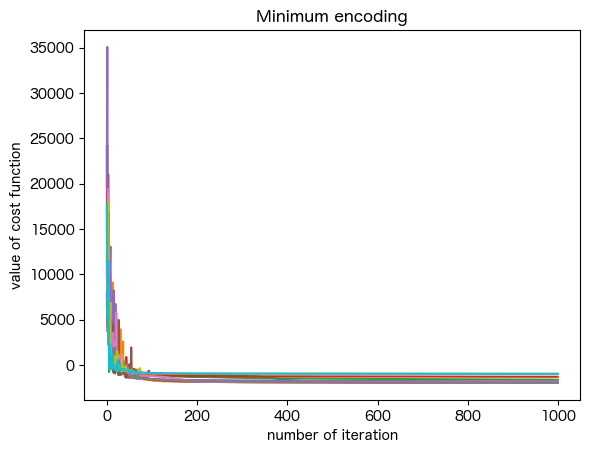

In [37]:
for i in progress:
    plt.plot(i, label=(f"iteration = {i}"))
plt.xlabel('number of iteration')
plt.ylabel('value of cost function')
# plt.title('Minimum encoding with different number of shots (layer = 4) with qiskit.primitives')
plt.title('Minimum encoding')
# plt.legend()
plt.show()

In [38]:
print(f'it took {t} seconds')

it took 746.6872823238373 seconds


In [39]:
print(f'Sample => {sample}')

Sample =>    0  1  2  3  4  5  6  7       energy num_oc.
0  0  0  0  0  1  1  0  0 -1992.889493       1
5  1  1  0  0  0  0  0  0 -1984.859065       1
7  1  1  0  0  0  0  0  0 -1967.215986       1
6  0  0  0  1  1  0  0  0 -1959.460461       1
1  0  0  1  0  0  1  0  0 -1924.462788       1
4  0  0  1  0  0  1  0  0 -1818.421615       1
2  0  0  0  0  1  1  0  0 -1634.718831       1
3  0  0  0  0  0  1  0  0 -1312.545649       1
8  0  0  0  0  0  0  1  0 -1002.611335       1
9  1  0  0  0  0  0  0  0  -981.110417       1
['BINARY', 10 rows, 10 samples, 8 variables]


feasibles: SampleSet(record=Record(solution={'x': [(([4, 5],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([3, 4],), [1, 1], (8,)), (([2, 5],), [1, 1], (8,)), (([2, 5],), [1, 1], (8,)), (([4, 5],), [1, 1], (8,))]}, num_occurrences=[1, 1, 1, 1, 1, 1, 1]), evaluation=Evaluation(energy=[-1992.8894925405366, -1924.4627882459424, -1634.7188309896296, -1312.5456486806772, -1818.421614985471, -1984.859065168285, -1959.4604608951543], objective=[0.5101112718577223, 0.5834888941241243, 0.5834888941241243, 0.5101112718577223, 0.5644889585554866, 0.5644889585554866, 0.5101112718577223], constraint_violations={'one-time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))
Lowest solution index: 0, Lowest obj

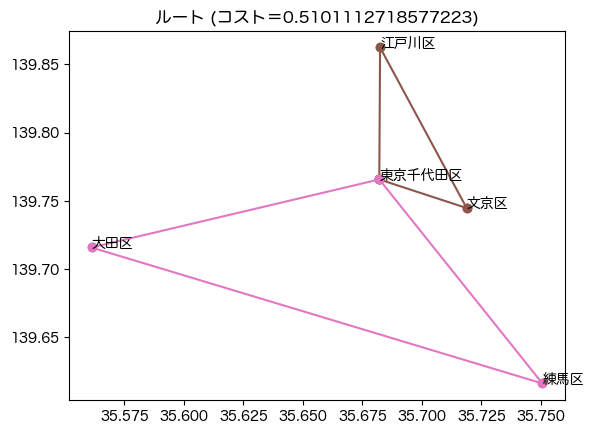

([[0, 3, 2, 0], [0, 4, 1, 0]], 0.5101112718577223)

In [40]:
vrp_solution(sample, pubo_builder, compiled_model, geo_data,distance_data, routes)

Notice that on the reference (2), they use ADAM optimizor. So we have try one that implemented in Qiskit, but it resulted in 20 times expensive computationaly compare to COBLYLA which is used on the reference (1). This is mainly because that refrence (2) uses special version of ADAM. We did not try to implement that since it is out of scope from our purpose.

Also, we repeat the optimization process for 10 times to get the correct solution since single run does not necessary produce the feasble solution. Also, if you increase problem size most likely you will need more runs. Obviously it will leads to increse of computation time but it is expected.